In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
# %env CUDA_VISIBLE_DEVICES=4
!nvidia-smi
%config InlineBackend.figure_format = 'retina'

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
Thu Jan 30 19:51:49 2025       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.125.06   Driver Version: 525.125.06   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:01:00.0 Off |                    0 |
| N/A   54C    P0    77W / 275W |      3MiB / 81920MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100-SXM...  On   | 00000000:47:00.0 Off

In [2]:
import hydra
from hydra.utils import instantiate
from hydra import initialize, compose

In [3]:
import sys
import os
import getpass

os.chdir('/home/' + getpass.getuser() + '/Projects/CaloQVAE/')
sys.path.insert(1, '/home/' + getpass.getuser() + '/Projects/CaloQVAE/')

In [4]:
#external libraries
import os
import pickle
import datetime
import sys
import yaml
import json

import torch.optim as optim
import torch
from torch import nn
from torch.nn.functional import binary_cross_entropy_with_logits
torch.manual_seed(32)
import numpy as np
np.random.seed(32)
import matplotlib.pyplot as plt
import hydra
from hydra.utils import instantiate

from omegaconf import OmegaConf

import time

# PyTorch imports
from torch import device, load, save
from torch.nn import DataParallel
from torch.cuda import is_available

# Add the path to the parent directory to augment search for module
sys.path.append(os.getcwd())
    
# Weights and Biases
import wandb

#self defined imports
from CaloQVAE import logging

[19:52:06.022] INFO   CaloQVAE                                          Willkommen!
[19:52:06.023] INFO   CaloQVAE                                          Loading configuration.


In [5]:
logger = logging.getLogger(__name__)

from data.dataManager import DataManager
from utils.plotting.plotProvider import PlotProvider
from engine.engine import Engine
from models.modelCreator import ModelCreator

from utils.plotting.HighLevelFeatures import HighLevelFeatures as HLF
# HLF_1_photons = HLF('photon', filename='/raid/javier/Datasets/CaloVAE/data/atlas/binning_dataset_1_photons.xml', wandb=False)
# HLF_1_pions = HLF('pion', filename='/raid/javier/Datasets/CaloVAE/data/atlas/binning_dataset_1_pions.xml', wandb=False)
# HLF_1_electron = HLF('electron', filename='/raid/javier/Datasets/CaloVAE/data/atlas_dataset2and3/binning_dataset_2.xml', wandb=False)

[19:52:06.724] INFO   numexpr.utils                                     Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
[19:52:06.725] INFO   numexpr.utils                                     Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
[19:52:06.725] INFO   numexpr.utils                                     NumExpr defaulting to 8 threads.
2025-01-30 19:52:07,095 dwave.cloud INFO  MainThread Log level for 'dwave.cloud' namespace set to 0
[19:52:07.095] INFO   dwave.cloud                                       Log level for 'dwave.cloud' namespace set to 0


In [6]:
hydra.core.global_hydra.GlobalHydra.instance().clear()
initialize(version_base=None, config_path="../configs")

hydra.initialize()

In [7]:
# run_path= "/home/javier/Projects/CaloQVAE/outputs/2024-07-18/18-22-00/wandb/run-20240718_182201-5q976hf7/files/AtlasConditionalQVAE_atlas_default_best.pth"
# fn = create_filenames_dict(run_path)

In [8]:

# config=compose(config_name="config.yaml")
config=compose(config_name="config.yaml")

HLF_1_photons = HLF('photon', filename=config.data.binning_xml_photons, wandb=False)
HLF_1_pions = HLF('pion', filename=config.data.binning_xml_pions, wandb=False)
HLF_1_electron = HLF('electron', filename=config.data.binning_xml_electrons, wandb=False)

wandb.init(project="caloqvae", entity=config.data.entity, config=config, mode='disabled')
modelCreator = ModelCreator(cfg=config)
dataMgr = DataManager(cfg=config)
#initialise data loaders
dataMgr.init_dataLoaders()
#run pre processing: get/set input dimensions and mean of train dataset
dataMgr.pre_processing()

if config.model.activation_fct.lower()=="relu":
    modelCreator.default_activation_fct=torch.nn.ReLU()
elif config.model.activation_fct.lower()=="tanh":
    modelCreator.default_activation_fct=torch.nn.Tanh()
else:
    logger.warning("Setting identity as default activation fct")
    modelCreator.default_activation_fct=torch.nn.Identity()

#instantiate the chosen model
#loads from file 
model=modelCreator.init_model(dataMgr=dataMgr)

#create the NN infrastructure
model.create_networks()

/raid/javier/anaconda3/lib/python3.11/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'config.yaml': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)
[19:52:10.129] INFO   data.dataManager                                  Loading Data
[19:52:31.125] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f97baaee410>: 80000 events, 157 batches
[19:52:31.126] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f97baaf40d0>: 10000 events, 10 batches
[19:52:31.127] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f97baaf5d10>: 10000 events, 10 batches
[19:52:33.417] INFO   models.modelCreator                               Initialising Model Type AtlasConditionalQVAE3D
2025-01-30 19:52

Initializing NetworkV3


In [9]:


#Not printing much useful info at the moment to avoid clutter. TODO optimise
model.print_model_info()
# for name, param in model.named_parameters():
#         print(name, param.requires_grad)

# Load the model on the GPU if applicable
# dev = None
# if (config.device == 'gpu') and config.gpu_list:
#     logger.info('Requesting GPUs. GPU list :' + str(config.gpu_list))
#     devids = ["cuda:{0}".format(x) for x in list(config.gpu_list)]
#     logger.info("Main GPU : " + devids[0])

#     if is_available():
#         print(devids[0])
#         dev = device(devids[0])
#         if len(devids) > 1:
#             logger.info(f"Using DataParallel on {devids}")
#             model = DataParallel(model, device_ids=list(config.gpu_list))
#         logger.info("CUDA available")
#     else:
#         dev = device('cpu')
#         logger.info("CUDA unavailable")
# else:
#     logger.info('Requested CPU or unable to use GPU. Setting CPU as device.')
#     dev = device('cpu')
# dev = torch.device("cuda:0")
dev = "cuda:{0}".format(config.gpu_list[0])

# Send the model to the selected device
# model.to(dev)
# Log metrics with wandb
wandb.watch(model)

# For some reason, need to use postional parameter cfg instead of named parameter
# with updated Hydra - used to work with named param but now is cfg=None 
engine=instantiate(config.engine, config)

#TODO for some reason hydra double instantiates the engine in a
#newer version if cfg=config is passed as an argument. This is a workaround.
#Find out why that is...
engine._config=config
#add dataMgr instance to engine namespace
engine.data_mgr=dataMgr
#add device instance to engine namespace
engine.device=dev    
#instantiate and register optimisation algorithm
engine.optimiser = torch.optim.Adam(model.parameters(),
                                    lr=config.engine.learning_rate)
#add the model instance to the engine namespace
engine.model = model
# add the modelCreator instance to engine namespace
engine.model_creator = modelCreator
engine.model = engine.model.to(dev)

[19:52:36.377] INFO   wandb                                             Watching
/raid/javier/anaconda3/lib/python3.11/site-packages/coffea/util.py:154: FutureWarning: In coffea version v2023.3.0 (target date: 31 Mar 2023), this will be an error.
(Set coffea.deprecations_as_errors = True to get a stack trace now.)
ImportError: coffea.hist is deprecated
  warnings.warn(message, FutureWarning)
[19:52:36.759] INFO   engine.engineAtlas                                Setting up engine Atlas.
[19:52:36.760] INFO   engine.engineCaloV3                               Setting up engine Calo.
[19:52:36.761] INFO   engine.engine                                     Setting up default engine.


In [57]:
train_loader,test_loader,val_loader = engine.data_mgr.create_dataLoader()

[16:28:35.496] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7fe1fcf8d850>: 80000 events, 157 batches
[16:28:35.498] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7fe1ec3e38d0>: 10000 events, 10 batches
[16:28:35.499] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7fe1fcf4add0>: 10000 events, 10 batches


In [11]:
engine.model._qpu_sampler.properties["chip_id"]

'Advantage2_prototype2.6'

In [10]:

    
# #stilted-disco-503 | Z
# # run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-08-15/18-39-39/wandb/run-20240815_183940-3in69i3s/files/AtlasConditionalQVAE3D_atlas_default_70.pth"
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-10-04/14-10-35/wandb/run-20241004_141036-oxw8je9r/files/AtlasConditionalQVAE3D_atlas_default_200.pth"
# modelname = 'stilted-disco-503'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2024-08-15/18-47-19/wandb/run-20240817_194429-1valeubk/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=False
#     cond = True

# RBM centered not
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-12-18/22-03-41/wandb/run-20241218_220342-nqwgiewh/files/AtlasConditionalQVAE3D_atlas_default_240.pth"
run_path = "/home/javier/Projects/CaloQVAE/outputs/2024-12-18/22-03-41/wandb/run-20250121_132833-nqwgiewh/files/AtlasConditionalQVAE3D_atlas_default_330.pth"
modelname = 'restful-night-532'
datascaled = 'reduced'
with open("/home/javier/Projects/CaloQVAE/outputs/2024-12-18/22-03-41/wandb/run-20241218_220342-nqwgiewh/files/config.yaml", 'r') as file:
    model_config = yaml.safe_load(file)
    R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
    reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
    scaled=False

# RBM centered 
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2025-01-19/02-13-29/wandb/run-20250121_132020-vj9yai2u/files/AtlasConditionalQVAE3D_atlas_default_220.pth"
run_path = "/home/javier/Projects/CaloQVAE/outputs/2025-01-19/02-13-29/wandb/run-20250121_132020-vj9yai2u/files/AtlasConditionalQVAE3D_atlas_default_450.pth"
modelname = 'iconic-deluge-569'
datascaled = 'reduced'
with open("/home/javier/Projects/CaloQVAE/outputs/2025-01-19/02-13-29/wandb/run-20250119_021330-vj9yai2u/files/config.yaml", 'r') as file:
    model_config = yaml.safe_load(file)
    R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
    reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
    scaled=False

# # RBM centered + disc
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2025-01-19/02-14-35/wandb/run-20250119_021436-f0vh2kl3/files/AtlasConditionalQVAE3D_atlas_default_100.pth"
# modelname = 'dainty-tree-570'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2025-01-19/02-14-35/wandb/run-20250119_021436-f0vh2kl3/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     try:
#         R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     except:
#         R = 1e-7
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=False
    
    
# # RBM centered + full
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2025-01-21/13-40-26/wandb/run-20250121_134027-18yz2gl1/files/AtlasConditionalQVAE3D_atlas_default_190.pth"
# modelname = 'sleek-firebrand-571'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2025-01-21/13-40-26/wandb/run-20250121_134027-18yz2gl1/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=False


# RBM centered + pos energy BP to encoder. Final beta 100
run_path = "/home/javier/Projects/CaloQVAE/outputs/2025-01-28/00-26-28/wandb/run-20250128_002629-1aipg0dn/files/AtlasConditionalQVAE3D_atlas_default_230.pth"
modelname = 'giddy-violet-575'
datascaled = 'reduced'
with open("/home/javier/Projects/CaloQVAE/outputs/2025-01-28/00-26-28/wandb/run-20250128_002629-1aipg0dn/files/config.yaml", 'r') as file:
    model_config = yaml.safe_load(file)
    R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
    reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
    scaled=False
    
arch = config['model']['model_type']
part = config['data']['particle_type']
print(arch)
print(part)
print(scaled, reducedata, R)


# load_state(model, run_path, 'cuda:{0}'.format(cfg.gpu_list[0]))
# load_state(model, run_path, dev)
modelCreator.load_state(run_path, dev)
engine.model.eval();

[19:52:37.335] INFO   models.modelCreator                               Loading state
/home/javier/Projects/CaloQVAE/models/modelCreator.py:155: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experi

AtlasConditionalQVAE3D
electron-ds2
False True 1e-07
Loading weights for module =  _activation_fct
Loading weights for module =  _bce_loss
Loading weights for module =  _energy_activation_fct
Loading weights for module =  _hit_activation_fct
Loading weights for module =  _output_loss
Loading weights for module =  _hit_loss
Loading weights for module =  _hit_smoothing_dist_mod
Loading weights for module =  _inference_energy_activation_fct
Loading weights for module =  encoder
Loading weights for module =  prior
Loading weights for module =  decoder


In [ ]:
import h5py
with h5py.File("/home/javier/RBM_weights.hdf5", 'w') as hdf_file:
    for key, value in engine.model.prior.weight_dict.items():
        # Each key-value pair in the dictionary becomes a dataset in the HDF5 file
        hdf_file.create_dataset(key, data=value.detach().cpu())
        
with h5py.File("/home/javier/RBM_biases.hdf5", 'w') as hdf_file:
    for key, value in engine.model.prior.bias_dict.items():
        # Each key-value pair in the dictionary becomes a dataset in the HDF5 file
        hdf_file.create_dataset(key, data=value.detach().cpu())

In [145]:
xx = next(iter(test_loader))
# xx = next(iter(train_loader))
in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1]) # input , label

torch.Size([1024, 6480])


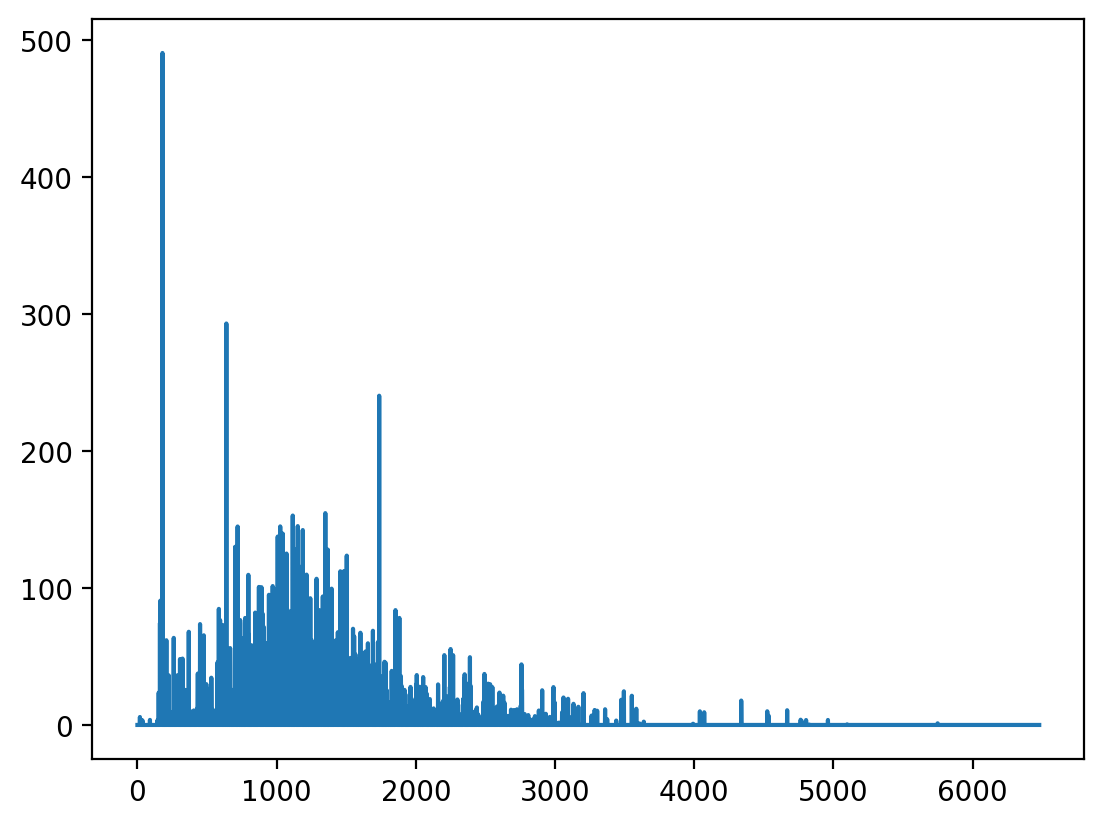

In [146]:
print(in_data.shape)
plt.plot(in_data.cpu().numpy()[3,:])

In [23]:
with torch.no_grad():
    in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1])
    if True: #reducedata:
        in_data = engine._reduce(in_data, true_energy)
    fwd_output = engine.model((in_data, true_energy), True)
    engine._model.sampler._batch_size = true_energy.shape[0]
    # if cond:
    sample_energies, sample_data = engine._model.generate_samples_cond(num_samples=true_energy.shape[0], true_energy=true_energy)
    # else:
        # sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy)
    engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
idx = 21
plt.plot(in_data.cpu().numpy()[idx,:])
plt.plot(fwd_output.output_activations.detach().cpu().numpy()[idx,:], alpha=0.5)
plt.plot(sample_data.detach().cpu().numpy()[idx,:], alpha=0.5)
plt.legend(["gt","recon","samp"])
plt.xlabel("voxel index")
plt.ylabel("energy per voxel in new variable")
plt.show()

plt.plot(engine._reduceinv(in_data,true_energy).cpu().numpy()[idx,:])
plt.plot(engine._reduceinv(fwd_output.output_activations,true_energy).detach().cpu().numpy()[idx,:], alpha=0.5)
plt.plot(engine._reduceinv(sample_data, true_energy).detach().cpu().numpy()[idx,:], alpha=0.5)
plt.legend(["gt","recon","samp"])
plt.xlabel("voxel index")
plt.ylabel("energy per voxel")
plt.show()

plt.plot(engine._reduceinv(in_data,true_energy).cpu().numpy()[idx,:]/true_energy.cpu().numpy()[idx,0])
plt.plot(engine._reduceinv(fwd_output.output_activations,true_energy).detach().cpu().numpy()[idx,:]/true_energy.cpu().numpy()[idx,0], alpha=0.5)
plt.plot(engine._reduceinv(sample_data, true_energy).detach().cpu().numpy()[idx,:]/true_energy.cpu().numpy()[idx,0], alpha=0.5)
plt.legend(["gt","recon","samp"])
plt.xlabel("voxel index")
plt.ylabel("energy per voxel")
plt.show()
print(true_energy[idx,:], engine._reduceinv(in_data, true_energy)[idx,:].sum())

NameError: name 'xx' is not defined

In [123]:
# engine.model.prior.weight_dict['01']
# post_samples
post_samples_2 = torch.bernoulli(torch.empty_like(post_samples).uniform_(0, 1))
# post_samples_2[1,:].repeat(768,1)
post_samples.shape

torch.Size([1024, 1208])

In [130]:
with torch.no_grad():
    # for j,xx in enumerate(val_loader):
    # for xx in train_loader:
    in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1])
    #################################################
    # true_energy = true_energy[:n_samples4_qpu,:]
    # in_data = in_data[:n_samples4_qpu,:]
    #################################################
    if True:
        in_data = engine._reduce(in_data, true_energy, R=R)
    # enIn = torch.cat((in_data, true_energy), dim=1)
    # beta, post_logits, post_samples = engine.model.encoder(enIn, False)
    beta, post_logits, post_samples = engine.model.encoder(in_data, true_energy, False)
    post_samples = torch.cat(post_samples, 1)
    post_samples_2 = torch.bernoulli(torch.empty_like(post_samples).uniform_(0, 1))
    # post_samples_2 = post_samples_2[2,:].repeat(1024,1)

    output_hits, output_activations = engine.model.decoder(post_samples, true_energy)
    output_hits_2, output_activations_2 = engine.model.decoder(post_samples_2, true_energy)
        
        # if j>0:
        #     break

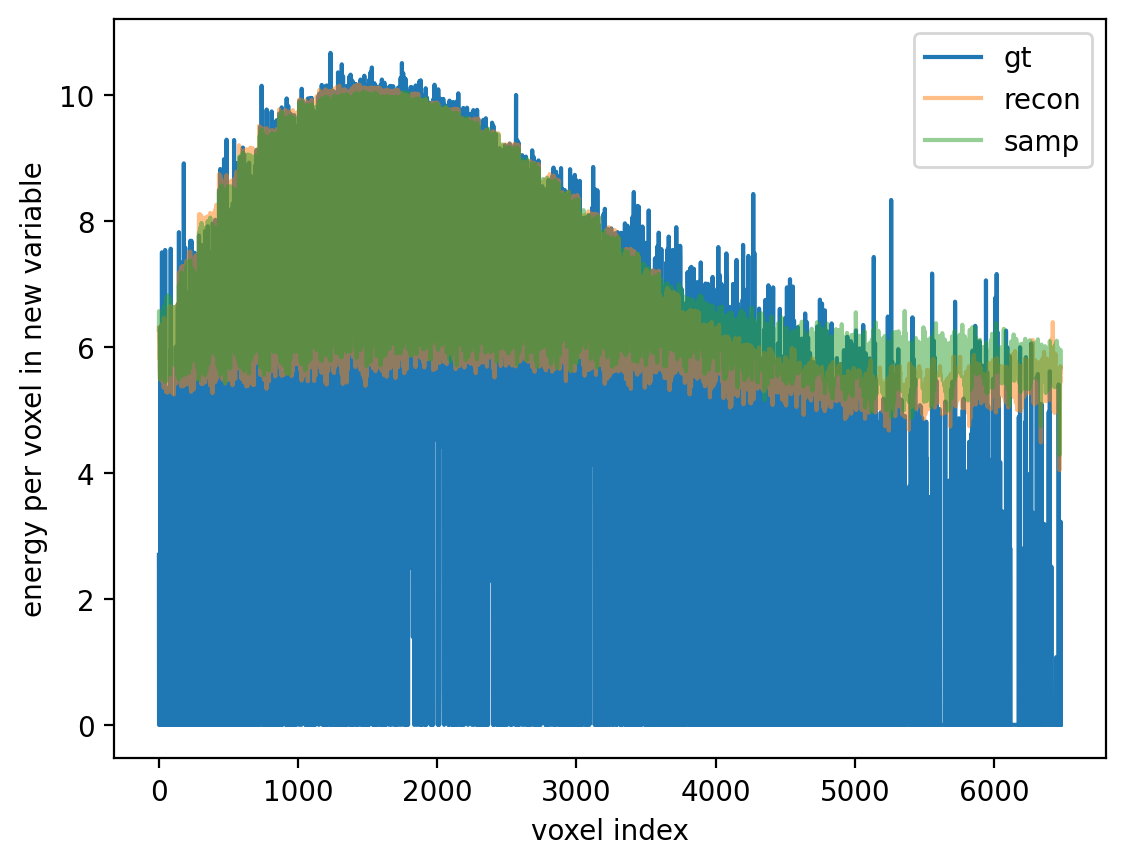

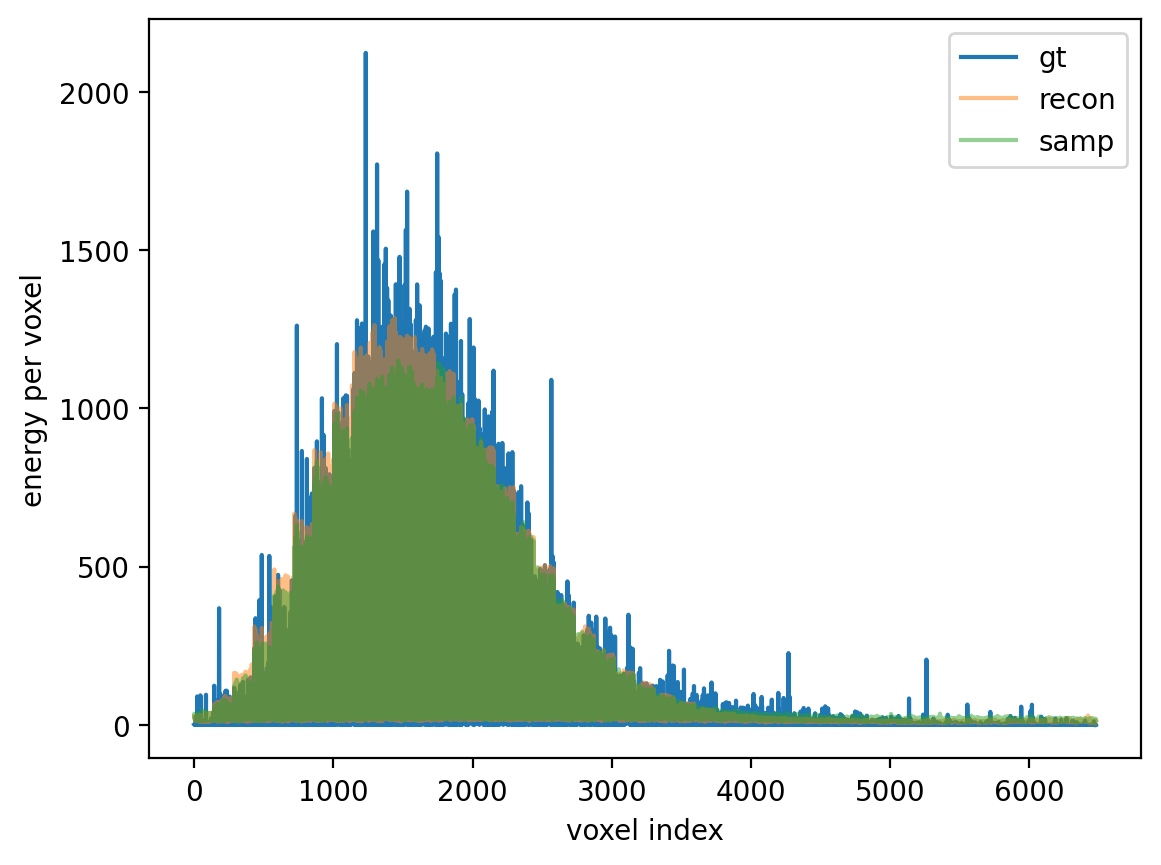

tensor([496389.0938], device='cuda:4') tensor(389130.6562, device='cuda:4')


In [131]:

idx = 21
plt.plot(in_data.cpu().numpy()[idx,:])
plt.plot(output_activations.detach().cpu().numpy()[idx,:], alpha=0.5)
plt.plot(output_activations_2.detach().cpu().numpy()[idx,:], alpha=0.5)
# plt.plot(sample_data.detach().cpu().numpy()[idx,:], alpha=0.5)
plt.legend(["gt","recon","samp"])
plt.xlabel("voxel index")
plt.ylabel("energy per voxel in new variable")
plt.show()

plt.plot(engine._reduceinv(in_data,true_energy).cpu().numpy()[idx,:])
plt.plot(engine._reduceinv(output_activations,true_energy).detach().cpu().numpy()[idx,:], alpha=0.5)
plt.plot(engine._reduceinv(output_activations_2,true_energy).detach().cpu().numpy()[idx,:], alpha=0.5)
# plt.plot(engine._reduceinv(sample_data, true_energy).detach().cpu().numpy()[idx,:], alpha=0.5)
plt.legend(["gt","recon","samp"])
plt.xlabel("voxel index")
plt.ylabel("energy per voxel")
plt.show()

# plt.plot(engine._reduceinv(in_data,true_energy).cpu().numpy()[idx,:]/true_energy.cpu().numpy()[idx,0])
# plt.plot(engine._reduceinv(fwd_output.output_activations,true_energy).detach().cpu().numpy()[idx,:]/true_energy.cpu().numpy()[idx,0], alpha=0.5)
# plt.plot(engine._reduceinv(sample_data, true_energy).detach().cpu().numpy()[idx,:]/true_energy.cpu().numpy()[idx,0], alpha=0.5)
# plt.legend(["gt","recon","samp"])
# plt.xlabel("voxel index")
# plt.ylabel("energy per voxel")
# plt.show()
print(true_energy[idx,:], engine._reduceinv(in_data, true_energy)[idx,:].sum())

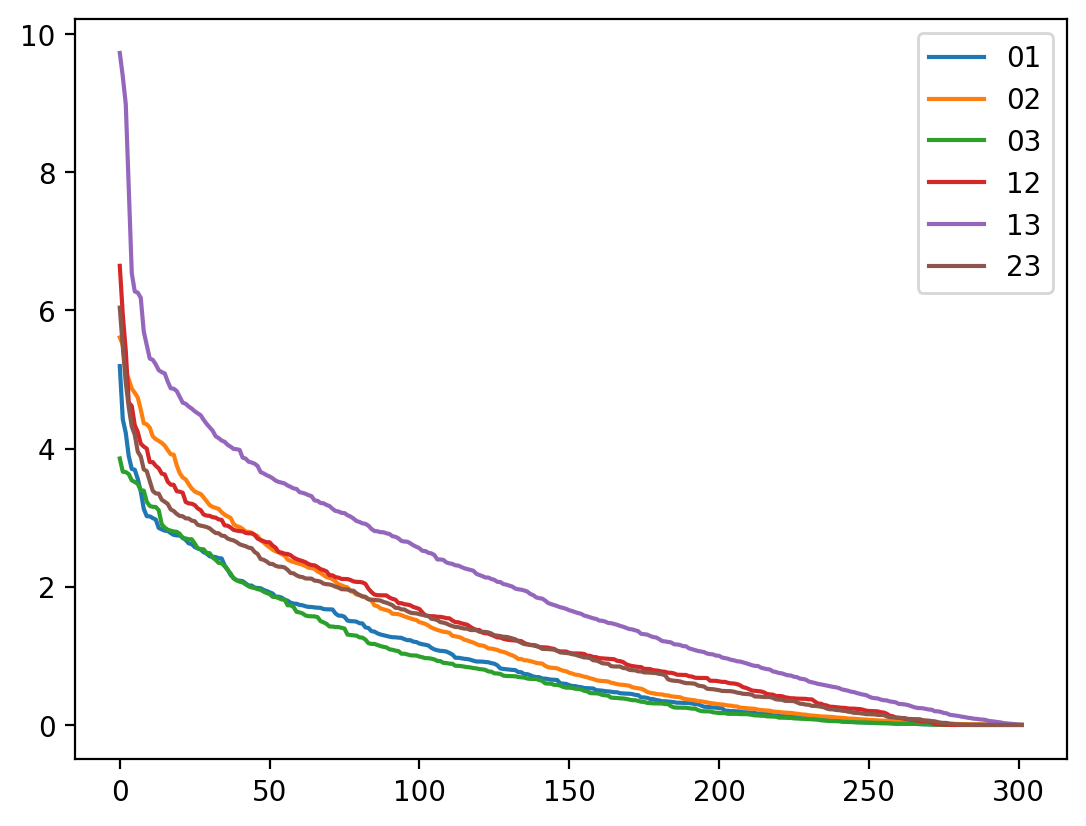

In [13]:
for mat in ['01','02','03','12','13','23']:
    # engine.model.prior.weight_dict[mat] = torch.zeros_like(engine.model.prior.weight_dict[mat])
    # engine.model.prior.weight_dict[mat] = 0.01 * engine.model.prior.weight_dict[mat]
    plt.plot(torch.linalg.svdvals(engine.model.prior.weight_dict[mat]).detach().cpu().numpy(), label=mat)
plt.legend()
plt.show()

tensor(-4.1358, device='cuda:4', grad_fn=<MinBackward1>)
tensor(-3.6834, device='cuda:4', grad_fn=<MinBackward1>)
tensor(-3.1168, device='cuda:4', grad_fn=<MinBackward1>)
tensor(-4.6189, device='cuda:4', grad_fn=<MinBackward1>)
tensor(-3.9949, device='cuda:4', grad_fn=<MinBackward1>)
tensor(-4.0543, device='cuda:4', grad_fn=<MinBackward1>)


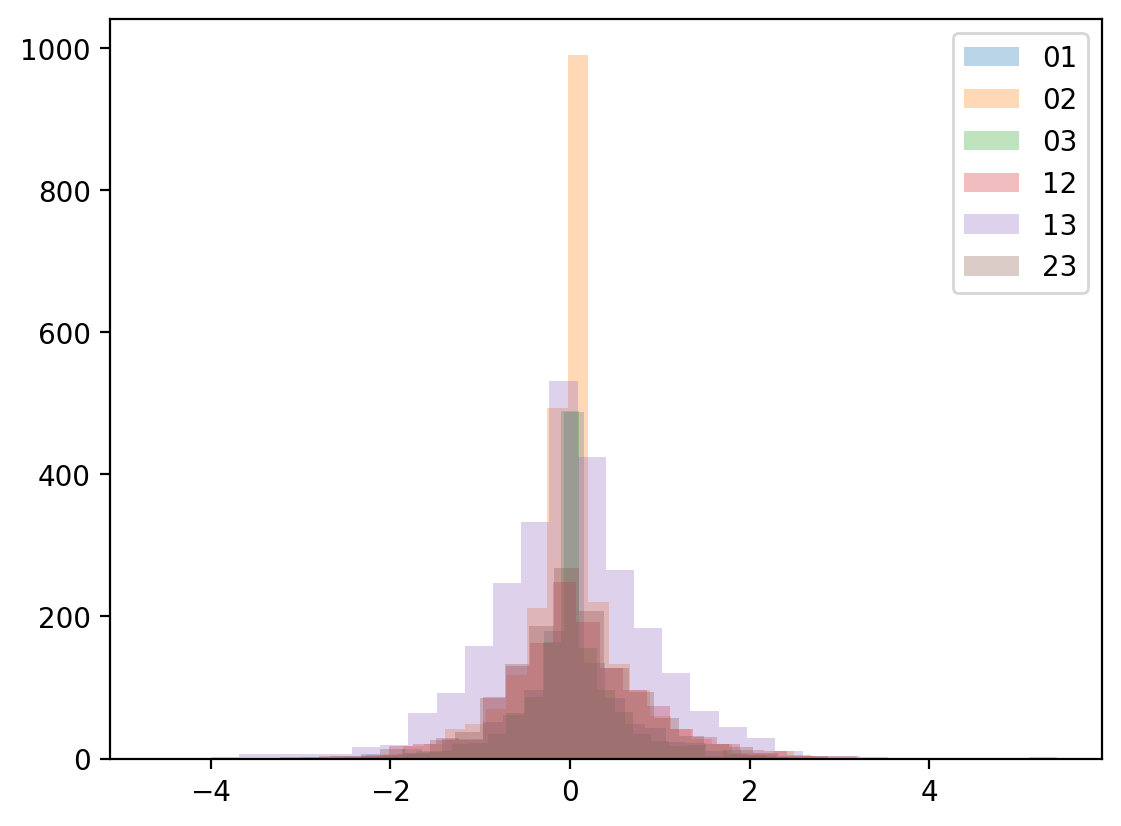

In [14]:
for mat in ['01','02','03','12','13','23']:
    plt.hist(engine.model.prior.weight_dict[mat][(engine.model.prior.weight_dict[mat]!=0)].view(-1).detach().cpu().numpy(), alpha=0.3, label=mat, bins=30)
    print(engine.model.prior.weight_dict[mat][(engine.model.prior.weight_dict[mat]!=0)].view(-1).min())
plt.legend()
plt.show()

In [49]:
# engine.model.prior.bias_dict['0']
# torch.zeros_like(engine.model.prior.bias_dict[mat])
# mat='01'
# engine.model.prior.weight_dict['01'][(engine.model.prior.weight_dict[mat]!=0)].view(-1).min()

tensor(-2.2140, device='cuda:4', grad_fn=<MinBackward1>)

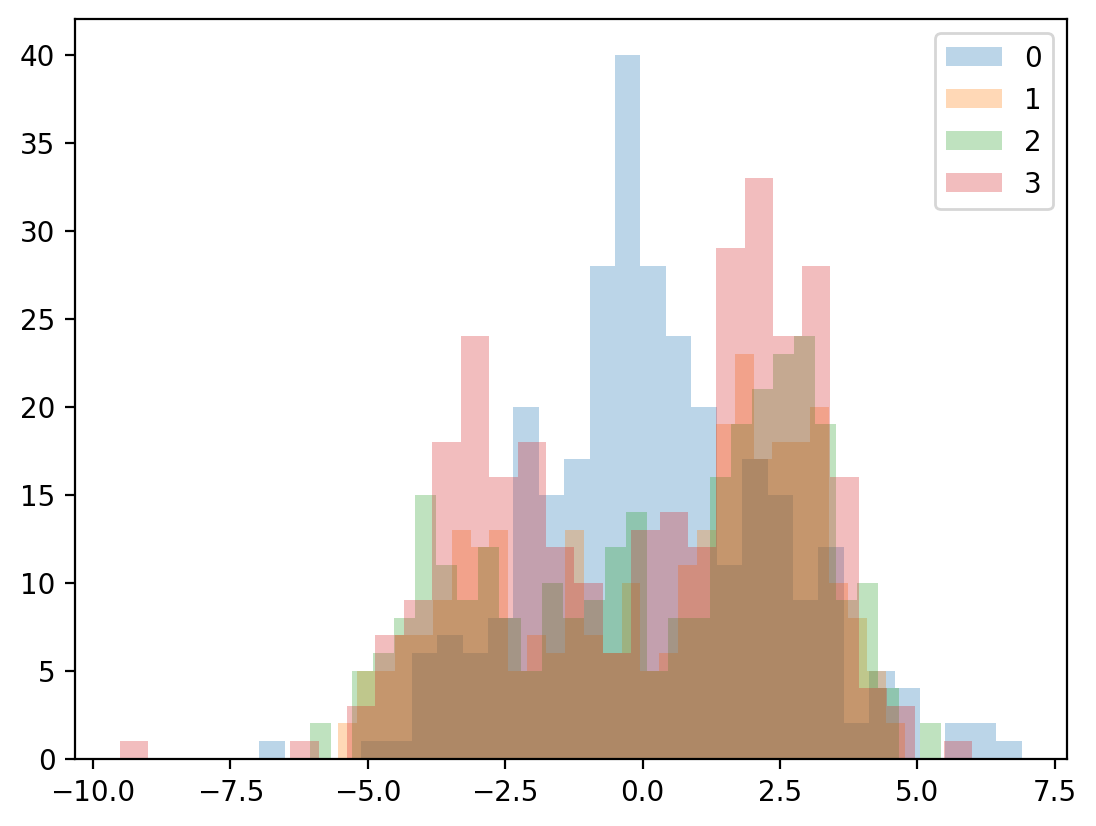

In [15]:
for mat in ['0','1','2','3']:
    # engine.model.prior.bias_dict[mat] = torch.zeros_like(engine.model.prior.bias_dict[mat])
    # engine.model.prior.bias_dict[mat] = 0.01 * engine.model.prior.bias_dict[mat]
    plt.hist(engine.model.prior.bias_dict[mat][(engine.model.prior.bias_dict[mat]!=0)].view(-1).detach().cpu().numpy(), alpha=0.3, label=mat, bins=30)
plt.legend()
plt.show()

In [263]:
directory_path = f'/home/javier/Projects/CaloQVAE/figs/DWAVE'
if not os.path.isdir(directory_path):
    os.mkdir(directory_path) 
    print(modelname)
else:
    pass

earnest-frost-483


In [16]:
def create_random_fields(l, dev, i=0):
        # l = dwave_bias['0'].shape[0]
        if i==0:
            random_vec = (torch.ones((4*l,))*2 - 1).to(dev, dtype=torch.float)
        elif i==1:
            random_vec = (torch.zeros((4*l,))*2 - 1).to(dev, dtype=torch.float)
        elif i ==2:
            random_vec = (torch.randint(2,(4*l,))*2 - 1).to(dev, dtype=torch.float)
        random_field = {}

        for i,key in enumerate(['0','1','2','3']):
            random_field[key] = random_vec[i*l:(i+1)*l]

        return random_field, random_vec

In [17]:
random_field, random_vec = create_random_fields(512, dev,1)
random_vec

tensor([-1., -1., -1.,  ..., -1., -1., -1.], device='cuda:4')

In [25]:
# rand_field=True
true_energy.device

device(type='cuda', index=4)

In [79]:
# if rand_field:
#     beta, beta_list, rbm_energy_list, dwave_energy_list, thrsh_met = engine.model.find_beta_rand_field(random_field, random_vec, num_reads=1000, beta_init=4.29, lr=0.01, num_epochs = 30, delta = 4.0, 
#                                                                                         method = 1, TOL=True, const = 1.0, adaptive = False)
# else:
beta, beta_list, rbm_energy_list, dwave_energy_list, thrsh_met = engine.model.find_beta(num_reads=1000, beta_init=4.29, lr=0.01, num_epochs = 30, delta = 4.0, 
                                                                                        method = 2, TOL=True, const = 1.0, adaptive = True)
beta0 = beta

[19:37:56.692] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29
[19:37:59.733] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 4.744273173109545
[19:38:02.874] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 2: beta = 4.710268411198128
[19:38:05.900] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 3: beta = 4.651178200419356
[19:38:08.934] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 4: beta = 4.616834700931881
[19:38:10.943] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 5: beta = 4.636689733717715
[19:38:12.970] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 6: beta = 4.617076719976227
[19:38:15.094] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 7: beta = 4.583007289739584
[19:38:17.307] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 8: beta = 4.530501810678934
[19:38:19.222] INFO   models.autoencoders.AtlasConditionalQ

In [57]:
beta, beta_list, rbm_energy_list, dwave_energy_list, thrsh_met = engine.model.find_beta_cond([true_energy[3,0].item()], true_energy.device, num_reads=1000, beta_init=4.29, lr=0.01, num_epochs = 30, delta = 4.0, method = 1, TOL=True, const = 1.0, adaptive = False)
beta0 = beta

[17:37:39.281] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.41
[17:37:42.105] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 4.4305126953125
[17:37:45.105] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 2: beta = 4.4233837890625
[17:37:48.032] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 3: beta = 4.404677734375
[17:37:51.121] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 4: beta = 4.309555664062501
[17:37:53.297] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 5: beta = 4.283505859375
[17:37:55.388] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 6: beta = 4.273251953125
[17:37:57.589] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 7: beta = 4.2644970703125
[17:37:59.836] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 8: beta = 4.2695849609375


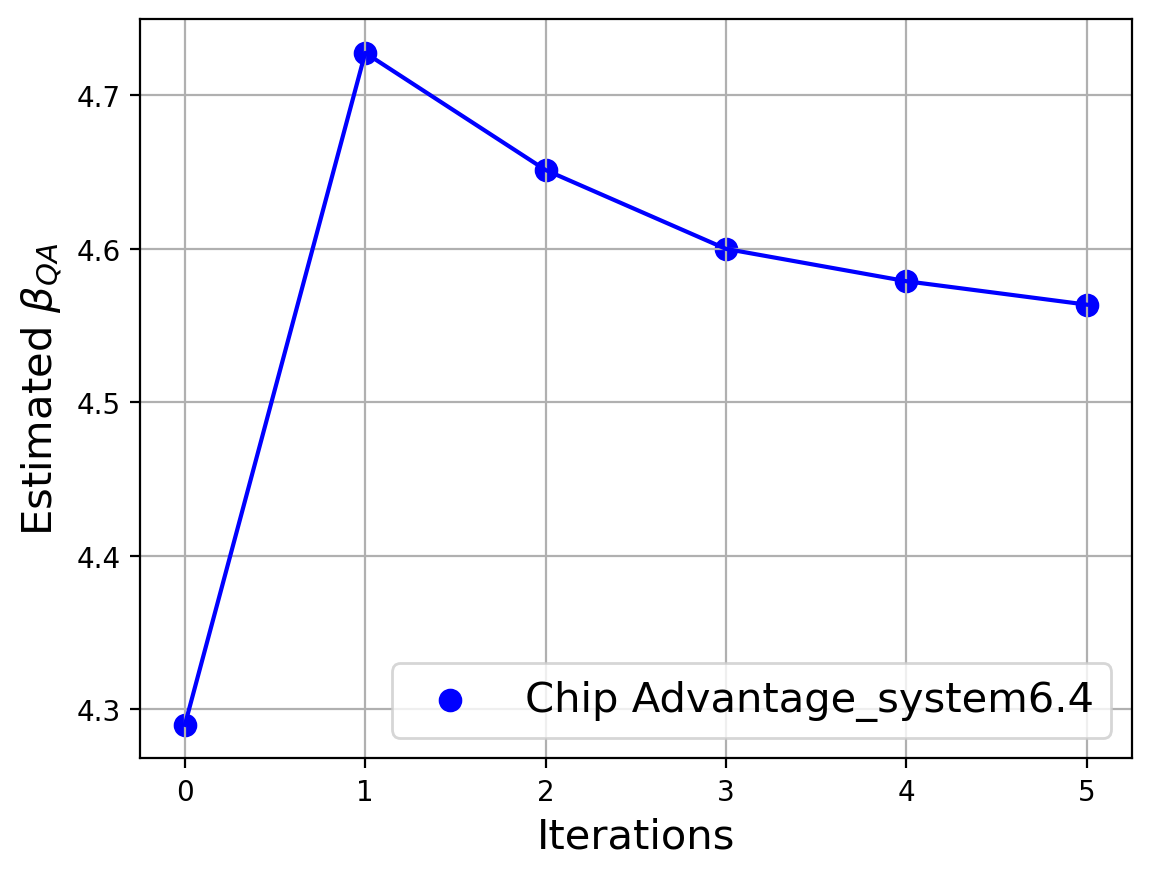

In [62]:
plt.scatter(range(len(beta_list)), beta_list, linewidth=2.5, color="b" )
plt.plot(range(len(beta_list)), beta_list, linewidth=1.5, color="b" )
plt.xlabel("Iterations", fontsize=15)
plt.ylabel("Estimated $β_{QA}$", fontsize=15)
plt.legend([f'Chip {engine.model._qpu_sampler.properties["chip_id"]}'], fontsize=15)
plt.grid("True")
# plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/DWAVE/beta_QA_{engine.model._qpu_sampler.properties["chip_id"]}_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

In [63]:
QA = "$β_{QA}$"
Hoffset = -(sum([engine.model.prior.bias_dict[key].sum().detach().cpu().item() for key in engine.model.prior.bias_dict.keys()])/2 
            + sum([engine.model.prior.weight_dict[key].sum().detach().cpu().item() for key in engine.model.prior.weight_dict.keys()])/4)
print(Hoffset)

-488.8992500305176


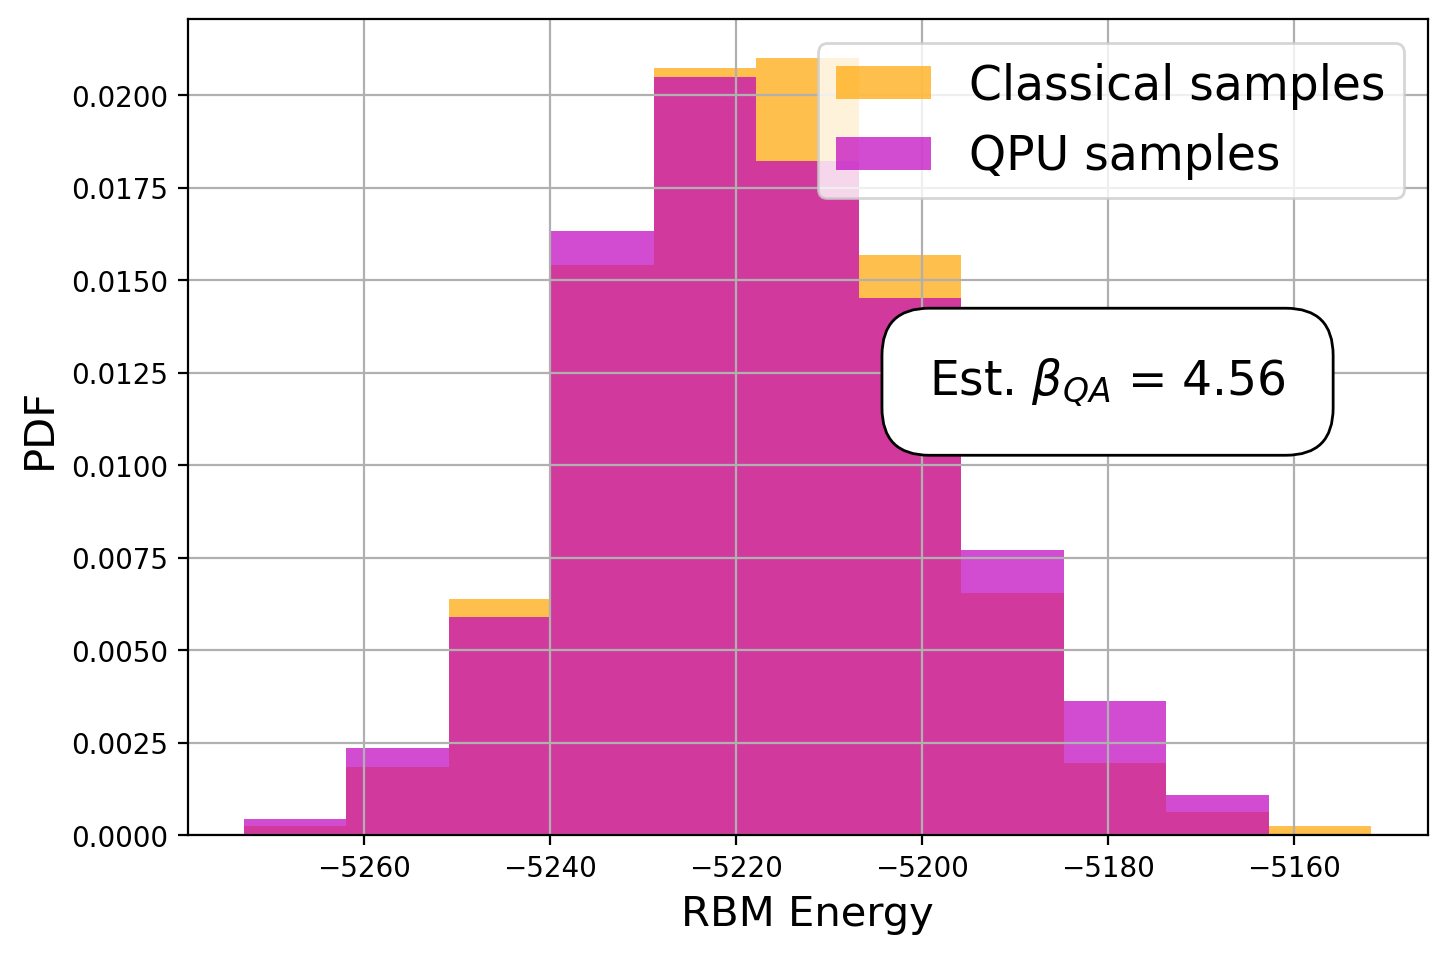

1024
1000


In [64]:
minVal, maxVal = min(dwave_energy_list[-1] + Hoffset), max(dwave_energy_list[-1] + Hoffset)
# minVal, maxVal = min(energy_dwave.detach().cpu().numpy()+ Hoffset/2), max(energy_dwave.detach().cpu().numpy()+ Hoffset/2)
binwidth = (maxVal-minVal)/10

plt.figure(figsize=(8,6))
plt.hist(rbm_energy_list[-1] + Hoffset, density=True, color="orange", alpha=0.7, bins=np.arange(minVal, maxVal + binwidth, binwidth))
plt.hist(dwave_energy_list[-1] + Hoffset, density=True, color="m", alpha=0.7, bins=np.arange(minVal, maxVal + binwidth, binwidth))
plt.xlabel("RBM Energy", fontsize=15)
plt.ylabel("PDF", fontsize=15)
plt.legend(["Classical samples", "QPU samples"], fontsize=17)
# plt.title(f'ln(Z)[AIS] = {np.round(Zais)}, ln(Z)[RAIS] = {np.round(Zrais)}')
plt.figtext(0.7, 0.6, f'Est. {QA} = {np.round(beta0, 2)}', ha='center', va='top', fontsize=17, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1'))
plt.subplots_adjust(bottom=0.2)
plt.grid("True")
# plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/DWAVE/Ising_energy_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()
print(len(rbm_energy_list[-1]))
print(len(dwave_energy_list[-1]))

In [56]:
# engine.model.u

for i in range(len(engine.model.part1)):
    if (engine.model.part1[0] == engine.model.part1[i]).prod() != 1:
        print('not the same', i)
        
(torch.where(torch.tensor(engine.model.part1[0]) ==-1, 0, 1) == engine.model.u[0,:].unsqueeze(0).repeat(engine.model.part1[0].shape[0],1).detach().cpu()).prod()

tensor(1)

In [ ]:
partition_size=config.model.n_latent_nodes_per_p
energy_encoded_data = []

engine.model.eval()
with torch.no_grad():
    for xx in val_loader:
        in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1])
        if reducedata:
            in_data = engine._reduce(in_data, true_energy, R=R)
        # enIn = torch.cat((in_data, true_energy), dim=1)
        # beta, post_logits, post_samples = engine.model.encoder(enIn, False)
        beta, post_logits, post_samples = engine.model.encoder(in_data, true_energy, False)
        post_samples = torch.cat(post_samples, 1)
        post_samples_energy = engine.model.stater.energy_samples(post_samples[:,0:partition_size], post_samples[:,partition_size:2*partition_size], 
                                                 post_samples[:,2*partition_size:3*partition_size], post_samples[:,3*partition_size:4*partition_size], 1.0 )
        energy_encoded_data.append(post_samples_energy.detach().cpu())

energy_encoded_data = torch.cat(energy_encoded_data, dim=0)

In [24]:
#####################################################
rand_field=True

engine.model.prior_samples = []
sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True)

In [43]:
random_field, random_vec = create_random_fields(512, dev,2)
if rand_field:
    h, J, qubit_idxs, idx_dict, dwave_weights, dwave_bias, random_vec = engine.model.ising_model_rand_field(random_field, random_vec, 1/beta0)
else:
    h, J, qubit_idxs, idx_dict, dwave_weights, dwave_bias = engine.model.ising_model(1/beta0)

In [44]:
response_list = []
response_list.append( engine.model._qpu_sampler.sample_ising(h, J, num_reads=1000, answer_mode='raw', auto_scale=False, label="testing"))

In [45]:
response_array = response_list[0].record["sample"]

In [46]:
dwave_samples, dwave_energies, origSamples = engine.model.batch_dwave_samples(response_array, qubit_idxs)
if rand_field:
    # if using rand field
    dwave_samples = random_vec.detach().cpu() * dwave_samples

In [47]:
# dwave_samples = torch.tensor(dwave_samples, dtype=torch.float)
        
_ZERO = torch.tensor(0., dtype=torch.float)
_MINUS_ONE = torch.tensor(-1., dtype=torch.float)

dwave_samples = torch.where(dwave_samples == _MINUS_ONE, _ZERO, dwave_samples)

In [48]:
dwave_samples = dwave_samples.to(dev)

In [49]:
energy_dwave_2 = engine.model.stater.energy_samples(dwave_samples[:,0:512], dwave_samples[:,512:1024], 
                                                  dwave_samples[:,1024:1536], dwave_samples[:,1536:2048], 1.0)
energy_rbm = engine.model.stater.energy_samples(engine.model.prior_samples[:,0:512], engine.model.prior_samples[:,512:1024], 
                                                  engine.model.prior_samples[:,1024:1536], engine.model.prior_samples[:,1536:2048], 1.0)

In [50]:
random_vec

tensor([ 1., -1.,  1.,  ..., -1.,  1.,  1.], device='cuda:4')

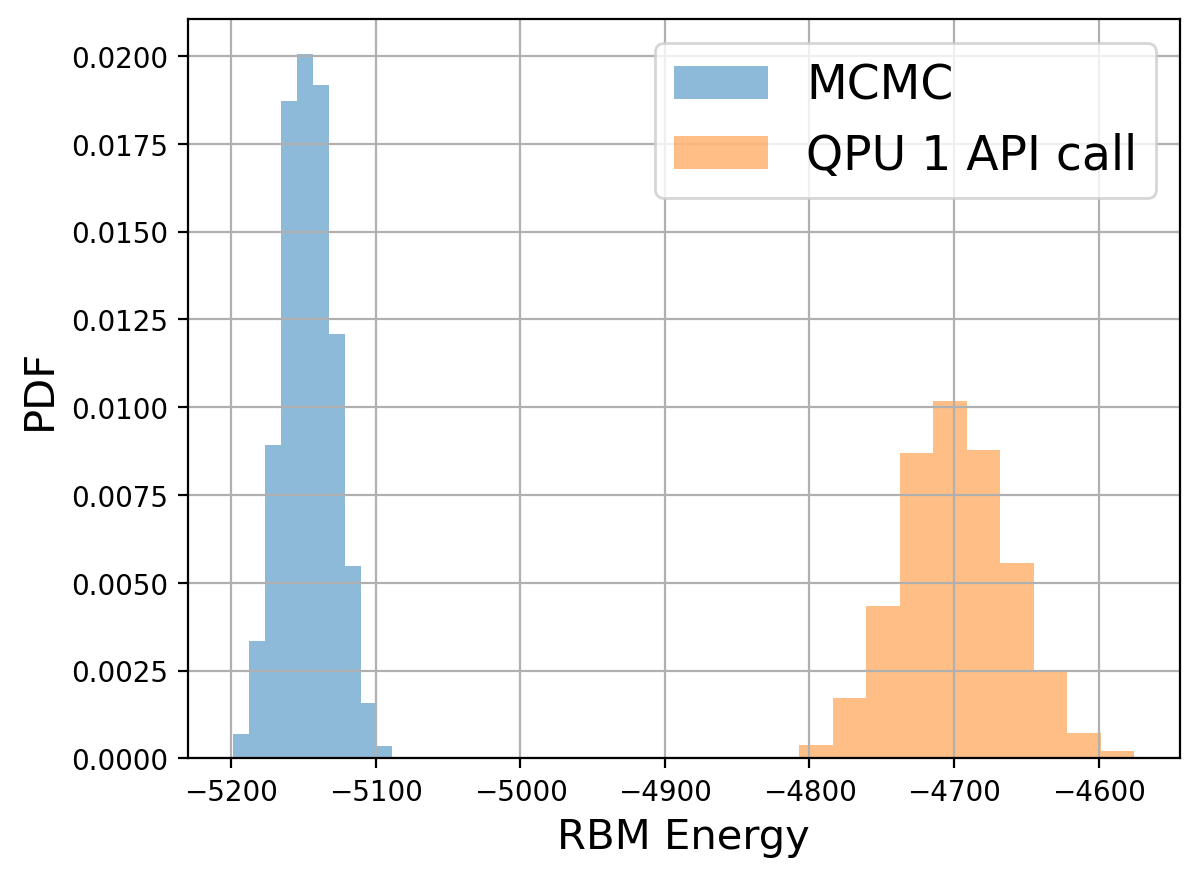

In [51]:
minVal, maxVal = min(energy_rbm.detach().cpu().numpy()), max(energy_rbm.detach().cpu().numpy())
binwidth = (maxVal-minVal)/10

# plt.hist(energy_dwave.detach().cpu(), bins=np.arange(minVal, maxVal + binwidth, binwidth), density=True)
plt.hist(energy_rbm.detach().cpu(), alpha=0.5, density=True, bins=np.arange(minVal, maxVal + binwidth, binwidth), label="MCMC")
plt.hist(energy_dwave_2.detach().cpu(), alpha=0.5, density=True, bins=10, label="QPU 1 API call")
# plt.hist(energy_dwave_3.detach().cpu(), alpha=0.5, density=True, bins=10, label="QPU n API calls")
plt.xlabel("RBM Energy", fontsize=15)
plt.ylabel("PDF", fontsize=15)
plt.grid(True)
plt.legend(fontsize=17)
# plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/DWAVE/Comparison_MC_QPU1_QPUN_nbeta.png')
plt.show()
# print(rbm_data.shape, energy_rbm_data.detach().cpu().mean() - energy_dwave.detach().cpu().mean(),
#      energy_rbm_data.shape, energy_dwave.shape, Hoffset)

In [49]:
import time

# time.sleep(2.5)

In [274]:
response_list = []
beta_list_2 = []
for i in range(1000):
    if i%100 == 0:
        print(i)
    # time.sleep(2.5)
    beta, beta_list, rbm_energy_list, dwave_energy_list, thrsh_met = engine.model.find_beta(num_reads=128, beta_init=4.29, lr=0.01, num_epochs = 30, delta = 4.0, method = 2, TOL=True, const = 1.0, adaptive = True)
    beta0 = beta
    beta_list_2.append(beta0)
    h, J, qubit_idxs, idx_dict, dwave_weights, dwave_bias = engine.model.ising_model(1/beta0)
    response_list.append( engine.model._qpu_sampler.sample_ising(h, J, num_reads=1, answer_mode='raw', auto_scale=False, programming_thermalization=10000, label=f'sampling 1 it: {i}'))
    

0


[17:45:16.881] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29
[17:45:19.417] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 4.798223761440945
[17:45:22.010] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 2: beta = 4.720245230468346
[17:45:24.257] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 3: beta = 4.6939407132471835
[17:45:26.394] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 4: beta = 4.610771422452054
[17:45:30.645] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29
[17:45:32.139] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 4.681209086280895
[17:45:33.690] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 2: beta = 4.550333354215951
[17:45:35.023] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 3: beta = 4.48882467096609
[17:45:36.353] INFO   models.autoencoders.AtlasConditionalQVAE          

100


[17:57:09.798] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29
[17:57:11.125] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 4.387597143239998
[17:57:14.877] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29
[17:57:16.285] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 4.381080911347451
[17:57:17.609] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 2: beta = 4.333567166161181
[17:57:21.293] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29
[17:57:22.610] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 4.335456734443255
[17:57:23.996] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 2: beta = 4.360111164403994
[17:57:27.707] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29
[17:57:29.035] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 4.38379067

200


[18:10:40.603] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29
[18:10:41.980] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 4.372526065425016
[18:10:45.837] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29
[18:10:47.165] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 4.371454234000052
[18:10:51.061] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29
[18:10:52.370] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 4.494070129963436
[18:10:53.701] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 2: beta = 4.444542094537998
[18:10:55.128] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 3: beta = 4.366493372907427
[18:10:59.302] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29
[18:11:00.634] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 4.44574663

300


[18:23:06.447] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29
[18:23:07.851] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 4.394505926598769
[18:23:09.194] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 2: beta = 4.360691713454277
[18:23:13.257] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29
[18:23:14.556] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 4.374610042278596
[18:23:15.899] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 2: beta = 4.410118814573837
[18:23:17.227] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 3: beta = 4.35619792921214
[18:23:20.920] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29
[18:23:22.264] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 4.389912555871406
[18:23:23.599] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 2: beta 

400


[18:35:33.335] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29
[18:35:34.655] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 4.36900418617786
[18:35:35.990] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 2: beta = 4.3468885211938275
[18:35:37.306] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 3: beta = 4.372524307955138
[18:35:41.383] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29
[18:35:42.675] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 4.392328433276962
[18:35:46.422] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29
[18:35:47.716] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 4.357698736861473
[18:35:51.580] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29
[18:35:52.875] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 4.37714036

500


[18:46:58.549] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29
[18:46:59.872] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 4.354396983967001
[18:47:01.300] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 2: beta = 4.3766132705545076
[18:47:05.589] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29
[18:47:06.959] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 4.409036278578283
[18:47:08.302] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 2: beta = 4.3873981873082855
[18:47:09.605] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 3: beta = 4.364544362942331
[18:47:13.415] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29
[18:47:14.743] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 4.343530381341402
[18:47:18.693] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: be

600


[18:58:35.499] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29
[18:58:36.832] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 4.348309522607138
[18:58:40.897] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29
[18:58:42.176] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 4.393017789909355
[18:58:43.587] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 2: beta = 4.365564526466682
[18:58:44.913] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 3: beta = 4.335292808059216
[18:58:46.187] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 4: beta = 4.314594960007999
[18:58:49.862] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29
[18:58:51.165] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 4.3408738598988466
[18:58:52.462] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 2: bet

700


[19:11:12.641] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29
[19:11:13.941] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 4.359963361571981
[19:11:17.666] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29
[19:11:19.004] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 4.3507157610667635
[19:11:20.311] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 2: beta = 4.381192461649013
[19:11:21.643] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 3: beta = 4.345807474743374
[19:11:22.955] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 4: beta = 4.297548266308879
[19:11:26.734] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29
[19:11:28.202] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 4.326621497975968
[19:11:29.499] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 2: bet

800


[19:23:23.300] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29
[19:23:24.589] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 4.3376279520776215
[19:23:25.935] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 2: beta = 4.377791978521488
[19:23:29.790] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29
[19:23:31.121] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 4.374022769303032
[19:23:32.390] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 2: beta = 4.028533773272883
[19:23:33.710] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 3: beta = 3.86958560401362
[19:23:35.007] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 4: beta = 3.73719652413537
[19:23:36.305] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 5: beta = 3.7145646161018764
[19:23:37.631] INFO   models.autoencoders.AtlasConditionalQVAE          

900


[19:36:10.080] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29
[19:36:11.411] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 4.376075365947904
[19:36:12.890] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 2: beta = 4.304848829267059
[19:36:16.575] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29
[19:36:17.898] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 4.398614940671109
[19:36:19.224] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 2: beta = 4.353921814915707
[19:36:20.803] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 3: beta = 4.327525511242537
[19:36:22.200] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 4: beta = 4.3646840367760795
[19:36:23.537] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 5: beta = 4.337644776861871
[19:36:27.275] INFO   models.autoencoders.AtlasConditionalQVAE         

In [275]:
response_array = np.concatenate([response_list[i].record["sample"] for i in range(len(response_list))])

In [276]:
dwave_samples, dwave_energies, origSamples = engine.model.batch_dwave_samples(response_array, qubit_idxs)

dwave_samples = torch.tensor(dwave_samples, dtype=torch.float)
        
_ZERO = torch.tensor(0., dtype=torch.float)
_MINUS_ONE = torch.tensor(-1., dtype=torch.float)

dwave_samples = torch.where(dwave_samples == _MINUS_ONE, _ZERO, dwave_samples)

dwave_samples = dwave_samples.to(dev)

energy_dwave_3 = engine.model.stater.energy_samples(dwave_samples[:,0:512], dwave_samples[:,512:1024], 
                                                  dwave_samples[:,1024:1536], dwave_samples[:,1536:2048], 1.0)


In [72]:
# self = engine.model
num_reads = 128

In [80]:
u = (self.encoder.binary_energy(true_energy).to(dtype=torch.float32)[0,:]).unsqueeze(0).repeat(num_reads,1)

In [81]:
u
# true_energy.shape

tensor([[1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.]], device='cuda:4')

In [ ]:
engine.model.prior_samples_qpu = engine.model.prior_samples_qpu[-500:,:]
engine.model.prior_samples = engine.model.prior_samples[-500:,:]

In [93]:
# print(engine.model.prior_samples_qpu.shape)
print(engine.model.prior_samples.shape)

torch.Size([1024, 2048])


In [45]:
print(True * True)
(engine.model.prior_samples_qpu[:,:512] == engine.model.prior_samples[:,:512]).prod()

1


TypeError: list indices must be integers or slices, not tuple

In [38]:

# energy_dwave = engine.model.stater.energy_samples(engine.model.prior_samples_qpu[:,0:512], engine.model.prior_samples_qpu[:,512:1024], 
#                                                   engine.model.prior_samples_qpu[:,1024:1536], engine.model.prior_samples_qpu[:,1536:2048], 1.0)

energy_rbm_ = engine.model.stater.energy_samples(engine.model.prior_samples[:,0:512], engine.model.prior_samples[:,512:1024], 
                                                  engine.model.prior_samples[:,1024:1536], engine.model.prior_samples[:,1536:2048], 1.0)

# energy_dwave.shape

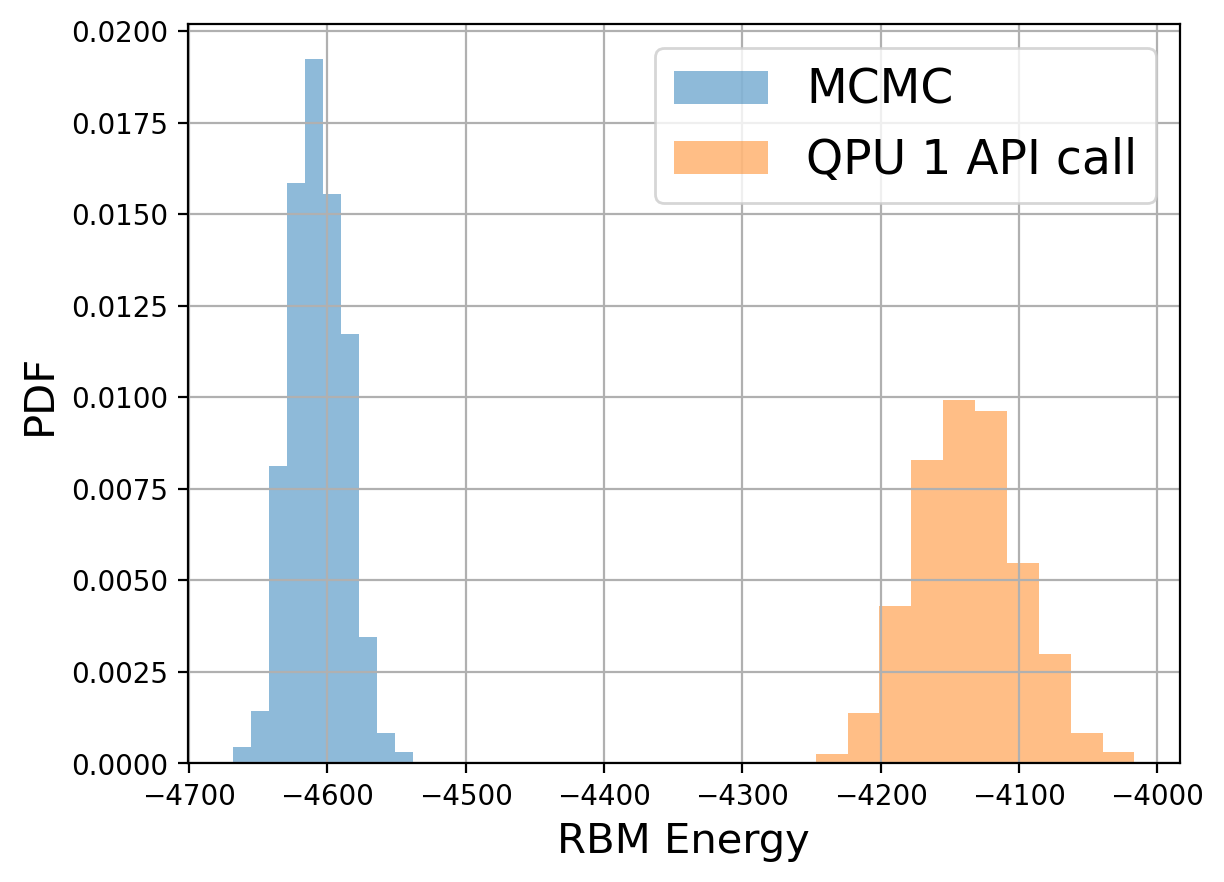

In [39]:
minVal, maxVal = min(energy_rbm_.detach().cpu().numpy()), max(energy_rbm_.detach().cpu().numpy())
binwidth = (maxVal-minVal)/10

# plt.hist(energy_dwave.detach().cpu(), bins=np.arange(minVal, maxVal + binwidth, binwidth), density=True)
plt.hist(energy_rbm_.detach().cpu(), alpha=0.5, density=True, bins=np.arange(minVal, maxVal + binwidth, binwidth), label="MCMC")
plt.hist(energy_dwave_2.detach().cpu(), alpha=0.5, density=True, bins=10, label="QPU 1 API call")
# plt.hist(energy_dwave_3.detach().cpu(), alpha=0.5, density=True, bins=10, label="QPU n API calls")
plt.xlabel("RBM Energy", fontsize=15)
plt.ylabel("PDF", fontsize=15)
plt.grid(True)
plt.legend(fontsize=17)
# plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/DWAVE/Comparison_MC_QPU1_QPUN_nbeta.png')
plt.show()
# print(rbm_data.shape, energy_rbm_data.detach().cpu().mean() - energy_dwave.detach().cpu().mean(),
#      energy_rbm_data.shape, energy_dwave.shape, Hoffset)

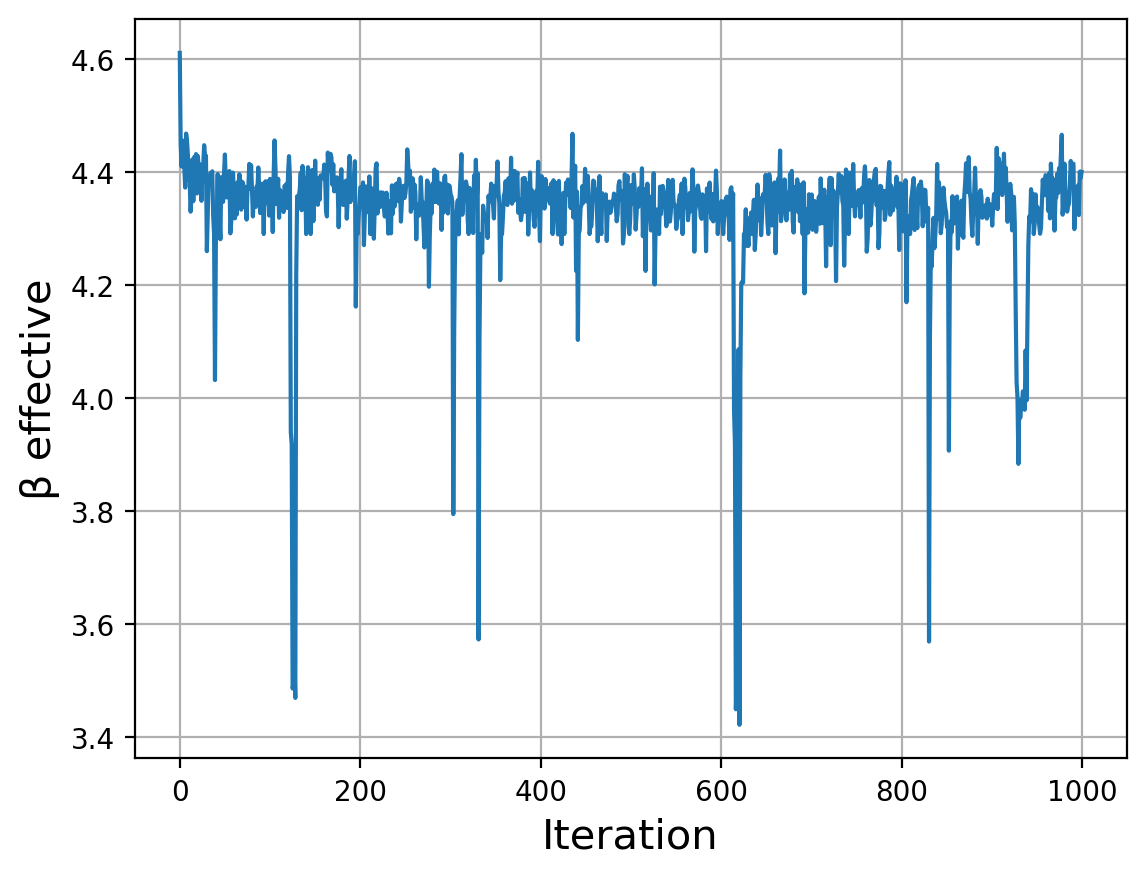

In [283]:
plt.plot(beta_list_2)
# plt.scatter(range(100), beta_list_2)
plt.grid("True")
plt.xlabel("Iteration", fontsize=15)
plt.ylabel("β effective", fontsize=15)
plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/DWAVE/beta_eff_Comparison_MC_QPU1_QPUN_nbeta.png')
plt.show()

In [286]:
np.savez(f'/home/javier/Projects/CaloQVAE/figs/DWAVE/Exp1_data.npz', rbm=energy_rbm_.detach().cpu().numpy(), qpu1=energy_dwave_2.detach().cpu().numpy(), 
         qpun = energy_dwave_3.detach().cpu().numpy(), beta=np.array(beta_list_2))

In [109]:
########################################################################################

In [78]:
beta0

4.256643711657938

In [77]:
#######################################
def classical_RBM(en_list = [10000], cond=True):  
    engine.model.prior_samples = []
    true_energy = torch.tensor(en_list).repeat(1024,1).to(dev)
    if cond:
        sample_energies, sample_data = engine._model.generate_samples_cond(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True)
    else:
        sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True)
    # print(engine.model.prior_samples.shape)
    energy_rbm_ = engine.model.stater.energy_samples(engine.model.prior_samples[:,0:512], engine.model.prior_samples[:,512:1024], 
                                                  engine.model.prior_samples[:,1024:1536], engine.model.prior_samples[:,1536:2048], 1.0)
    return energy_rbm_, engine.model.prior_samples[:,0:512]


def quantum_RBM(en_list = [10000], num_reads=2000, thrsh=20, cond=True, est_beta=False, i=0,iterator=1):
    global beta0
    if est_beta and i<iterator:
        # beta, beta_list, rbm_energy_list, dwave_energy_list, thrsh_met = engine.model.find_beta(num_reads=1000, beta_init=4.29, lr=0.01, num_epochs = 30, delta = 4.0, method = 2, TOL=True, const = 1.0, adaptive = True)
        beta, beta_list, rbm_energy_list, dwave_energy_list, thrsh_met = engine.model.find_beta_cond(en_list, dev, thrsh=thrsh, num_reads=1000, beta_init=4.29, lr=0.01, num_epochs = 30, delta = 4.0, method = 2, TOL=True, const = 1.0, adaptive = True)
        beta0 = beta
    h, J, qubit_idxs, idx_dict, dwave_weights, dwave_bias = engine.model.ising_model(1/beta0)
    response_list = []

    true_energy = torch.tensor(en_list).repeat(1024,1).to(dev)
    u = engine.model.encoder.binary_energy(true_energy).to(dtype=torch.float32)
    x = next(iter(true_energy))
    # fb = engine.model.gen_fb(1.0/beta0, x, thrsh=thrsh, cond=engine._config.qpu.cond, TOL=engine._config.qpu.tol)
    fb = engine.model.gen_fb(1.0/beta0, x, thrsh=thrsh, TOL=engine._config.qpu.tol)

    if cond:
        response_list.append( engine.model._qpu_sampler.sample_ising(h, J, num_reads=num_reads, answer_mode='raw', auto_scale=False, flux_drift_compensation=False, flux_biases=fb, label=f'Gen {num_reads} cond samples'))
    else:
        response_list.append( engine.model._qpu_sampler.sample_ising(h, J, num_reads=num_reads, answer_mode='raw', auto_scale=False, label=f'Gen {num_reads} samples'))
    response_array = response_list[0].record["sample"]
    dwave_samples, dwave_energies, origSamples = engine.model.batch_dwave_samples(response_array, qubit_idxs)

    dwave_samples = torch.tensor(dwave_samples, dtype=torch.float)

    _ZERO = torch.tensor(0., dtype=torch.float)
    _MINUS_ONE = torch.tensor(-1., dtype=torch.float)

    dwave_samples = torch.where(dwave_samples == _MINUS_ONE, _ZERO, dwave_samples)

    dwave_samples = dwave_samples.to(dev)

    energy_dwave_2 = engine.model.stater.energy_samples(dwave_samples[:,0:512], dwave_samples[:,512:1024], 
                                                      dwave_samples[:,1024:1536], dwave_samples[:,1536:2048], 1.0)
    if cond != True or (u[0,:].repeat(dwave_samples.shape[0],1) == dwave_samples[:,0:512]).prod() == 1:
        pass
    else:
        print(f'QPU encoding energy partition is not equal to the encoded energy for energy={en_list}')
    return energy_dwave_2, dwave_samples #[:,0:512]


def find_the_energy_idx(en_label, true_energy):
    # idx = (torch.isclose(true_energy, torch.tensor([en_label]).to(dev), atol=en_label/10)).nonzero(as_tuple=True)[0].detach().cpu()[0].item()
    idx = (true_energy - torch.tensor([en_label_]).to(dev)).abs().argmin().detach().cpu().item()
    # print(idx)
    return idx

def approx_post(true_energy, in_data, en_list = 10000.):
    partition_size=config.model.n_latent_nodes_per_p
    idx = find_the_energy_idx(en_list, true_energy)
    inc_en = true_energy[idx,0].repeat(1024,1)
    shower = in_data[idx,:].repeat(1024,1)
    engine.model.eval()
    with torch.no_grad():
        if reducedata:
            shower = engine._reduce(shower, inc_en, R=R)

        beta, post_logits, post_samples = engine.model.encoder(shower, inc_en, False)
        post_samples = torch.cat(post_samples, 1)
        post_samples_energy = engine.model.stater.energy_samples(post_samples[:,0:partition_size], post_samples[:,partition_size:2*partition_size], 
                                                 post_samples[:,2*partition_size:3*partition_size], post_samples[:,3*partition_size:4*partition_size], 1.0 )
    return post_samples_energy, post_samples[:,0:partition_size]



In [67]:
con = True
thrsh = 20

torch.Size([1024, 2048])
torch.Size([1024, 2048])
torch.Size([1024, 2048])
torch.Size([1024, 2048])
torch.Size([1024, 2048])


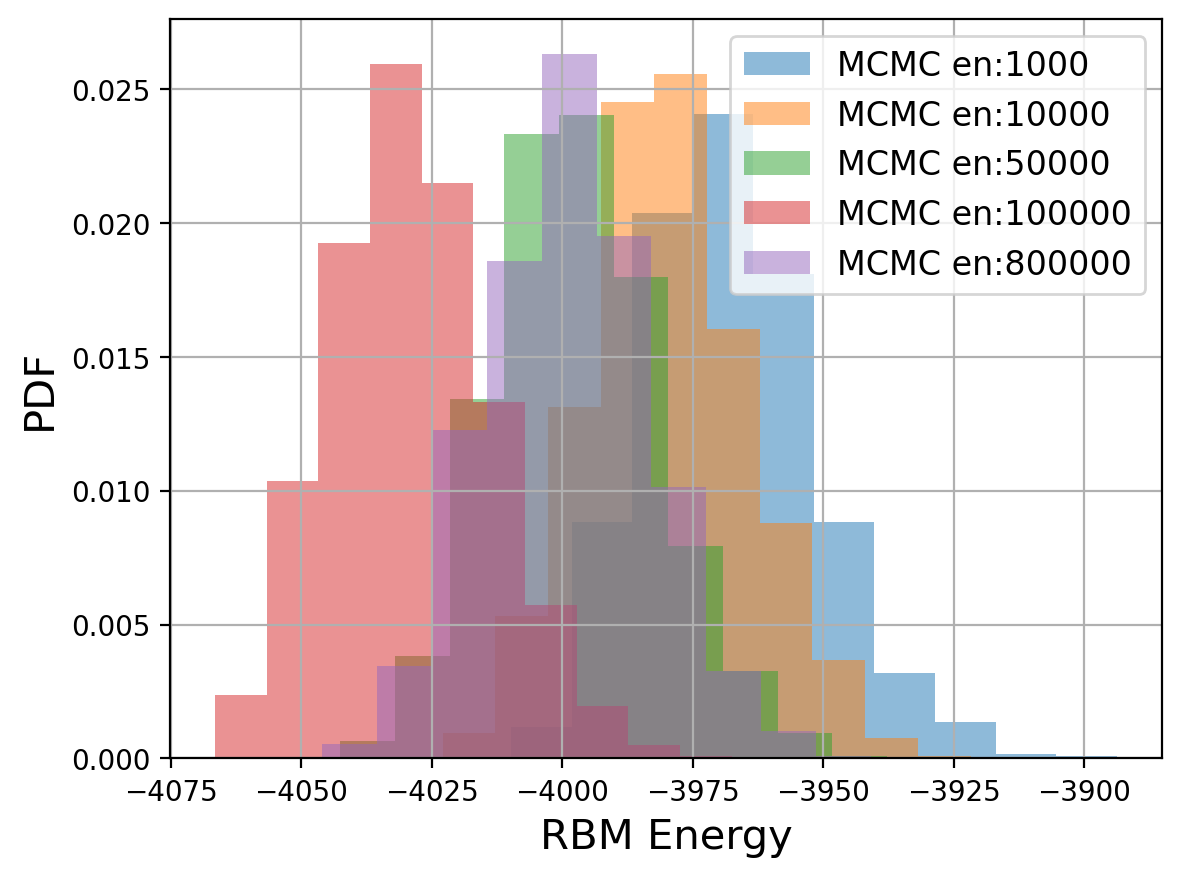

In [290]:
for i,en_label in enumerate([1000,10000,50000,100000,800000]):
    energy_rbm_, enc_energy = classical_RBM([en_label], cond=con)
    if i == 0:
        minVal, maxVal = min(energy_rbm_.detach().cpu().numpy()), max(energy_rbm_.detach().cpu().numpy())
        binwidth = (maxVal-minVal)/10

    plt.hist(energy_rbm_.detach().cpu(), alpha=0.5, density=True, bins=10, label=f'MCMC en:{en_label}') #np.arange(minVal, maxVal + binwidth, binwidth)
    # plt.hist(energy_dwave_2.detach().cpu(), alpha=0.5, density=True, bins=10, label="QPU 1 API call")
plt.xlabel("RBM Energy", fontsize=15)
plt.ylabel("PDF", fontsize=15)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()

In [291]:
beta, beta_list, rbm_energy_list, dwave_energy_list, thrsh_met = engine.model.find_beta(num_reads=128, beta_init=4.29, lr=0.01, num_epochs = 30, delta = 4.0, method = 2, TOL=True, const = 1.0, adaptive = True)
beta0 = beta

[22:19:24.490] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29
[22:19:26.728] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 4.744893489060606
[22:19:28.968] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 2: beta = 4.782296812323547
[22:19:31.216] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 3: beta = 4.723072879076962
[22:19:33.408] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 4: beta = 4.645880209737291
[22:19:34.978] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 5: beta = 4.610399016550431
[22:19:36.287] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 6: beta = 4.561262125201694
[22:19:37.596] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 7: beta = 4.513016398758396
[22:19:38.977] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 8: beta = 4.468284173435363
[22:19:40.328] INFO   models.autoencoders.AtlasConditionalQ

QPU encoding energy partition is not equal to the encoded energy for energy=[1000]
QPU encoding energy partition is not equal to the encoded energy for energy=[10000]
QPU encoding energy partition is not equal to the encoded energy for energy=[50000]
QPU encoding energy partition is not equal to the encoded energy for energy=[100000]
QPU encoding energy partition is not equal to the encoded energy for energy=[800000]


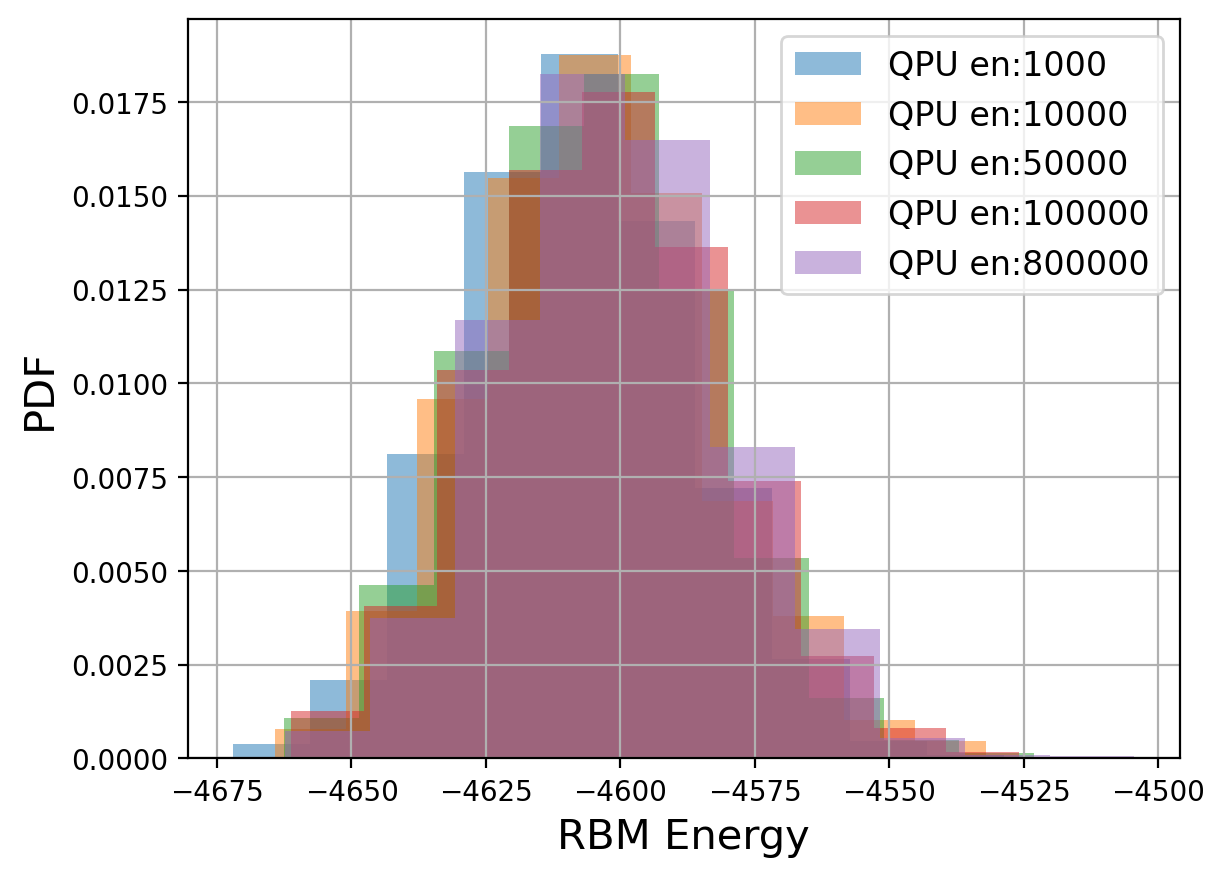

In [292]:
for i,en_label in enumerate([1000,10000,50000,100000,800000]):
    energy_dwave_2, enc_energy = quantum_RBM([en_label], cond=con, thrsh=thrsh)
    # if i == 0:
    #     minVal, maxVal = min(energy_rbm_.detach().cpu().numpy()), max(energy_rbm_.detach().cpu().numpy())
    #     binwidth = (maxVal-minVal)/10

    # plt.hist(energy_rbm_.detach().cpu(), alpha=0.5, density=True, bins=10, label=f'MCMC en:{en_label}') #np.arange(minVal, maxVal + binwidth, binwidth)
    plt.hist(energy_dwave_2.detach().cpu(), alpha=0.5, density=True, bins=10, label=f'QPU en:{en_label}')
plt.xlabel("RBM Energy", fontsize=15)
plt.ylabel("PDF", fontsize=15)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()

0


[19:51:58.977] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29
[19:52:01.845] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 4.239265692067296
[19:52:04.658] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 2: beta = 4.208865477073354
[19:52:07.632] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 3: beta = 4.167306823127776
[19:52:10.631] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 4: beta = 4.22056355836432
[19:52:12.606] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 5: beta = 4.234885785843518
[19:52:14.671] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 6: beta = 4.245604180314323
[19:52:16.756] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 7: beta = 4.179688057279468
[19:52:18.902] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 8: beta = 4.161912167250123
[19:52:21.075] INFO   models.autoencoders.AtlasConditionalQV

1


[19:52:31.078] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29
[19:52:33.361] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 4.273154400238836
[19:52:35.471] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 2: beta = 4.211744014114221
[19:52:37.607] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 3: beta = 4.151834472062372
[19:52:39.721] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 4: beta = 4.171043913289199
[19:52:41.707] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 5: beta = 4.109366680344305
[19:52:43.789] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 6: beta = 4.126284671223283
[19:52:45.837] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 7: beta = 4.0177976067466545
[19:52:47.832] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 8: beta = 4.08592890863232
[19:52:49.779] INFO   models.autoencoders.AtlasConditionalQ

2


[19:52:57.158] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29
[19:52:59.077] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 4.211194489173226
[19:53:01.016] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 2: beta = 4.191877311386571
[19:53:02.952] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 3: beta = 4.171980592878458
[19:53:04.962] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 4: beta = 4.209449595576702


3


[19:53:12.622] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29
[19:53:14.586] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 4.250601844597518
[19:53:16.867] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 2: beta = 4.21528689273275


4


[19:53:24.554] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29
[19:53:26.484] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 4.222309886474909
[19:53:28.522] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 2: beta = 4.212532491673682


5


[19:53:35.878] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29
[19:53:38.078] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 4.218901347429328
[19:53:40.243] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 2: beta = 4.136918698528452
[19:53:42.191] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 3: beta = 4.1711149856329826
[19:53:44.145] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 4: beta = 4.104493519956081
[19:53:46.108] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 5: beta = 4.147439605404369


6


[19:53:53.779] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29
[19:53:55.738] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 4.240570410876766
[19:53:57.671] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 2: beta = 4.217023207709938


7


[19:54:05.125] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29
[19:54:07.354] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 4.299359022035751
[19:54:09.329] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 2: beta = 4.242691440543351
[19:54:11.286] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 3: beta = 4.145097748983233
[19:54:13.273] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 4: beta = 4.163666034706397


8


[19:54:21.329] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29
[19:54:23.248] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 4.156562512386972
[19:54:25.446] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 2: beta = 4.179462409640521
[19:54:27.390] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 3: beta = 4.115943419803836
[19:54:29.501] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 4: beta = 4.12629751415233
[19:54:31.654] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 5: beta = 4.086266751138588
[19:54:33.594] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 6: beta = 4.133077479177755
[19:54:35.521] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 7: beta = 4.149869171786782
[19:54:37.460] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 8: beta = 4.170531613033835
[19:54:39.410] INFO   models.autoencoders.AtlasConditionalQV

9


[19:54:47.060] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29


10


[19:54:54.663] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29
[19:54:56.939] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 4.197803630270653


11


[19:55:04.756] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29
[19:55:06.705] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 4.2042223425144325


12


[19:55:14.059] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29
[19:55:16.068] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 4.1952121280479995
[19:55:18.049] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 2: beta = 4.061881168477258
[19:55:19.990] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 3: beta = 4.106949786983242
[19:55:21.955] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 4: beta = 4.163243220297215


13


[19:55:29.295] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29
[19:55:31.281] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 4.205988643923275
[19:55:33.476] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 2: beta = 4.114679784975817
[19:55:35.428] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 3: beta = 4.164238086980799
[19:55:37.399] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 4: beta = 4.175236686168781
[19:55:39.351] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 5: beta = 4.162909781282387
[19:55:41.335] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 6: beta = 4.201822560651266
[19:55:43.466] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 7: beta = 4.030537410665774
[19:55:45.703] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 8: beta = 4.106321832543185
[19:55:47.675] INFO   models.autoencoders.AtlasConditionalQ

14


[19:56:11.575] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29
[19:56:13.538] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 4.263056284995177
[19:56:15.531] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 2: beta = 4.272235972917419
[19:56:17.518] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 3: beta = 4.168106715221614
[19:56:19.518] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 4: beta = 4.19345687846758


15


[19:56:26.937] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29
[19:56:28.936] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 4.30038042437073
[19:56:30.953] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 2: beta = 4.208481895267016
[19:56:32.930] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 3: beta = 4.241631996775207
[19:56:34.914] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 4: beta = 4.19775576782277
[19:56:37.085] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 5: beta = 4.139855233797409
[19:56:39.243] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 6: beta = 4.128604010295681
[19:56:41.230] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 7: beta = 4.169719709800988
[19:56:43.433] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 8: beta = 4.149231778989331
[19:56:45.371] INFO   models.autoencoders.AtlasConditionalQVA

16


[19:56:52.973] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29
[19:56:54.935] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 4.264546027666075
[19:56:56.966] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 2: beta = 4.17216104580812
[19:56:58.943] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 3: beta = 4.111997464774374
[19:57:00.906] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 4: beta = 4.089987013121941
[19:57:02.901] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 5: beta = 4.152368539043338
[19:57:04.864] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 6: beta = 4.121810287724718
[19:57:07.093] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 7: beta = 4.1614279446695095
[19:57:09.217] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 8: beta = 4.174779564330285
[19:57:11.186] INFO   models.autoencoders.AtlasConditionalQ

17


[19:57:21.284] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29
[19:57:23.252] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 4.237997246633497
[19:57:25.210] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 2: beta = 4.152456657116424
[19:57:27.180] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 3: beta = 4.183986434612696
[19:57:29.151] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 4: beta = 4.217149861150183
[19:57:31.337] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 5: beta = 4.114071180247703
[19:57:33.262] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 6: beta = 4.077140245838195
[19:57:35.203] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 7: beta = 4.134505909449443
[19:57:37.170] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 8: beta = 4.105526535096414
[19:57:39.155] INFO   models.autoencoders.AtlasConditionalQ

18


[19:57:54.657] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29


19


[19:58:02.017] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29
[19:58:03.960] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 4.222632717807117


20


[19:58:11.363] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29
[19:58:13.574] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 4.349296356632304
[19:58:15.575] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 2: beta = 4.259441833609562
[19:58:17.516] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 3: beta = 4.278166205672313
[19:58:19.493] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 4: beta = 4.259577102853365
[19:58:21.738] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 5: beta = 4.249718761759073
[19:58:23.730] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 6: beta = 4.270121938631757


21


[19:58:31.450] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29
[19:58:33.616] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 4.266430450668297
[19:58:35.602] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 2: beta = 4.180830154229882
[19:58:37.556] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 3: beta = 4.200464411622804
[19:58:39.861] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 4: beta = 4.2311978926113465
[19:58:41.821] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 5: beta = 4.176270578351201


22


[19:58:49.183] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29
[19:58:51.139] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 4.2424386720019855
[19:58:53.111] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 2: beta = 4.174025791032148
[19:58:55.082] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 3: beta = 4.163636361162537
[19:58:57.042] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 4: beta = 4.183389883419424
[19:58:59.017] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 5: beta = 4.2005674728135665
[19:59:01.090] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 6: beta = 4.217056192590993
[19:59:03.059] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 7: beta = 4.202760235037671
[19:59:05.012] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 8: beta = 4.1699508036291135
[19:59:07.002] INFO   models.autoencoders.AtlasCondition

23


[19:59:20.205] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29
[19:59:22.165] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 4.31597098039684
[19:59:24.164] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 2: beta = 4.287212196363565
[19:59:26.092] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 3: beta = 4.252499814947235
[19:59:28.068] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 4: beta = 4.204538357139834
[19:59:30.040] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 5: beta = 4.194298691033505
[19:59:32.020] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 6: beta = 4.166412425945088
[19:59:33.962] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 7: beta = 4.175184731352877
[19:59:35.932] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 8: beta = 4.142464779435353
[19:59:38.105] INFO   models.autoencoders.AtlasConditionalQV

24


[19:59:47.469] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29
[19:59:49.419] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 4.303047436879576
[19:59:51.411] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 2: beta = 4.211045601410606
[19:59:53.415] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 3: beta = 4.200456666210442


25


[20:00:00.805] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29
[20:00:02.800] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 4.278176219364562
[20:00:04.993] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 2: beta = 4.2553396329267255
[20:00:07.215] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 3: beta = 4.187963965619661
[20:00:09.480] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 4: beta = 4.2070189296787035
[20:00:11.975] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 5: beta = 4.224402166192508
[20:00:13.992] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 6: beta = 4.052891128961836
[20:00:16.495] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 7: beta = 3.9475948286649785
[20:00:19.109] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 8: beta = 3.890087595217287
[20:00:21.441] INFO   models.autoencoders.AtlasCondition

26


[20:01:06.237] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29
[20:01:08.197] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 3.97866049003288
[20:01:10.191] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 2: beta = 3.9209550934687774
[20:01:12.099] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 3: beta = 3.9858240297005287
[20:01:14.593] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 4: beta = 3.935824556724317
[20:01:16.766] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 5: beta = 3.637043081182021
[20:01:19.277] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 6: beta = 3.484429101123463
[20:01:21.828] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 7: beta = 3.427795135389967
[20:01:24.696] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 8: beta = 3.4066195858473214
[20:01:27.172] INFO   models.autoencoders.AtlasConditiona

27


[20:01:38.109] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29
[20:01:40.055] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 4.0304772648004095
[20:01:42.000] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 2: beta = 3.9876602041085336
[20:01:44.239] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 3: beta = 4.016671831399232
[20:01:46.180] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 4: beta = 3.998622706399741
[20:01:48.173] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 5: beta = 3.591326663722831
[20:01:50.177] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 6: beta = 3.399143769502894
[20:01:52.230] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 7: beta = 3.470195456672218
[20:01:54.200] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 8: beta = 3.3548648336588265
[20:01:56.407] INFO   models.autoencoders.AtlasCondition

28


[20:02:14.201] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29
[20:02:16.152] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 3.821625346503289
[20:02:18.152] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 2: beta = 3.615787822274701
[20:02:20.367] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 3: beta = 3.7603635321046855
[20:02:22.357] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 4: beta = 3.378254295281094
[20:02:24.303] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 5: beta = 3.39682021801629
[20:02:26.471] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 6: beta = 3.7415595043309264
[20:02:28.415] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 7: beta = 3.8544692872980884
[20:02:30.382] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 8: beta = 3.8642931747414155
[20:02:32.573] INFO   models.autoencoders.AtlasCondition

29


[20:02:53.922] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29
[20:02:55.890] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 4.147317554077813
[20:02:57.860] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 2: beta = 4.134615666670182
[20:02:59.840] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 3: beta = 4.122559762150066
[20:03:01.833] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 4: beta = 4.142785582737031


30


[20:03:09.847] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29


31


[20:03:17.231] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29
[20:03:19.202] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 4.237020980899321
[20:03:21.190] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 2: beta = 4.063447263750844
[20:03:23.166] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 3: beta = 4.119040009390778
[20:03:25.322] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 4: beta = 4.141450860028984
[20:03:27.294] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 5: beta = 4.1632961970678135
[20:03:29.309] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 6: beta = 4.094161837611632
[20:03:31.318] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 7: beta = 4.134642076170217
[20:03:33.469] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 8: beta = 4.051291544226123
[20:03:35.652] INFO   models.autoencoders.AtlasConditional

32


[20:03:51.430] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29
[20:03:53.425] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 4.204500633517356
[20:03:55.375] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 2: beta = 4.180559589787855
[20:03:57.329] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 3: beta = 4.191062245821733


33


[20:04:05.313] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29
[20:04:07.305] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 4.307894214156328
[20:04:09.295] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 2: beta = 4.190204644429054


34


[20:04:17.193] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29
[20:04:19.229] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 4.236919410284161


35


[20:04:26.627] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29


36


[20:04:34.198] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29
[20:04:36.160] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 4.3160291544796126
[20:04:38.158] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 2: beta = 4.224351883912013
[20:04:40.381] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 3: beta = 4.2465773871859165


37


[20:04:48.055] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29
[20:04:50.014] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 4.347225027661069
[20:04:52.014] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 2: beta = 4.323881136894405
[20:04:53.994] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 3: beta = 4.266935304501324
[20:04:55.947] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 4: beta = 4.125228963087178
[20:04:57.913] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 5: beta = 4.112859734850419
[20:04:59.885] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 6: beta = 4.139487044331771
[20:05:01.884] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 7: beta = 4.17675065098493
[20:05:03.832] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 8: beta = 4.146373323639087
[20:05:05.783] INFO   models.autoencoders.AtlasConditionalQV

38


[20:05:17.623] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29
[20:05:19.585] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 4.326463147959779


39


[20:05:26.936] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 4.29
[20:05:28.900] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 4.247381002192611
[20:05:30.856] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 2: beta = 4.23068690754937


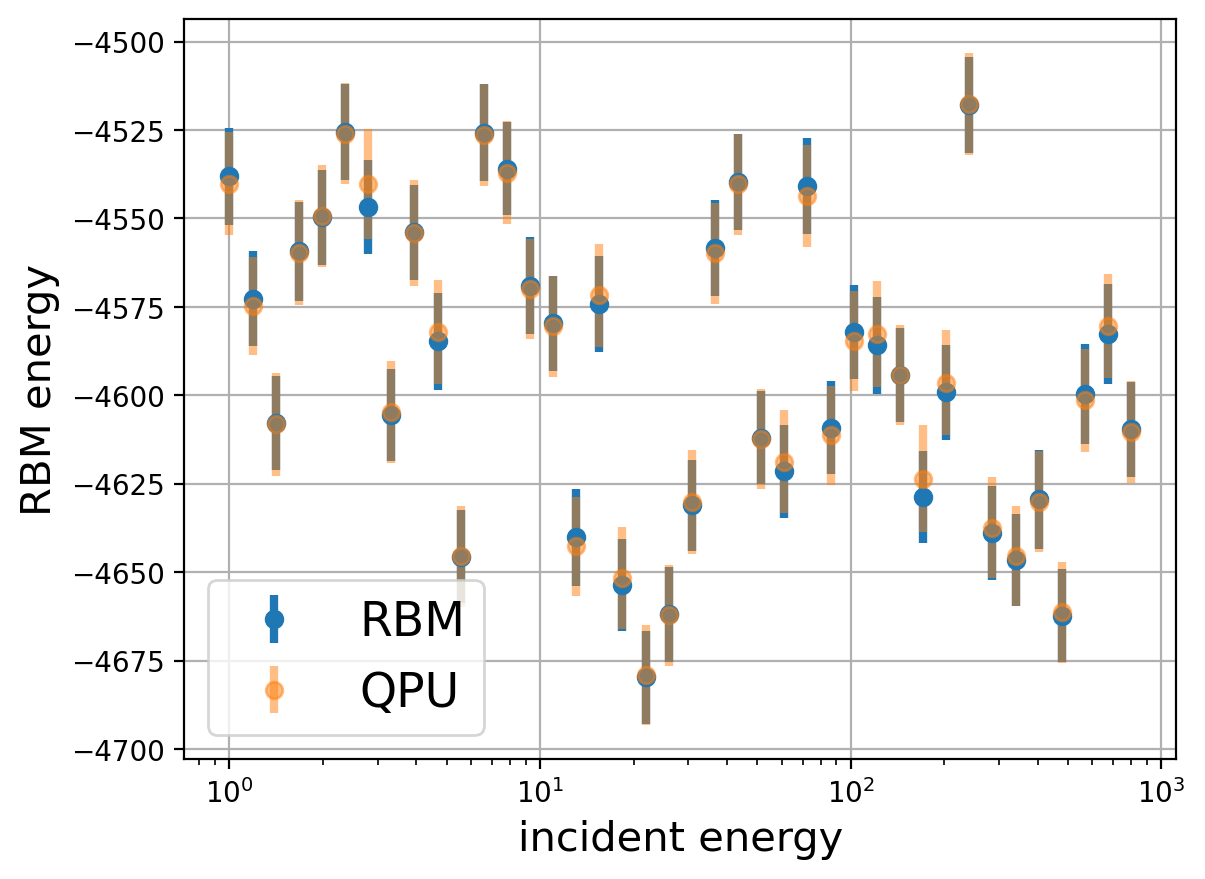

In [103]:
con = True
thrsh = 35
rbm_dict = {"en":[], "m":[], "s":[]}
qpu_dict = {"en":[], "m":[], "s":[]}
for i,en_label in enumerate(np.logspace(3.0, 5.903, num=40, dtype="float32")):
    print(i)
    energy_rbm_, enc_energy = classical_RBM([en_label], cond=con)
    energy_dwave_2, enc_energy = quantum_RBM([en_label], cond=con, thrsh=thrsh, est_beta=True, i=i, iterator=40)
    
    rbm_dict["en"].append(en_label/1000)
    rbm_dict["m"].append(energy_rbm_.mean().detach().cpu().item())
    rbm_dict["s"].append(energy_rbm_.std().detach().cpu().item())
    
    qpu_dict["en"].append(en_label/1000)
    qpu_dict["m"].append(energy_dwave_2.mean().detach().cpu().item())
    qpu_dict["s"].append(energy_dwave_2.std().detach().cpu().item())

plt.errorbar(rbm_dict["en"], rbm_dict["m"], yerr=rbm_dict["s"], fmt="o", label="RBM", lw=3)
plt.errorbar(qpu_dict["en"], qpu_dict["m"], yerr=qpu_dict["s"], fmt="o", label="QPU", lw=3, alpha=0.5)
plt.xlabel("incident energy", fontsize=15)
plt.ylabel("RBM energy", fontsize=15)
plt.grid(True)
plt.legend(fontsize=17)
plt.xscale("log")
plt.show()

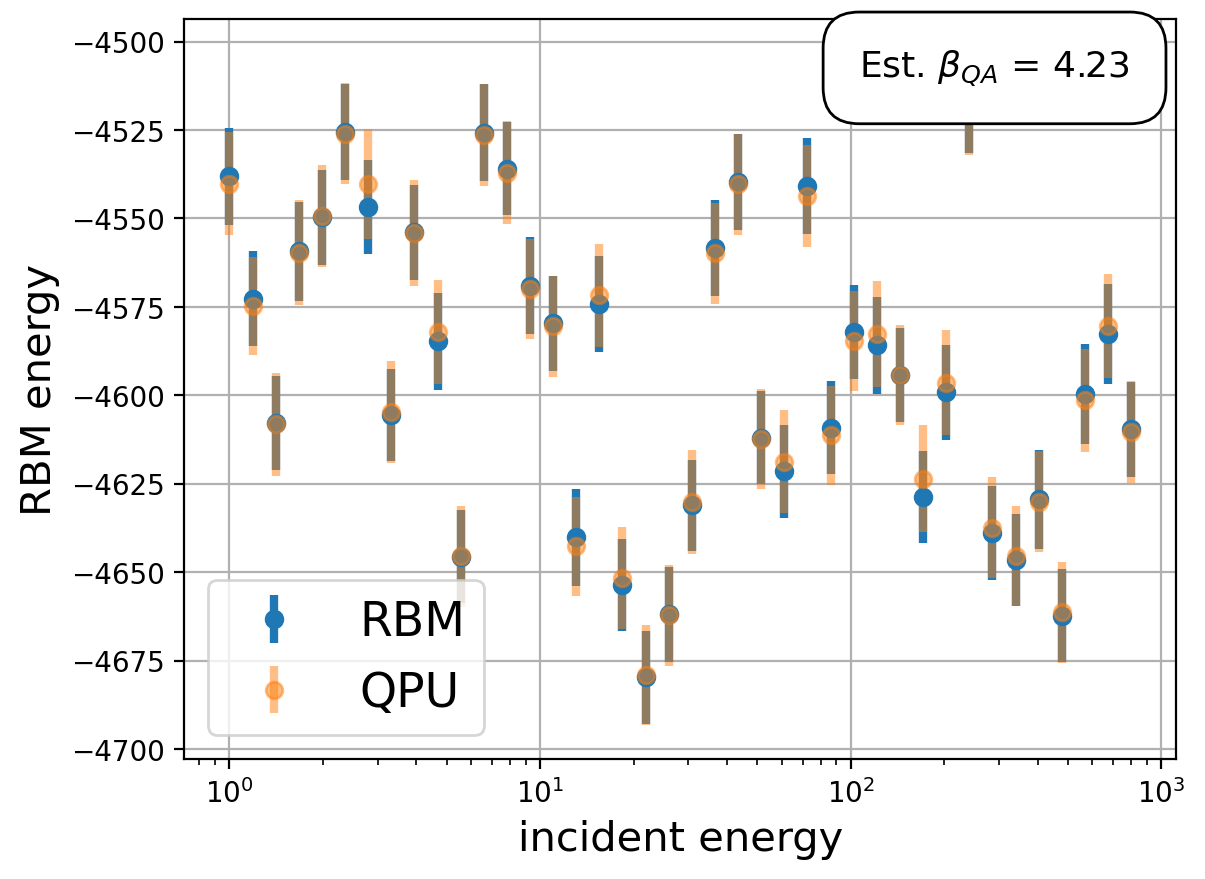

In [104]:
plt.errorbar(rbm_dict["en"], rbm_dict["m"], yerr=rbm_dict["s"], fmt="o", label="RBM", lw=3)
plt.errorbar(qpu_dict["en"], qpu_dict["m"], yerr=qpu_dict["s"], fmt="o", label="QPU", lw=3, alpha=0.5)
plt.xlabel("incident energy", fontsize=15)
plt.ylabel("RBM energy", fontsize=15)
plt.grid(True)
plt.legend(fontsize=17)
plt.xscale("log")
plt.figtext(0.758, 0.85, f'Est. {QA} = {np.round(beta0, 2)}', ha='center', va='top', fontsize=13, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1'))
plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/DWAVE/Comparison_MC_QPU_thrsh_{thrsh}_beta.png')
plt.show()

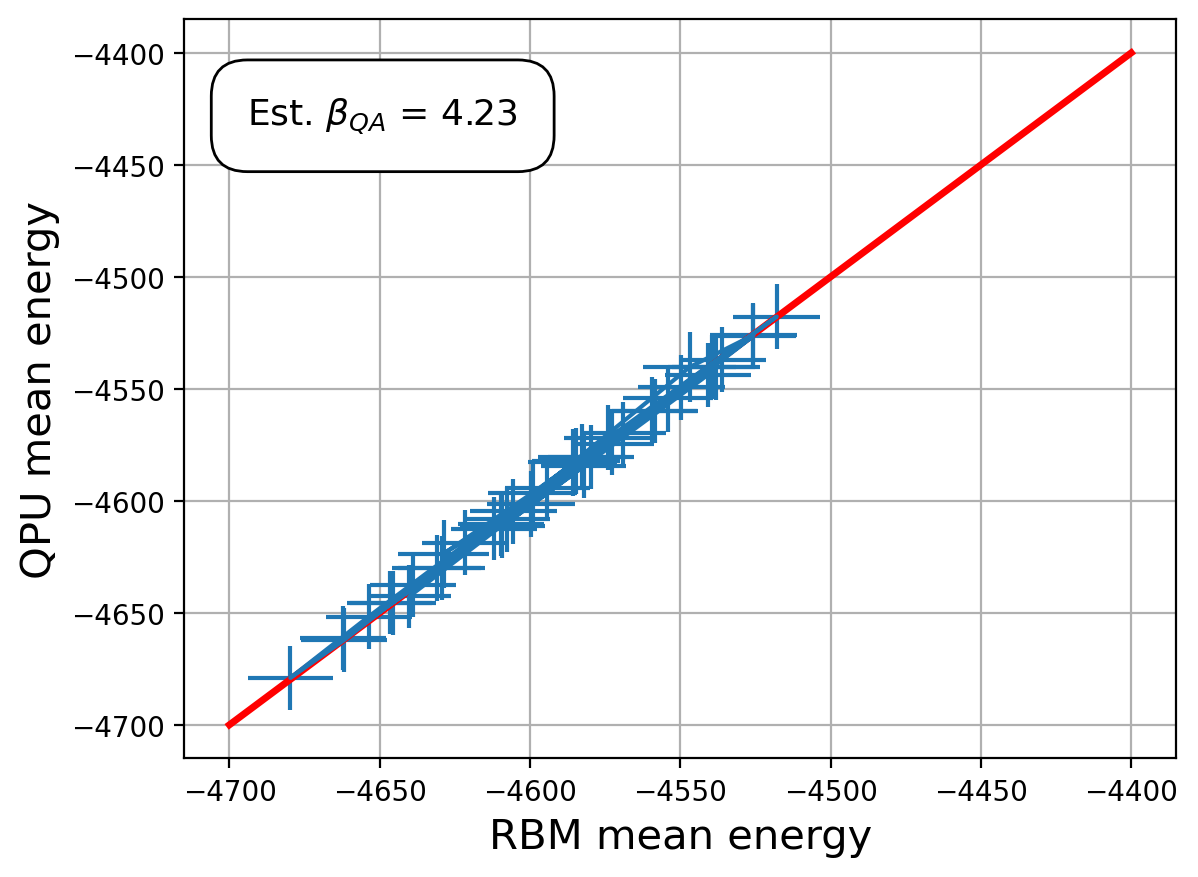

In [105]:
plt.errorbar(rbm_dict["m"], qpu_dict["m"], xerr=qpu_dict["s"], yerr=qpu_dict["s"])
plt.plot([-4700,-4400],[-4700,-4400], c='red', lw=2.5)
plt.xlabel('RBM mean energy', fontsize=15)
plt.ylabel('QPU mean energy', fontsize=15)
plt.grid(True)
plt.figtext(0.28, 0.8, f'Est. {QA} = {np.round(beta0, 2)}', ha='center', va='top', fontsize=13, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1'))
plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/DWAVE/scatter_plot_rbm_qpu_beta.png')

In [27]:
# print(train_loader.__dict__["dataset"].__dict__["_images"]["incident_energies"].__dict__["_image"][:10])
# print(val_loader.__dict__["dataset"].__dict__["_images"]["incident_energies"].__dict__["_image"][:10])

In [28]:
########## Comparison b.w. RBM,QPU and approx post
con = True
thrsh = 27.0

# xx = next(iter(val_loader))
# in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1])

xx = [val_loader.__dict__["dataset"].__dict__["_images"]["showers"].__dict__["_image"]], [val_loader.__dict__["dataset"].__dict__["_images"]["incident_energies"].__dict__["_image"]]
in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1])

In [76]:
# import numpy as np
data_en = []
loop_en = []
for i,en_label_ in enumerate(np.logspace(3.0, 6.007, num=500, dtype="float32")):
    idx = find_the_energy_idx(en_label_, true_energy)
    data_en.append(true_energy[idx].detach().cpu().item())
    loop_en.append(en_label_)

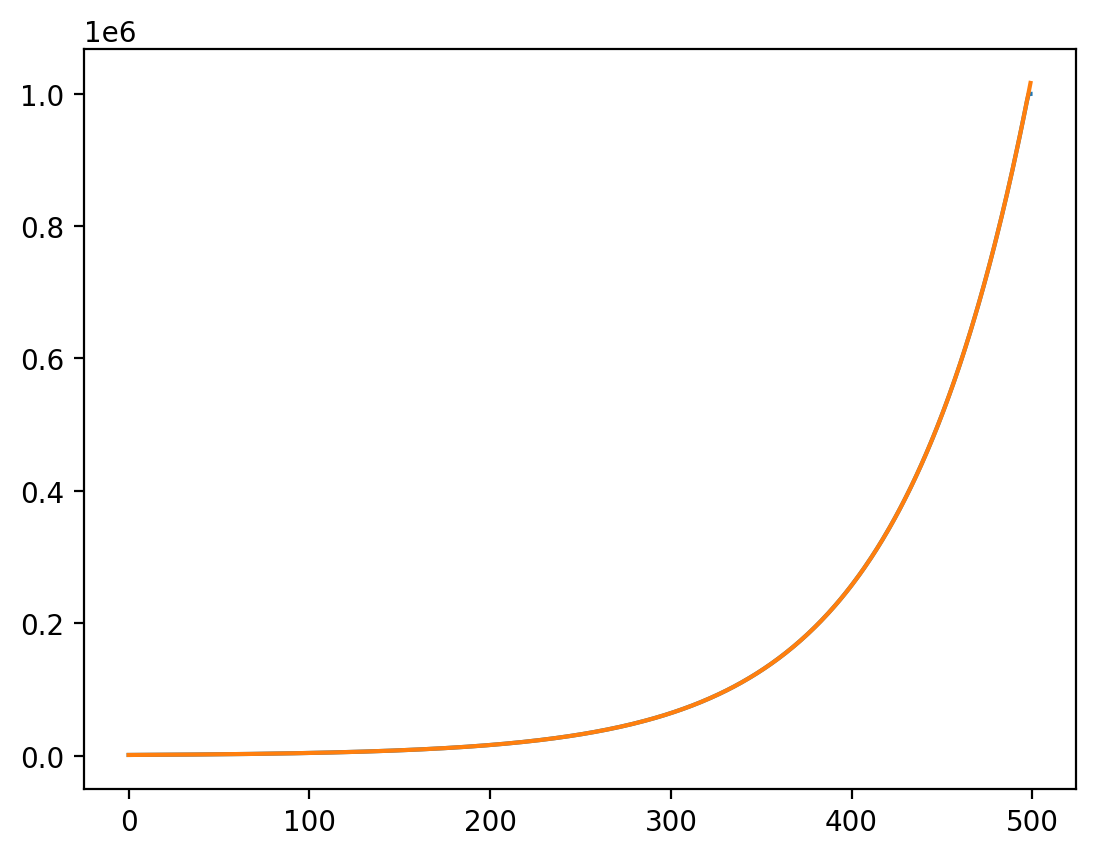

In [77]:
plt.plot(data_en)
plt.plot(loop_en)


0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490


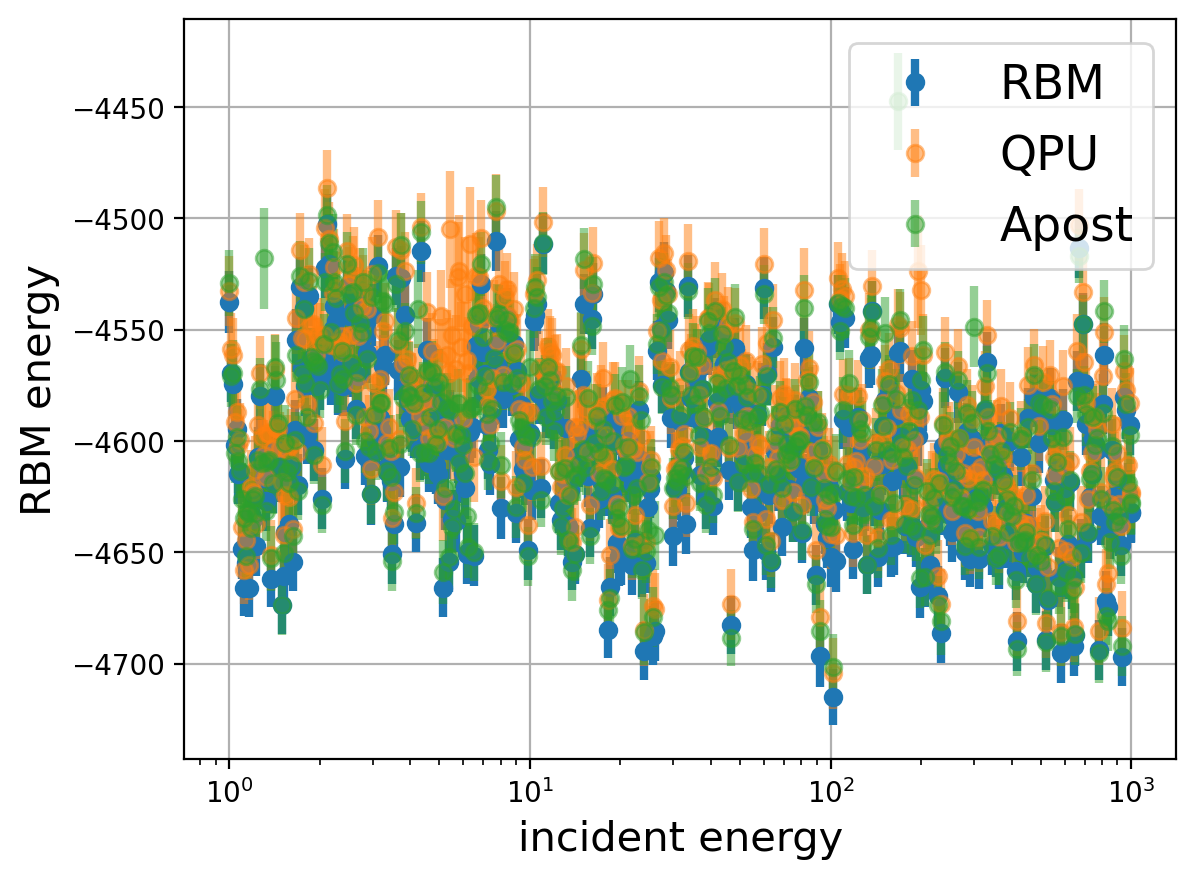

In [34]:
rbm_dict = {"en":[], "m":[], "s":[]}
qpu_dict = {"en":[], "m":[], "s":[], "samples":[]}
apost_dict = {"en":[], "m":[], "s":[]}
for i,en_label_ in enumerate(np.logspace(3.0, 6.007, num=500, dtype="float32")):
    if i%10==0:
        print(i)
    idx = find_the_energy_idx(en_label_, true_energy)
    en_label = true_energy[idx,0].detach().cpu().item()
    energy_enc, enc_energy = approx_post(true_energy, in_data, en_label)
    
    energy_rbm_, enc_energy = classical_RBM([en_label], cond=con)
    energy_dwave_2, dwave_samples = quantum_RBM([en_label], cond=con, thrsh=thrsh, est_beta=False)
    
    rbm_dict["en"].append(en_label/1000)
    rbm_dict["m"].append(energy_rbm_.mean().detach().cpu().item())
    rbm_dict["s"].append(energy_rbm_.std().detach().cpu().item())
    
    qpu_dict["en"].append(en_label/1000)
    qpu_dict["m"].append(energy_dwave_2.mean().detach().cpu().item())
    qpu_dict["s"].append(energy_dwave_2.std().detach().cpu().item())
    qpu_dict["samples"].append(dwave_samples.detach().cpu())
    
    apost_dict["en"].append(en_label/1000)
    apost_dict["m"].append(energy_enc.mean().detach().cpu().item())
    apost_dict["s"].append(energy_enc.std().detach().cpu().item())
    time.sleep(2.5)

plt.errorbar(rbm_dict["en"], rbm_dict["m"], yerr=rbm_dict["s"], fmt="o", label="RBM", lw=3)
plt.errorbar(qpu_dict["en"], qpu_dict["m"], yerr=qpu_dict["s"], fmt="o", label="QPU", lw=3, alpha=0.5)
plt.errorbar(apost_dict["en"], apost_dict["m"], yerr=apost_dict["s"], fmt="o", label="Apost", lw=3, alpha=0.5)
plt.xlabel("incident energy", fontsize=15)
plt.ylabel("RBM energy", fontsize=15)
plt.grid(True)
plt.legend(fontsize=17)
plt.xscale("log")
plt.show()

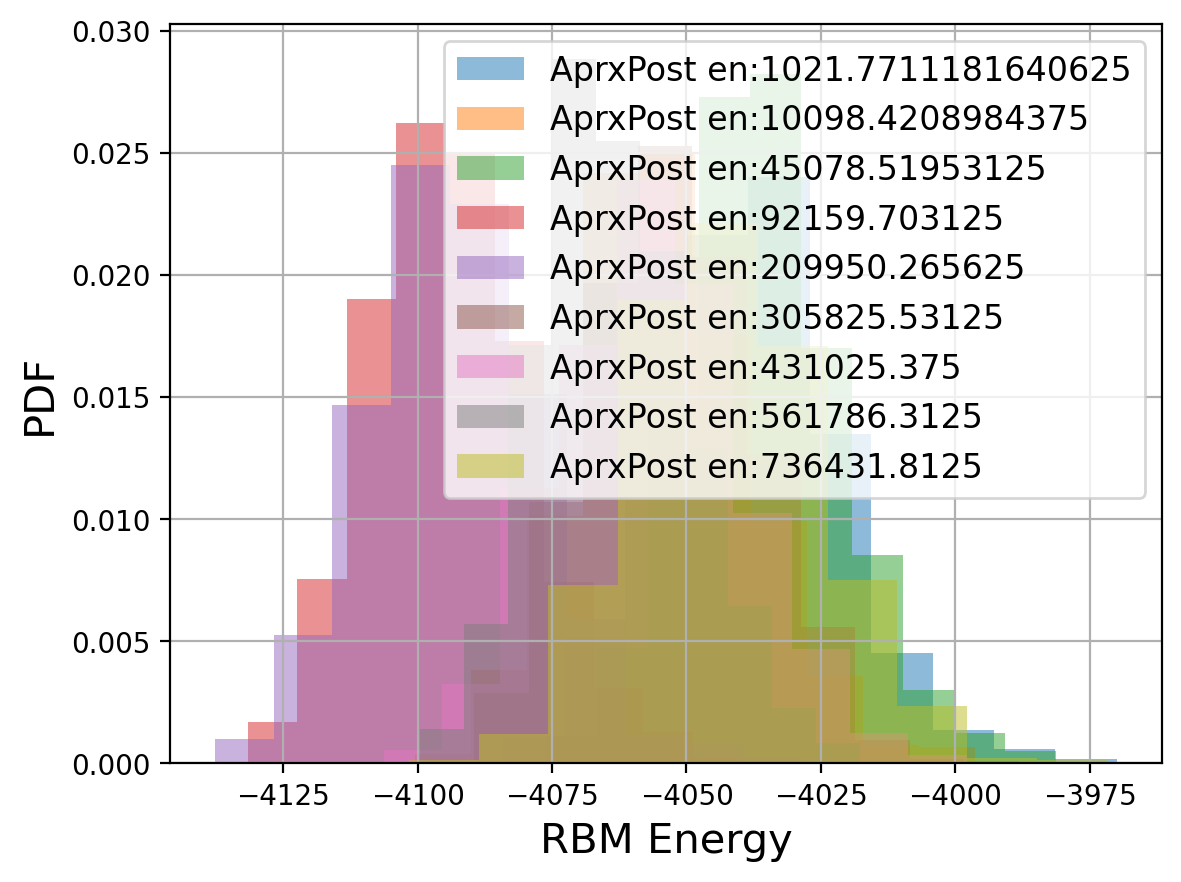

In [188]:
for i,en_label in enumerate([1000.,10000.,50000.,100000., 200000., 300000., 400000., 600000.,800000.]):
    idx = find_the_energy_idx(en_label, true_energy)
    en_label_idx = true_energy[idx,0].detach().cpu().item()
    energy_enc, enc_energy = approx_post(true_energy, in_data, en_label_idx)
    plt.hist(energy_enc.detach().cpu(), alpha=0.5, density=True, bins=10, label=f'AprxPost en:{en_label_idx}')
plt.xlabel("RBM Energy", fontsize=15)
plt.ylabel("PDF", fontsize=15)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()

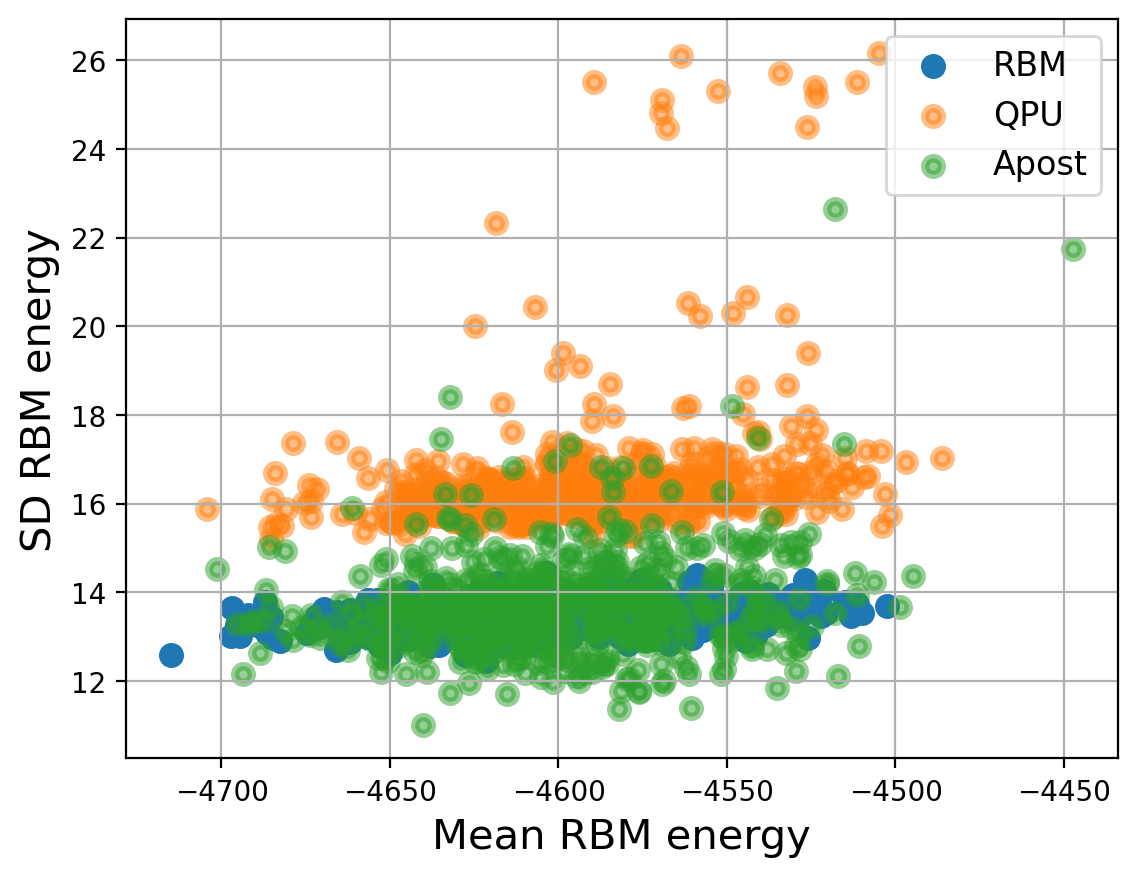

In [35]:
plt.scatter(rbm_dict["m"], rbm_dict["s"],  label="RBM", lw=3)
plt.scatter(qpu_dict["m"], qpu_dict["s"],  label="QPU", lw=3, alpha=0.5)
plt.scatter(apost_dict["m"], apost_dict["s"], label="Apost", lw=3, alpha=0.5)
plt.xlabel("Mean RBM energy", fontsize=15)
plt.ylabel("SD RBM energy", fontsize=15)
plt.grid(True)
plt.legend(fontsize=12)
plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/DWAVE/SD_vs_mean_Apost_MC_QPU_thrsh_{thrsh}_v4.png')
plt.show()

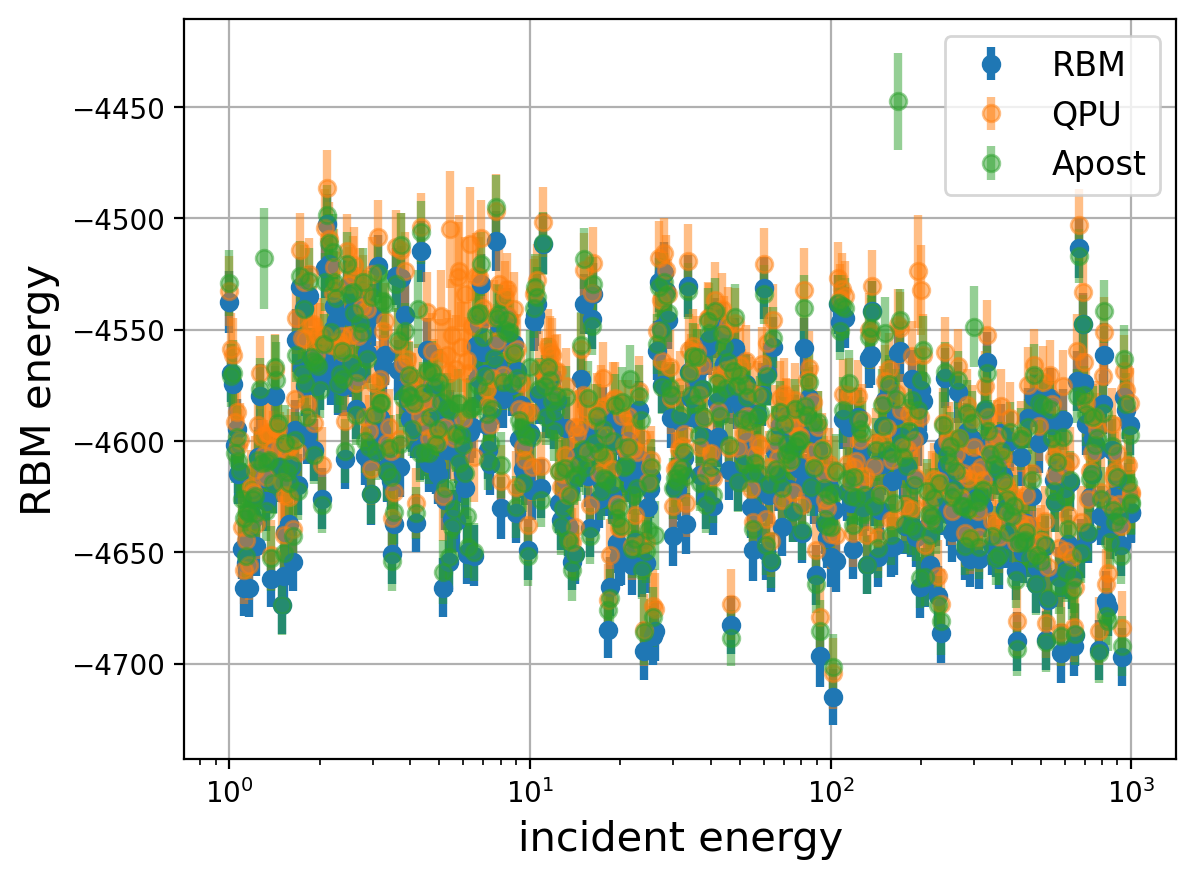

In [36]:
plt.errorbar(rbm_dict["en"], rbm_dict["m"], yerr=rbm_dict["s"], fmt="o", label="RBM", lw=3)
plt.errorbar(qpu_dict["en"], qpu_dict["m"], yerr=qpu_dict["s"], fmt="o", label="QPU", lw=3, alpha=0.5)
plt.errorbar(apost_dict["en"], apost_dict["m"], yerr=apost_dict["s"], fmt="o", label="Apost", lw=3, alpha=0.5)
plt.xlabel("incident energy", fontsize=15)
plt.ylabel("RBM energy", fontsize=15)
plt.grid(True)
plt.legend(fontsize=12)
plt.xscale("log")
plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/DWAVE/Comparison_Apost_MC_QPU_thrsh_{thrsh}_v4.png')
plt.show()

In [31]:
# np.savez(f'/home/javier/Projects/CaloQVAE/figs/DWAVE/Exp2_data.npz', rbm=energy_rbm_.detach().cpu().numpy(), qpu1=energy_dwave_2.detach().cpu().numpy(), 
         # qpun = energy_dwave_3.detach().cpu().numpy(), beta=np.array(beta_list_2))

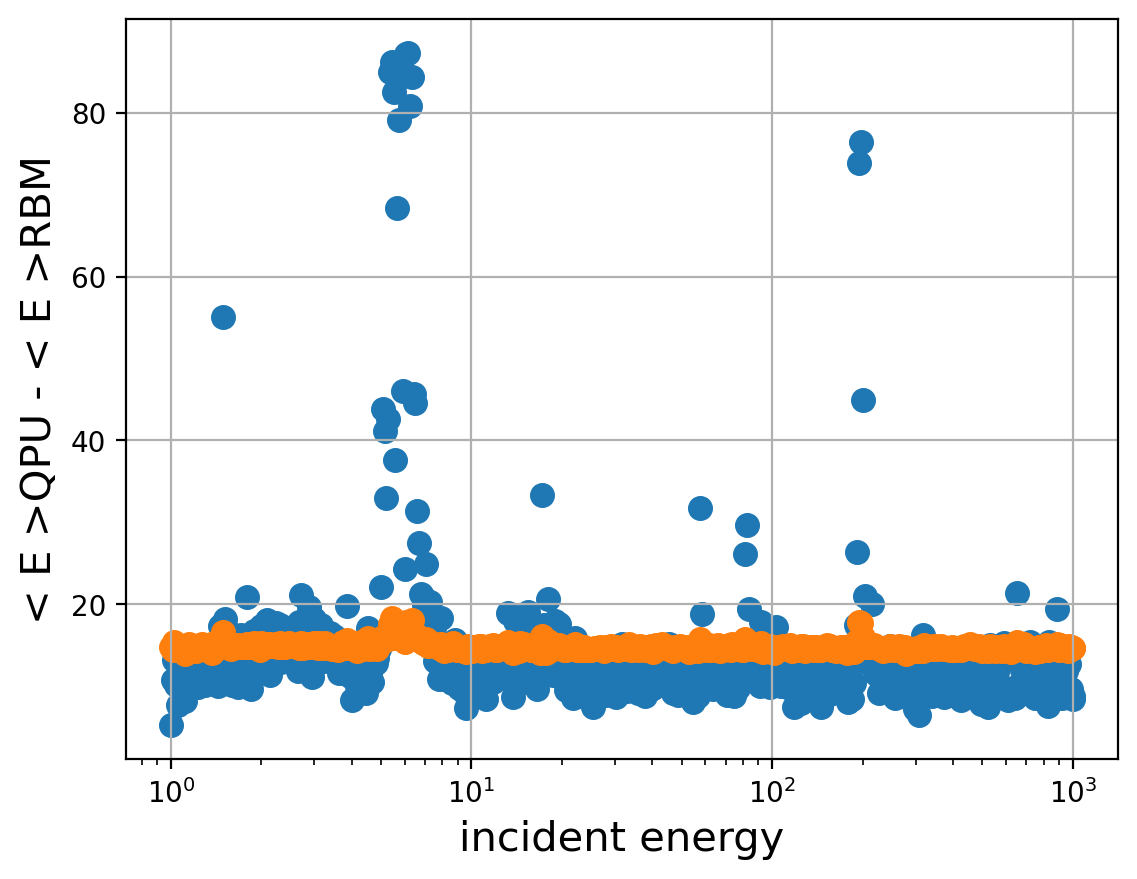

In [37]:
plt.scatter(qpu_dict['en'], np.abs(np.array(qpu_dict['m']) - np.array(rbm_dict["m"])), lw=3)
plt.scatter(qpu_dict['en'], 2*(np.array(rbm_dict["s"])*np.array(qpu_dict["s"]))/(np.array(rbm_dict["s"]) + np.array(qpu_dict["s"])), lw=3)
plt.xscale("log")
plt.xlabel("incident energy", fontsize=15)
plt.ylabel("< E >QPU - < E >RBM", fontsize=15)
plt.grid(True) 
plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/DWAVE/Diff_energy_thrsh_{thrsh}_v4.png')
plt.show()

Text(0.5, 0, 'QPU mean energy')

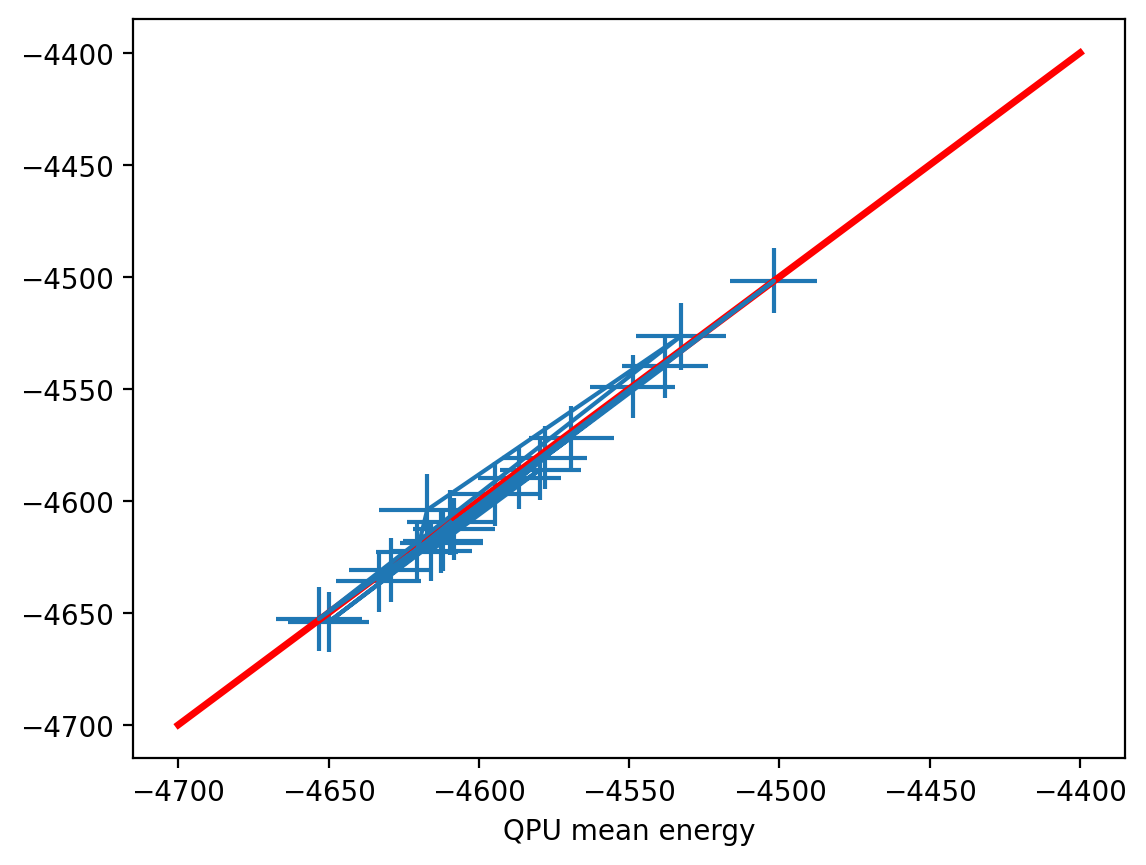

In [75]:
plt.errorbar(rbm_dict["m"], qpu_dict["m"], xerr=qpu_dict["s"], yerr=qpu_dict["s"])
plt.plot([-4700,-4400],[-4700,-4400], c='red', lw=2.5)
plt.xlabel('RBM mean energy')
plt.xlabel('QPU mean energy')
# plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/DWAVE/scatter_plot_rbm_qpu_2.png')

In [96]:
np.unique(rbm_dict["en"])

array([  1.01089551,   1.08367627,   1.28307349,   1.47200635,
         1.60672839,   1.7300426 ,   1.76156482,   1.90237268,
         2.32472412,   2.38180811,   2.91614893,   3.5098916 ,
         3.76296997,   4.1405459 ,   4.77559131,   5.09955908,
         5.35336377,   5.89829541,   5.97664307,   7.28372607,
         7.82947998,   8.23147852,   8.79671582,   9.91202832,
        10.38333105,  11.52353809,  14.01506641,  15.22819629,
        16.68392578,  19.27905859,  19.90309375,  23.24224023,
        25.44076758,  28.14117188,  32.22032227,  32.64531445,
        39.94591797,  45.87747266,  52.29728125,  55.28308594,
        61.43353516,  69.3343125 ,  82.74284375,  85.60457031,
        93.76325   , 101.51660938, 118.32957812, 142.25540625,
       158.68623437, 187.6643125 , 192.7334375 , 221.95279687,
       239.74503125, 266.523875  , 280.5654375 , 344.285875  ,
       395.46121875, 420.35034375, 435.10175   , 527.5921875 ,
       536.455875  , 545.13225   , 590.3585625 , 693.56

In [14]:
modelname

'skilled-night-490'

In [15]:
import pickle

In [17]:
h, J, qubit_idxs, idx_dict, dwave_weights, dwave_bias = engine.model.ising_model(1)
with open(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/RBM_biases_Peg.pickle', 'wb') as handle:
    pickle.dump(h, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/RBM_weights_Peg.pickle', 'wb') as handle:
    pickle.dump(J, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('/home/javier/Projects/CaloQVAE/figs/DWAVE/RBM_biases.pickle', 'rb') as handle:
#     b = pickle.load(handle)
    
# with open('/home/javier/Projects/CaloQVAE/figs/DWAVE/RBM_weights.pickle', 'rb') as handle:
#     a = pickle.load(handle)

In [30]:
with open('/home/javier/Projects/CaloQVAE/figs/DWAVE/rbm_dict.pickle', 'wb') as handle:
    pickle.dump(rbm_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('/home/javier/Projects/CaloQVAE/figs/DWAVE/qpu_dict.pickle', 'wb') as handle:
    pickle.dump(qpu_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('/home/javier/Projects/CaloQVAE/figs/DWAVE/apost_dict.pickle', 'wb') as handle:
    pickle.dump(apost_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('/home/javier/Projects/CaloQVAE/figs/DWAVE/rbm_dict.pickle', 'rb') as handle:
    b = pickle.load(handle)

In [44]:
len(qpu_dict["samples"])

500

In [29]:
###################### Autocorrelation time

In [10]:
def block_gibbs_sampling(self, p0=None,p1=None,p2=None,p3=None, method='Rdm', n_steps=1):
        """block_gibbs_sampling()

        :return p0_state (torch.Tensor) : (batch_size, n_nodes_p1)
        :return p1_state (torch.Tensor) : (batch_size, n_nodes_p2)
        :return p2_state (torch.Tensor) : (batch_size, n_nodes_p3)
        :return p3_state (torch.Tensor) : (batch_size, n_nodes_p4)
        """
        prbm = self._prbm
        p_bias = prbm.bias_dict
        p_weight = prbm.weight_dict
        p0_bias = p_bias['0']
        p1_bias = p_bias['1']
        p2_bias = p_bias['2']
        p3_bias = p_bias['3']

        
        if method == 'Rdm' or p1==None:
            # Initialize the random state of partitions 1, 2, and 3
            p1_state = torch.bernoulli(torch.rand(self._batch_size,
                                                  prbm.nodes_per_partition,
                                                  device=p0_bias.device))
            p2_state = torch.bernoulli(torch.rand(self._batch_size,
                                                  prbm.nodes_per_partition,
                                                  device=p0_bias.device))
            p3_state = torch.bernoulli(torch.rand(self._batch_size,
                                              prbm.nodes_per_partition,
                                              device=p0_bias.device))
        elif method == 'CD':
            # Initialize the random state of partitions 1, 2, and 3
            p1_state = p1
            p2_state = p2
            p3_state = p3
        elif method == 'PCD':
            pass
            
        for _ in range(n_steps):
            p0_state = self._p_state(p_weight['01'].T,
                                     p_weight['02'].T,
                                     p_weight['03'].T,
                                     p1_state, p2_state, p3_state,
                                     p0_bias)
            p1_state = self._p_state(p_weight['01'],
                                     p_weight['12'].T,
                                     p_weight['13'].T,
                                     p0_state, p2_state, p3_state,
                                     p1_bias)
            p2_state = self._p_state(p_weight['02'],
                                     p_weight['12'],
                                     p_weight['23'].T,
                                     p0_state, p1_state, p3_state,
                                     p2_bias)
            p3_state = self._p_state(p_weight['03'],
                                     p_weight['13'],
                                     p_weight['23'],
                                     p0_state, p1_state, p2_state,
                                     p3_bias)

        return p0_state.detach(), p1_state.detach(), \
            p2_state.detach(), p3_state.detach()

def block_gibbs_sampling_cond(self, p0,p1=None,p2=None,p3=None, method='Rdm', n_steps=1):
        """block_gibbs_sampling()

        :return p0_state (torch.Tensor) : (batch_size, n_nodes_p1)
        :return p1_state (torch.Tensor) : (batch_size, n_nodes_p2)
        :return p2_state (torch.Tensor) : (batch_size, n_nodes_p3)
        :return p3_state (torch.Tensor) : (batch_size, n_nodes_p4)
        """
        prbm = self._prbm
        p0_bias = prbm._bias_dict['0']
        p_bias = prbm.bias_dict
        p_weight = prbm.weight_dict
        # p0_bias = p_bias['0']
        p1_bias = p_bias['1']
        p2_bias = p_bias['2']
        p3_bias = p_bias['3']

        
        if method == 'Rdm' or p1==None:
            # Initialize the random state of partitions 1, 2, and 3
            p1_state = torch.bernoulli(torch.rand(p0.shape[0], #self._batch_size,
                                                  prbm.nodes_per_partition,
                                                  device=p1_bias.device))
            p2_state = torch.bernoulli(torch.rand(p0.shape[0], #self._batch_size,
                                                  prbm.nodes_per_partition,
                                                  device=p1_bias.device))
            p3_state = torch.bernoulli(torch.rand(p0.shape[0], #self._batch_size,
                                              prbm.nodes_per_partition,
                                              device=p1_bias.device))
            # p3_state = p3.to(p1_state.dtype)
        elif method == 'CD':
            # Initialize the random state of partitions 1, 2, and 3
            p1_state = p1
            p2_state = p2
            p3_state = p3
        elif method == 'PCD':
            pass
            
        for _ in range(n_steps):
            # p0_state = self._p_state(p_weight['01'].T,
            #                          p_weight['02'].T,
            #                          p_weight['03'].T,
            #                          p1_state, p2_state, p3_state,
            #                          p0_bias)
            p1_state = self._p_state(p_weight['01'],
                                     p_weight['12'].T,
                                     p_weight['13'].T,
                                     p0, p2_state, p3_state,
                                     p1_bias)
            p2_state = self._p_state(p_weight['02'],
                                     p_weight['12'],
                                     p_weight['23'].T,
                                     p0, p1_state, p3_state,
                                     p2_bias)
            p3_state = self._p_state(p_weight['03'],
                                     p_weight['13'],
                                     p_weight['23'],
                                     p0, p1_state, p2_state,
                                     p3_bias)

        return p0.detach(), p1_state.detach(), \
            p2_state.detach(), p3_state.detach()

In [42]:
steps=1000
ensemble=100
Δt=1
# p0=torch.bernoulli(torch.rand(ensemble,engine.model.sampler._prbm.nodes_per_partition)).to(dev)
# p0,p1,p2,p3 = block_gibbs_sampling(engine.model.sampler, p0, n_steps=1)
p0 = torch.bernoulli(torch.rand(1,engine.model.sampler._prbm.nodes_per_partition)).to(dev).repeat(ensemble,1)
p0,p1,p2,p3 = block_gibbs_sampling(engine.model.sampler, p0, n_steps=1000)
# p0,p1,p2,p3 = block_gibbs_sampling_cond(engine.model.sampler, p0, n_steps=1)
p0T,p1T,p2T,p3T = p0.unsqueeze(2), p1.unsqueeze(2), p2.unsqueeze(2), p3.unsqueeze(2)
for i in range(steps):
    p0,p1,p2,p3 = block_gibbs_sampling(engine.model.sampler, p0,p1,p2,p3,"CD",Δt)
    # p0,p1,p2,p3 = block_gibbs_sampling_cond(engine.model.sampler, p0,p1,p2,p3,"CD",Δt)
    p0T = torch.cat((p0T,p0.unsqueeze(2)),dim=2)
    p1T = torch.cat((p1T,p1.unsqueeze(2)),dim=2)
    p2T = torch.cat((p2T,p2.unsqueeze(2)),dim=2)
    p3T = torch.cat((p3T,p3.unsqueeze(2)),dim=2)

In [43]:
def self_correlation(arr, t,τ):
    μ = arr.mean(dim=0)
    C = (arr[:,t+τ]*arr[:,t]).mean(dim=0) - μ[t+τ]*μ[t]
    return C/((arr[:,t]*arr[:,t]).mean(dim=0) - μ[t]*μ[t])

def c_tau(p1T,τ):
    C1 = self_correlation(p1T,0,τ)
    C1T = C1.unsqueeze(0)
    for t in range(1,steps+1-τ):
        # print(t)
        C1 = self_correlation(p1T,t,τ)
        C1T = torch.cat((C1T, C1.unsqueeze(0)),dim=0)
    C1m = C1T.mean(dim=0)
    C1std = C1T.std(dim=0)
    return C1m, C1std

In [44]:
m = torch.cat([p0T,p1T,p2T,p3T],dim=1).mean(dim=1)
# m = torch.cat([p1T,p2T,p3T],dim=1).mean(dim=1)

C1m, C1std = c_tau(m,0)
ACF_m = C1m.unsqueeze(0)
ACF_std = C1std.unsqueeze(0)
for τ in range(1,1000,10):
    print(τ)
    C1m, C1std = c_tau(m,τ)
    ACF_m = torch.cat((ACF_m,C1m.unsqueeze(0)),dim=0)
    ACF_std = torch.cat((ACF_std,C1std.unsqueeze(0)),dim=0)
ACF_m = ACF_m.cpu()
ACF_std = ACF_std.cpu()
# C_dict[str(i)] = C1.permute(1,0)
# plt.plot(C1.permute(1,0))
# plt.show()

1
11
21
31
41
51
61
71
81
91
101
111
121
131
141
151
161
171
181
191
201
211
221
231
241
251
261
271
281
291
301
311
321
331
341
351
361
371
381
391
401
411
421
431
441
451
461
471
481
491
501
511
521
531
541
551
561
571
581
591
601
611
621
631
641
651
661
671
681
691
701
711
721
731
741
751
761
771
781
791
801
811
821
831
841
851
861
871
881
891
901
911
921
931
941
951
961
971
981
991


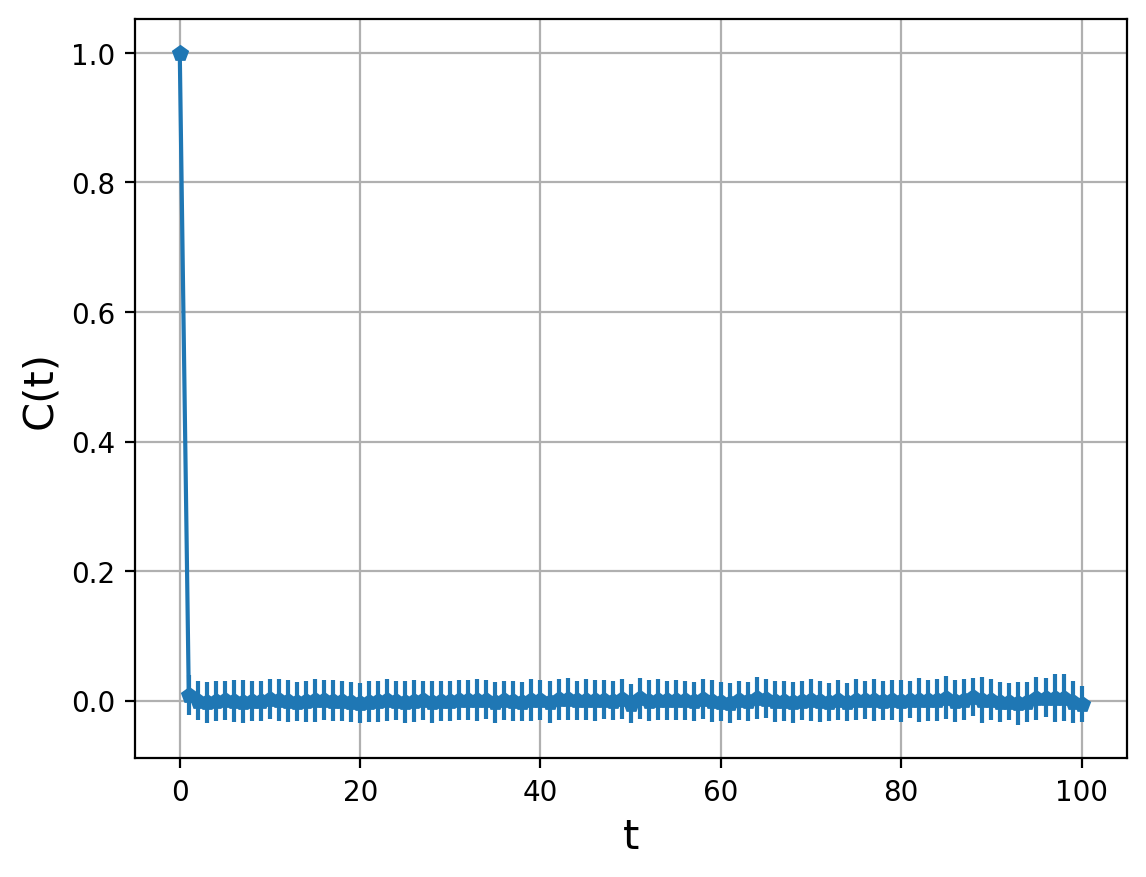

In [45]:
# plt.plot(ACF_m, marker='p',  markersize=5)
plt.errorbar(range(len(ACF_m)), ACF_m, yerr=ACF_std, marker='p',  markersize=5)
plt.grid("True")
plt.xlabel("t", fontsize=15)
plt.ylabel("C(t)", fontsize=15)
plt.show()

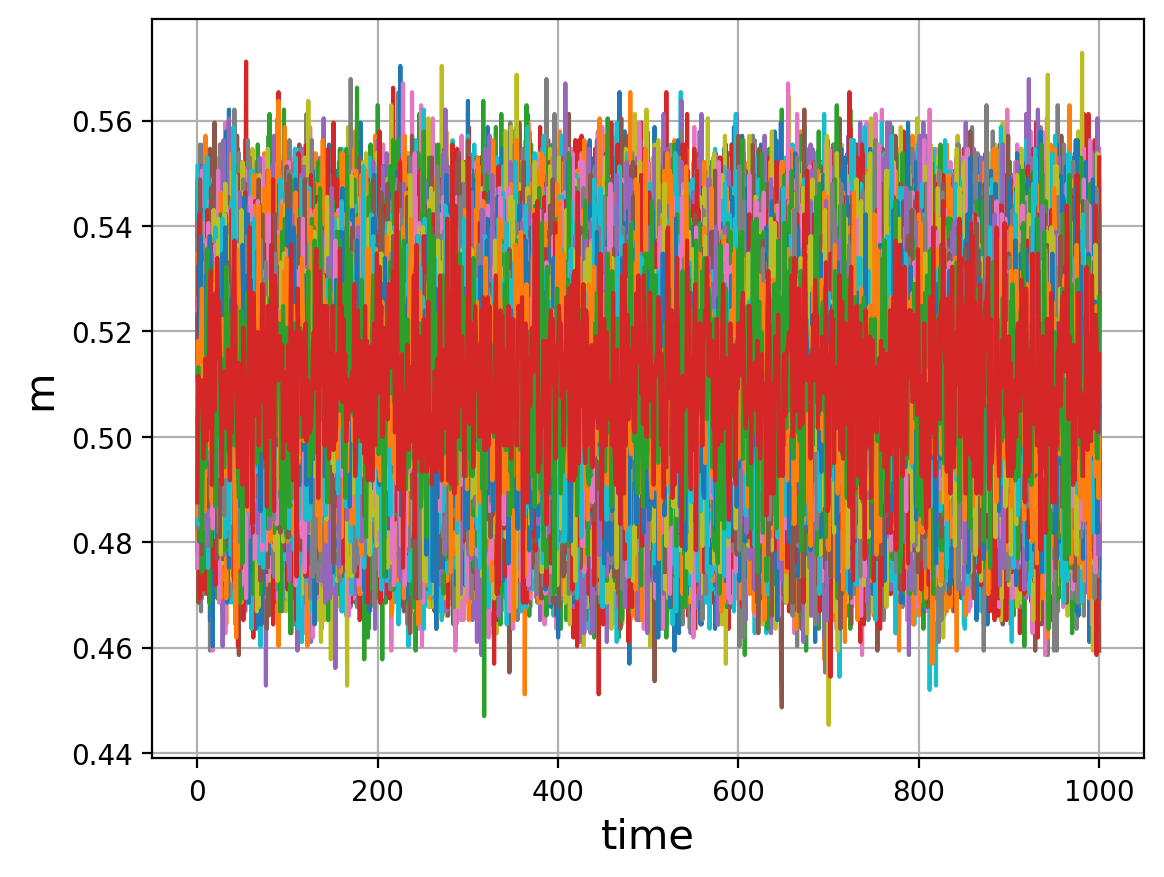

In [40]:
plt.plot(m.permute(1,0).detach().cpu())
plt.grid("True")
plt.xlabel("time", fontsize=15)
plt.ylabel("m", fontsize=15)
plt.show()

In [204]:
m.shape

torch.Size([1024, 1001])

In [160]:
engine.model.sampler._prbm._bias_dict

ParameterDict(
    (0): Parameter containing: [torch.cuda.FloatTensor of size 302 (cuda:4)]
    (1): Parameter containing: [torch.cuda.FloatTensor of size 302 (cuda:4)]
    (2): Parameter containing: [torch.cuda.FloatTensor of size 302 (cuda:4)]
    (3): Parameter containing: [torch.cuda.FloatTensor of size 302 (cuda:4)]
)

In [275]:
#Random
steps=500
ensemble=1000
Δt=100
p0,p1,p2,p3=torch.bernoulli(torch.rand(ensemble,engine.model.sampler._prbm.nodes_per_partition)).to(dev), \
    torch.bernoulli(torch.rand(ensemble,engine.model.sampler._prbm.nodes_per_partition)).to(dev),\
    torch.bernoulli(torch.rand(ensemble,engine.model.sampler._prbm.nodes_per_partition)).to(dev),\
    torch.bernoulli(torch.rand(ensemble,engine.model.sampler._prbm.nodes_per_partition)).to(dev)
p0T,p1T,p2T,p3T = p0.unsqueeze(2), p1.unsqueeze(2), p2.unsqueeze(2), p3.unsqueeze(2)
for i in range(steps):
    p0,p1,p2,p3=torch.bernoulli(torch.rand(ensemble,engine.model.sampler._prbm.nodes_per_partition)).to(dev), \
        torch.bernoulli(torch.rand(ensemble,engine.model.sampler._prbm.nodes_per_partition)).to(dev),\
        torch.bernoulli(torch.rand(ensemble,engine.model.sampler._prbm.nodes_per_partition)).to(dev),\
        torch.bernoulli(torch.rand(ensemble,engine.model.sampler._prbm.nodes_per_partition)).to(dev)
    p0T = torch.cat((p0T,p0.unsqueeze(2)),dim=2)
    p1T = torch.cat((p1T,p1.unsqueeze(2)),dim=2)
    p2T = torch.cat((p2T,p2.unsqueeze(2)),dim=2)
    p3T = torch.cat((p3T,p3.unsqueeze(2)),dim=2)

In [198]:
def self_correlation(arr, t,τ):
    μ = arr.mean(dim=0)
    C = (arr[:,:,t+τ]*arr[:,:,t]).mean(dim=0) - μ[:,t+τ]*μ[:,t]
    return C/(arr.var(dim=0)[:,t])

def c_i_tau(p1T,τ):
    C1 = self_correlation(p1T,0,τ)
    C1T = C1.unsqueeze(1)
    for t in range(1,steps+1-τ):
        # print(t)
        C1 = self_correlation(p1T,t,τ)
        C1T = torch.cat((C1T, C1.unsqueeze(1)),dim=1)
    C1m = C1T.mean(dim=1)
    return C1m

In [199]:
# p1T.var(dim=0)[p1T.var(dim=0)>0.0].min()
self_correlation(p1T,0,τ).shape

torch.Size([302])

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


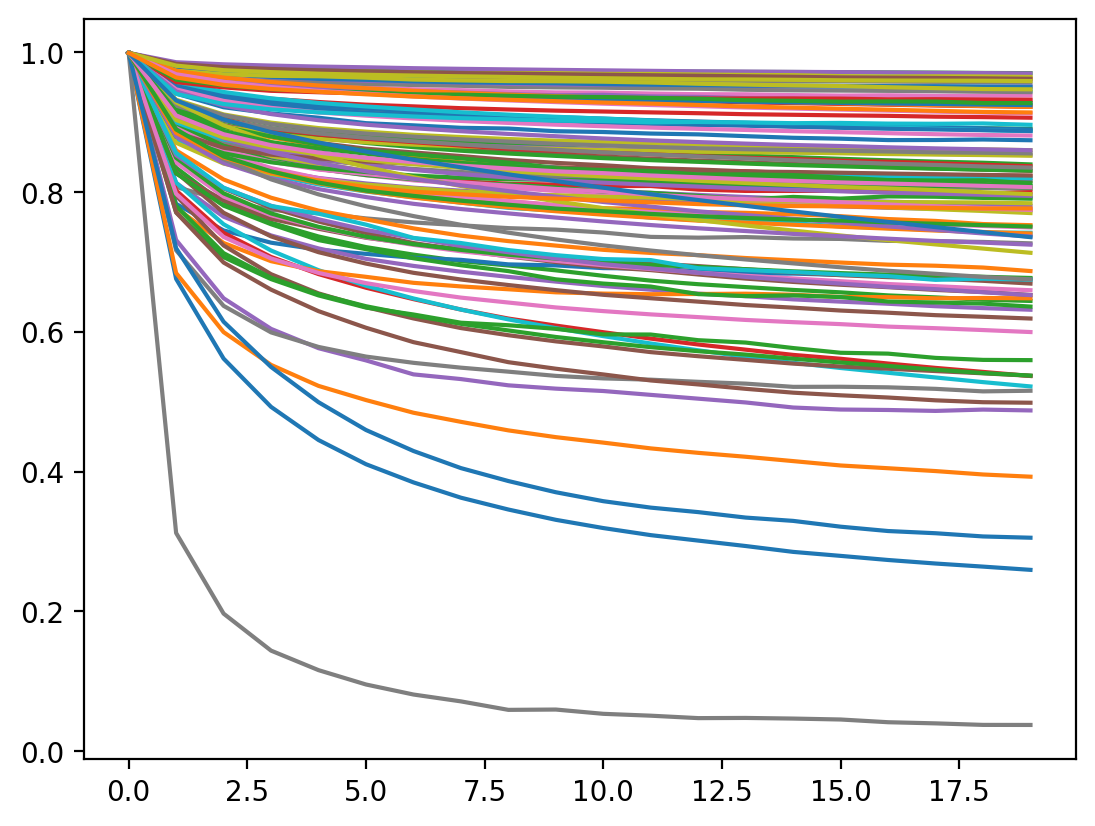

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


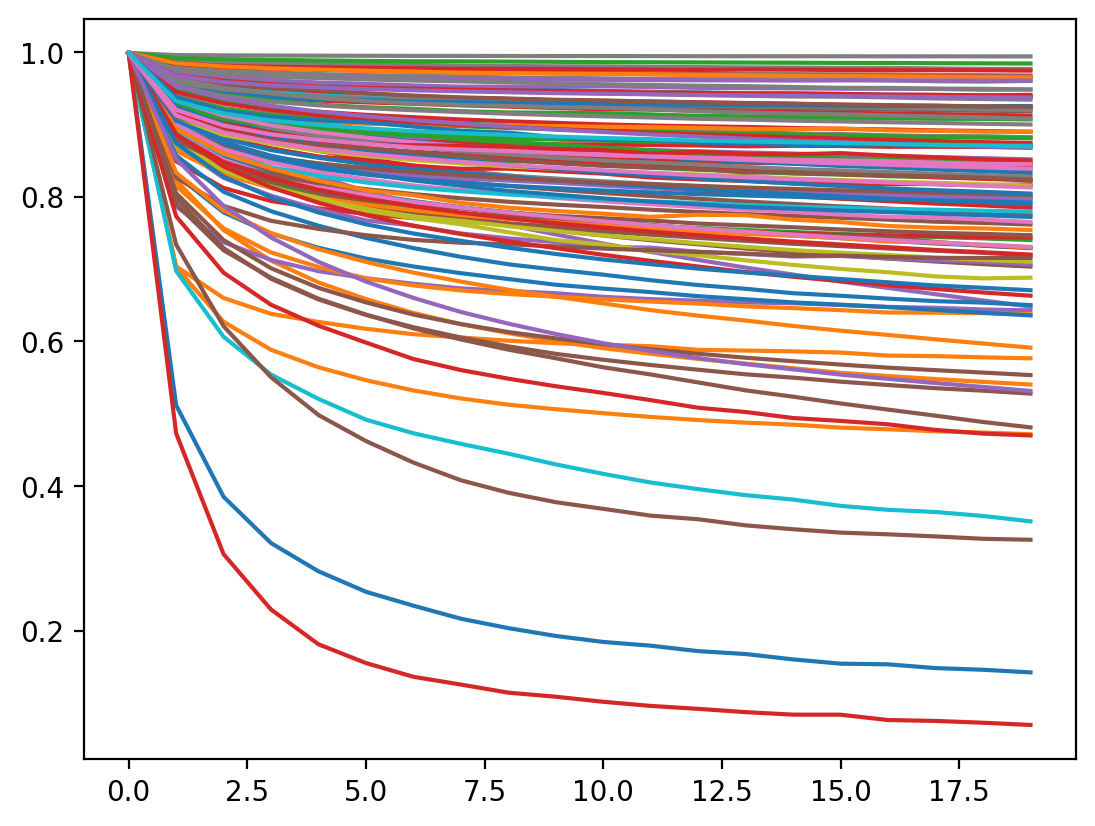

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


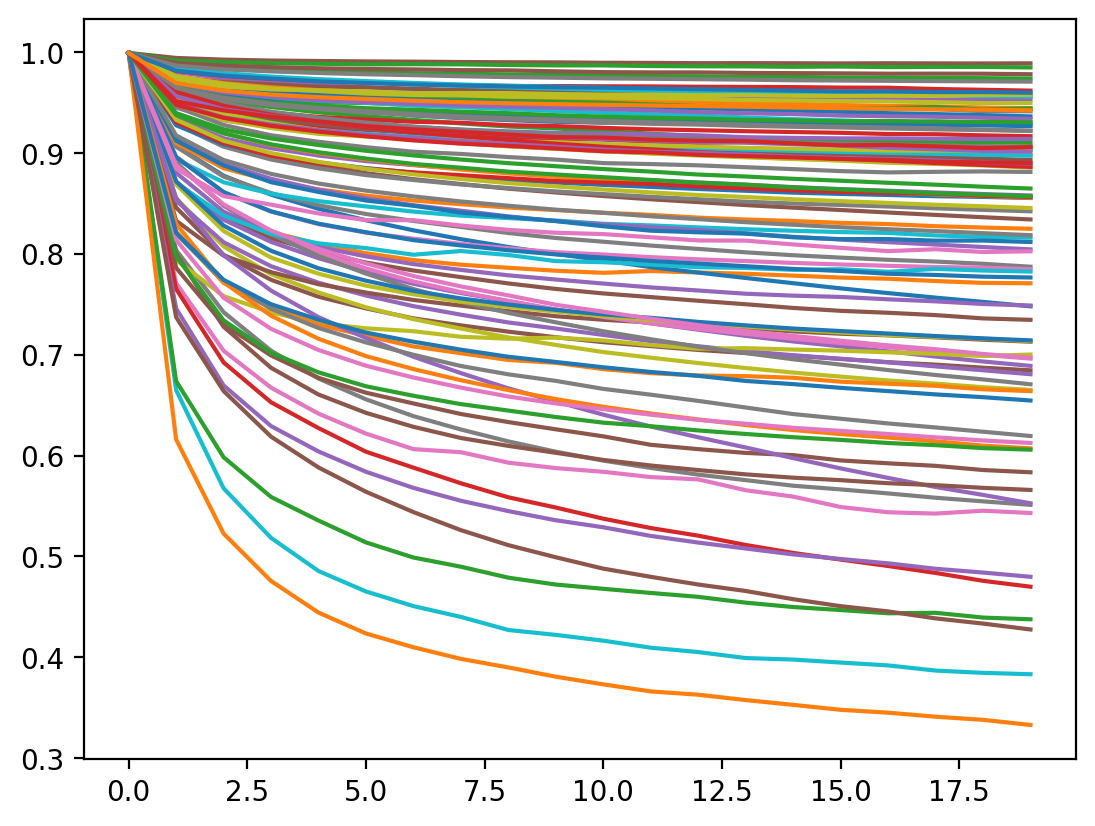

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


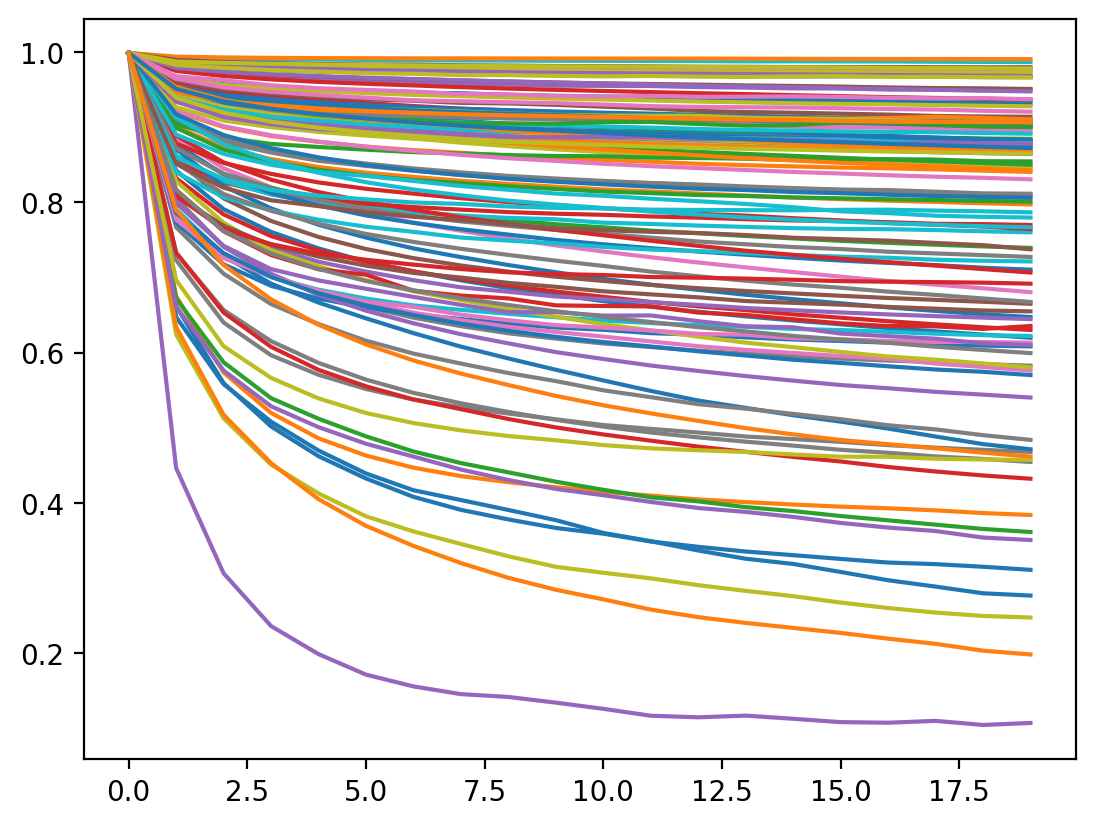

In [200]:
C_dict={}
for i,arr in enumerate([p0T,p1T,p2T,p3T]):
    C1m = c_i_tau(arr,0)
    C1 = C1m.unsqueeze(1)
    for τ in range(1,20,1):
        print(τ)
        C1m = c_i_tau(arr,τ)
        C1 = torch.cat((C1,C1m.unsqueeze(1)),dim=1)
    C1 = C1.cpu()
    C_dict[str(i)] = C1.permute(1,0)
    plt.plot(C1.permute(1,0))
    plt.show()

In [108]:
# with open('/home/javier/Projects/CaloQVAE/figs/DWAVE/corr_zephyr.pickle', 'wb') as handle:
#     pickle.dump(C_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
# plt.plot(C_dict["2"], marker='p',  markersize=5)
# plt.xscale('log')
for i in ['0','1','2','3']:
    # engine.model.sampler._prbm.bias_dict[i] = engine.model.sampler._prbm.bias_dict[i] * 0.01
    print(i, engine.model.sampler._prbm.bias_dict[i].mean(), engine.model.sampler._prbm.bias_dict[i].std())
for i in ['01','02','03','12','13','23']:
    # engine.model.sampler._prbm.weight_dict[i] = engine.model.sampler._prbm.weight_dict[i] * 0.01
    print(i, engine.model.sampler._prbm.weight_dict[i].mean(), engine.model.sampler._prbm.weight_dict[i].std())

0 tensor(0.0033, device='cuda:4', grad_fn=<MeanBackward0>) tensor(0.0961, device='cuda:4', grad_fn=<StdBackward0>)
1 tensor(-0.0013, device='cuda:4', grad_fn=<MeanBackward0>) tensor(0.1033, device='cuda:4', grad_fn=<StdBackward0>)
2 tensor(0.0054, device='cuda:4', grad_fn=<MeanBackward0>) tensor(0.1003, device='cuda:4', grad_fn=<StdBackward0>)
3 tensor(-0.0030, device='cuda:4', grad_fn=<MeanBackward0>) tensor(0.1004, device='cuda:4', grad_fn=<StdBackward0>)
01 tensor(-5.7308e-05, device='cuda:4', grad_fn=<MeanBackward0>) tensor(0.1001, device='cuda:4', grad_fn=<StdBackward0>)
02 tensor(-0.0001, device='cuda:4', grad_fn=<MeanBackward0>) tensor(0.0999, device='cuda:4', grad_fn=<StdBackward0>)
03 tensor(1.1068e-05, device='cuda:4', grad_fn=<MeanBackward0>) tensor(0.1000, device='cuda:4', grad_fn=<StdBackward0>)
12 tensor(0.0003, device='cuda:4', grad_fn=<MeanBackward0>) tensor(0.0998, device='cuda:4', grad_fn=<StdBackward0>)
13 tensor(-6.4091e-05, device='cuda:4', grad_fn=<MeanBackward0>)

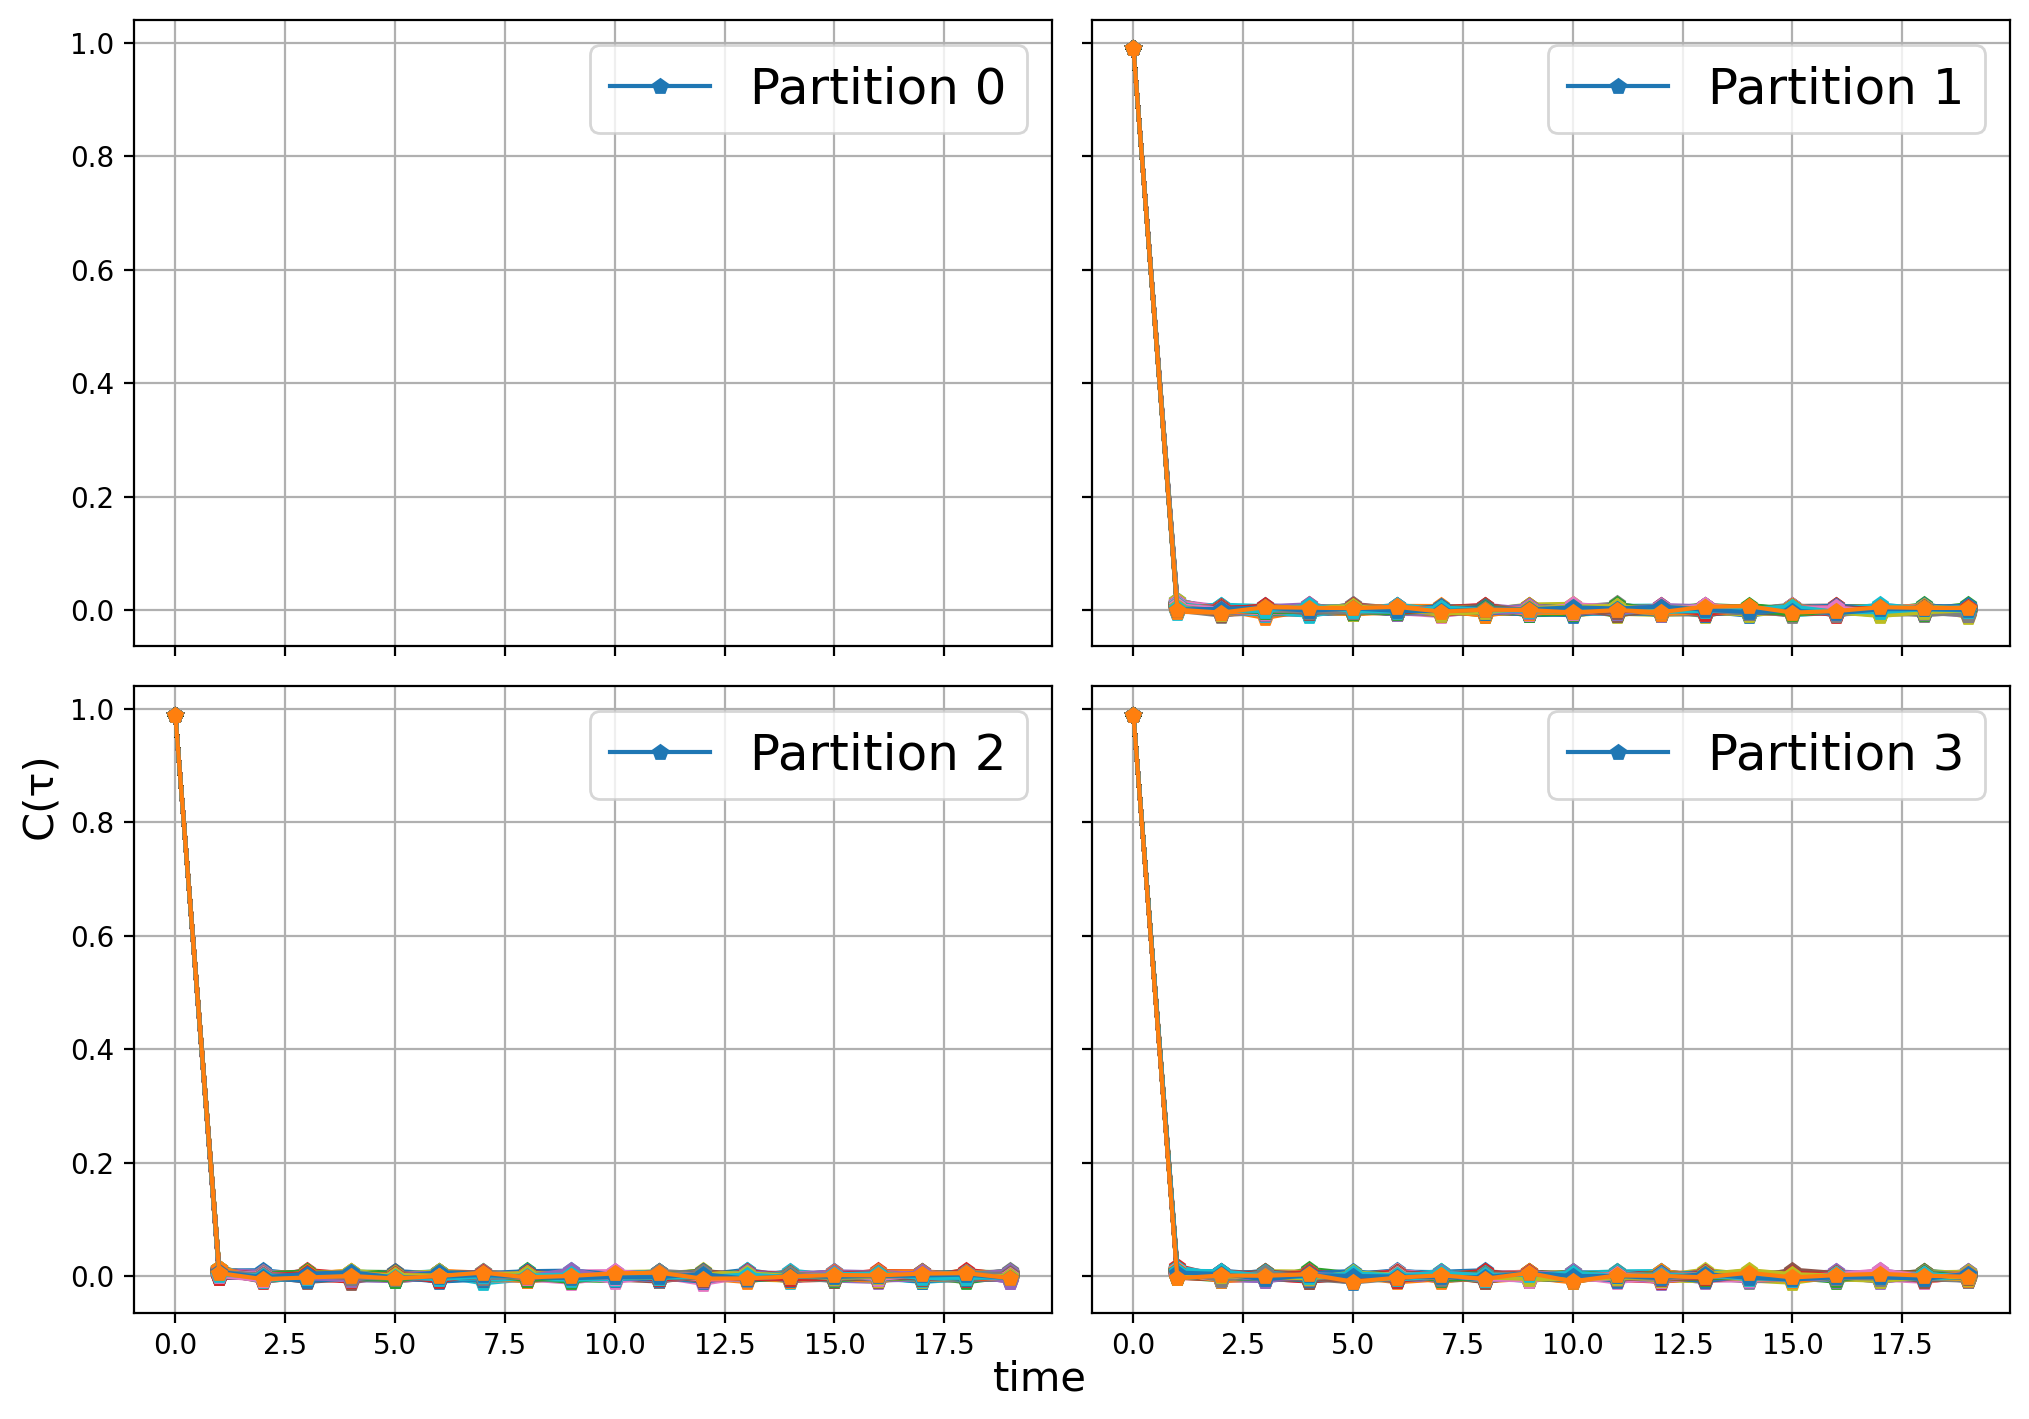

In [119]:
# Create 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 7), sharey=True, sharex=True, tight_layout=True)  # 2x2 grid, figure size 10x10
fig.text(0.5, 0.0, 'time', ha='center', fontsize=15)
fig.text(0.0, 0.4, 'C(τ)', rotation=90, ha='center', fontsize=15)

# Plot data on each subplot
axs[0,0].plot(C_dict["0"], marker='p',  markersize=5)
axs[0,0].grid("True")
axs[0,0].legend(["Partition 0"], fontsize=18)

axs[0,1].plot(C_dict["1"], marker='p',  markersize=5)
axs[0,1].grid("True")
axs[0,1].legend(["Partition 1"], fontsize=18)

axs[1,0].plot(C_dict["2"], marker='p',  markersize=5)
axs[1,0].grid("True")
axs[1,0].legend(["Partition 2"], fontsize=18)

axs[1,1].plot(C_dict["3"], marker='p',  markersize=5)
axs[1,1].grid("True")
axs[1,1].legend(["Partition 3"], fontsize=18)

# plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/weights_plot_zephyr.png', bbox_inches="tight")

plt.show()

In [23]:
tmp = C_dict["1"][-1,:] > 0.2
l = (tmp == True).nonzero(as_tuple=True)[0].numpy()
print(l)

[ 77 463]


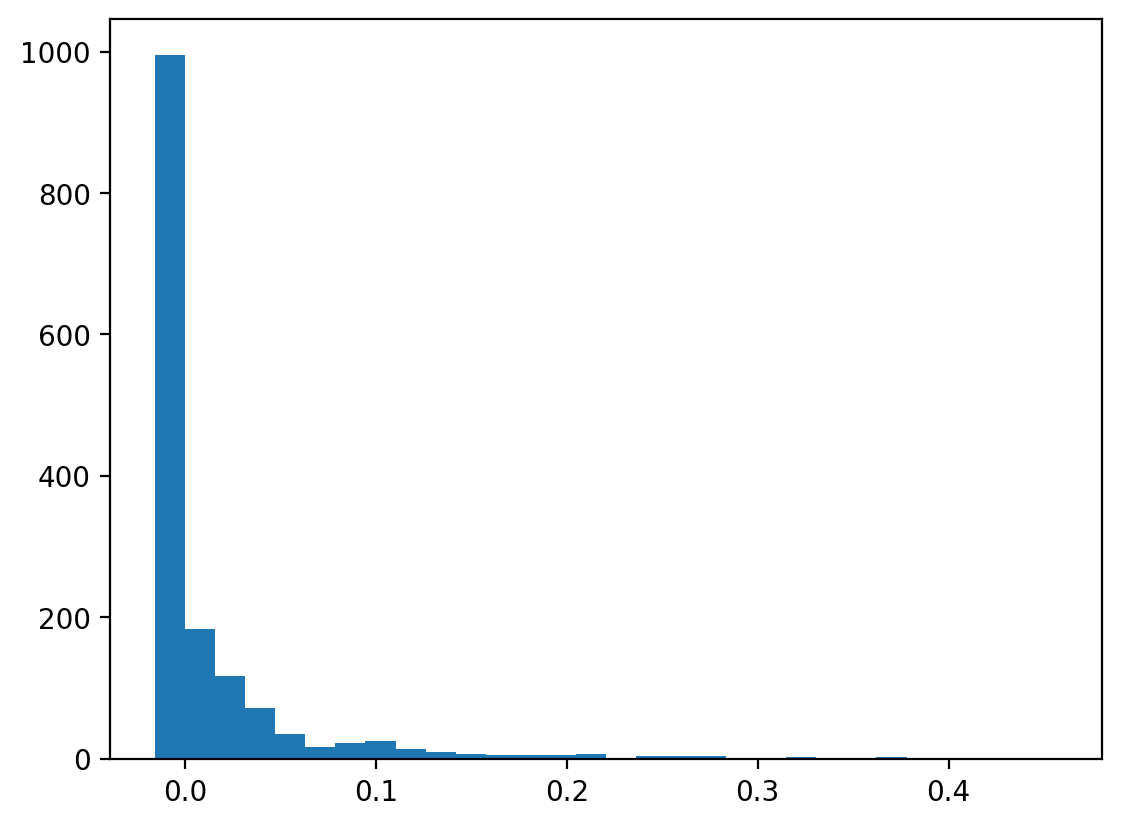

In [18]:
plt.hist(torch.cat([C_dict[str(i)][-1,:] for i in range(3)]).numpy(), bins=30)
plt.show()

In [20]:
# l = [1,2,3,4,5,6,20,80,59]
for i in l:
    print(engine.model.sampler._prbm.weight_dict['01'][:,i].abs().sign().sum()
          +engine.model.sampler._prbm.weight_dict['12'][i,:].abs().sign().sum()
          +engine.model.sampler._prbm.weight_dict['13'][i,:].abs().sign().sum())
    # print(engine.model.sampler._prbm.weight_dict['12'][i,:].abs().sign().sum())
    # print(engine.model.sampler._prbm.weight_dict['13'][i,:].abs().sign().sum())

tensor(15., device='cuda:4', grad_fn=<AddBackward0>)
tensor(15., device='cuda:4', grad_fn=<AddBackward0>)
tensor(15., device='cuda:4', grad_fn=<AddBackward0>)
tensor(15., device='cuda:4', grad_fn=<AddBackward0>)
tensor(15., device='cuda:4', grad_fn=<AddBackward0>)
tensor(15., device='cuda:4', grad_fn=<AddBackward0>)


In [24]:
for i in l:
    print(engine.model.sampler._prbm.weight_dict['02'][:,i].abs().sign().sum()
          +engine.model.sampler._prbm.weight_dict['12'][:,i].abs().sign().sum()
          +engine.model.sampler._prbm.weight_dict['23'][i,:].abs().sign().sum())

tensor(15., device='cuda:4', grad_fn=<AddBackward0>)
tensor(8., device='cuda:4', grad_fn=<AddBackward0>)


In [185]:
for i in l:
    print(engine.model.sampler._prbm.weight_dict['03'][:,i].abs().sign().sum()
          +engine.model.sampler._prbm.weight_dict['13'][:,i].abs().sign().sum()
          +engine.model.sampler._prbm.weight_dict['23'][:,i].abs().sign().sum())

tensor(12., device='cuda:0', grad_fn=<AddBackward0>)


In [33]:
engine.model.sampler._prbm.weight_dict['03']

Parameter containing:
tensor([[-0.1710, -2.1204,  0.0383,  ...,  0.0000, -0.0000, -0.0000],
        [ 2.1743, -0.9937, -0.0000,  ..., -0.0000,  0.0000, -0.0000],
        [-0.0000, -0.9139, -2.0441,  ..., -0.0000, -0.0000, -0.0000],
        ...,
        [-0.0000,  0.0000,  0.0000,  ...,  1.1855, -0.8650, -0.7195],
        [ 0.0000,  0.0000, -0.0000,  ...,  0.3669,  0.9841,  0.2427],
        [ 0.0000, -0.0000, -0.0000,  ...,  0.0000, -0.0000,  0.2608]],
       device='cuda:4', requires_grad=True)

In [53]:
(engine.model.sampler._prbm.weight_dict['01'] == 0).prod()

tensor(0, device='cuda:4')

In [360]:
#########################

In [58]:
import torch
from torch.utils.data import TensorDataset, DataLoader

def all_binary_states(num_bits: int) -> torch.Tensor:
    """
    Return a (2^num_bits) x num_bits torch.Tensor
    containing all binary states of length `num_bits`.
    """
    num_states = 1 << num_bits  # 2^num_bits
    # Integers from 0 to 2^num_bits - 1
    vals = torch.arange(num_states, dtype=torch.long)
    
    # For each integer, extract bits into a separate dimension
    # (vals >> i) & 1 shifts the bits and gets the i-th bit
    states = (vals.unsqueeze(1) >> torch.arange(num_bits)) & 1

    return states


In [61]:
partition_size = 5
states = all_binary_states(20)

dataset = TensorDataset(states)

# Create a DataLoader for the dataset
batch_size = 1024
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [62]:
len(loader)

1024

In [63]:
energy_samples = []
for i,batch in enumerate(loader):
    (x,) = batch  # DataLoader returns tuples
    post_samples = x.to(dev, dtype=torch.float32)
    samples_energy = engine.model.stater.energy_samples(post_samples[:,0:partition_size], post_samples[:,partition_size:2*partition_size], 
                                                 post_samples[:,2*partition_size:3*partition_size], post_samples[:,3*partition_size:4*partition_size], 1.0 )
    energy_samples.append(samples_energy.detach().cpu())
    # print(x.shape)
    # if i > 100:
    #     break
energy_samples = torch.cat(energy_samples,0)

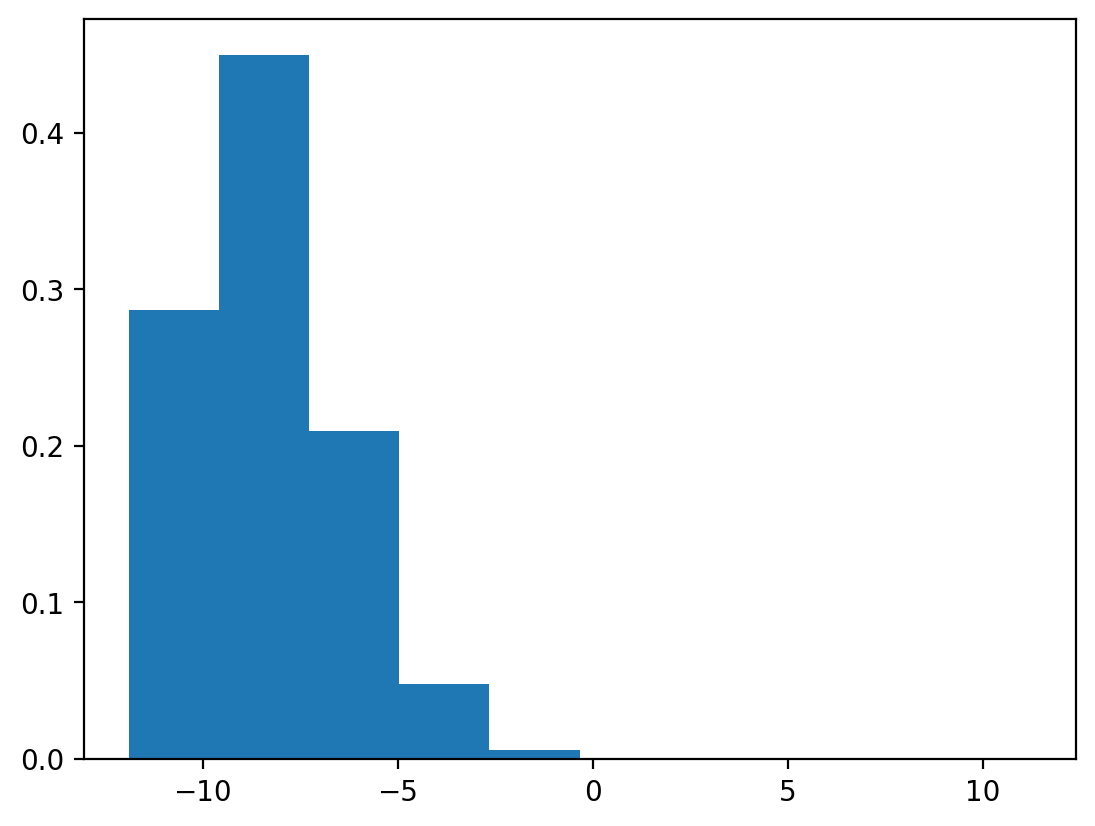

tensor([-5.2055e-09, -8.1200e-10, -4.5824e-10,  ..., -2.6201e-04,
        -1.9166e-07, -3.2542e-08])

In [64]:
# plt.hist(energy_samples[:1028*10])
# plt.show()
Z = torch.exp( - energy_samples).sum()

plt.hist(energy_samples, weights= torch.exp( - energy_samples)/Z)
plt.show()
torch.exp(- energy_samples[:1028*10]) * energy_samples[:1028*10] / Z

In [65]:
steps=1000
ensemble=2048
Δt=1
p0 = torch.bernoulli(torch.rand(1,engine.model.sampler._prbm.nodes_per_partition)).to(dev).repeat(ensemble,1)
p0,p1,p2,p3 = block_gibbs_sampling(engine.model.sampler, p0, n_steps=5000)
p0T,p1T,p2T,p3T = p0,p1,p2,p3
for i in range(100):
    p0,p1,p2,p3 = block_gibbs_sampling(engine.model.sampler, p0, n_steps=5000)
    p0T = torch.cat((p0T,p0),dim=0)
    p1T = torch.cat((p1T,p1),dim=0)
    p2T = torch.cat((p2T,p2),dim=0)
    p3T = torch.cat((p3T,p3),dim=0)

In [66]:
post_samples_energy = engine.model.stater.energy_samples(p0T,p1T,p2T,p3T, 1.0 )

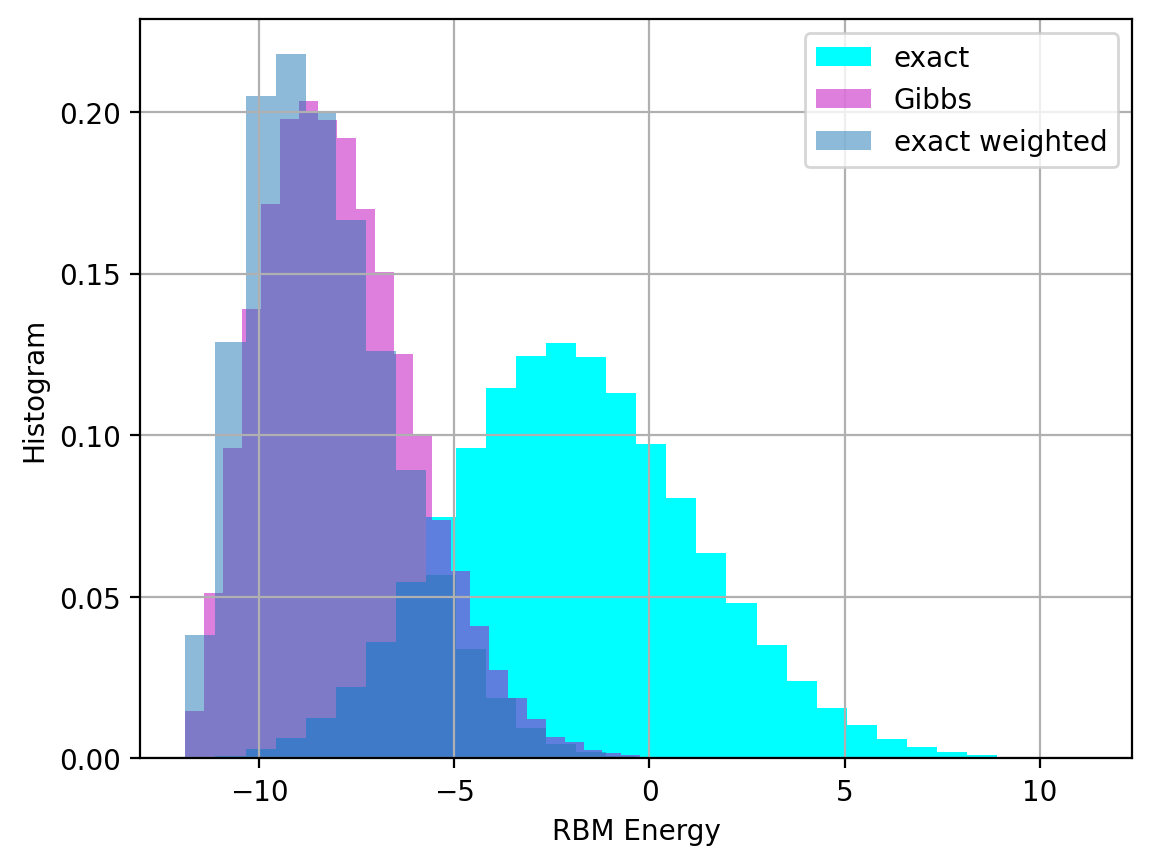

torch.Size([1048576]) torch.Size([103424])


In [67]:
plt.hist(energy_samples.detach().cpu(), density=True, color="cyan", label="exact", bins=30)
plt.hist(post_samples_energy.detach().cpu(), density=True, alpha=0.5, color="m", label="Gibbs", bins=30)
plt.hist(energy_samples, weights= torch.exp( - energy_samples)/Z, density=True, alpha=0.5, label="exact weighted", bins=30)
plt.legend()
plt.grid(True)
plt.xlabel("RBM Energy")
plt.ylabel("Histogram")
plt.show()
print(energy_samples.shape, post_samples_energy.shape)

In [20]:
beta, beta_list, rbm_energy_list, dwave_energy_list, thrsh_met = engine.model.find_beta( num_reads=1028, beta_init=7.29, lr=0.01, num_epochs = 30, delta = 4.0, method = 2, 
                                                                                        TOL=True, const = 1.0, adaptive = True)
beta0 = beta

[00:03:09.917] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 7.29
[00:03:11.244] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 8.600659463594672
[00:03:12.698] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 2: beta = 7.5534019470649705


In [30]:
beta, beta_list, rbm_energy_list, dwave_energy_list, thrsh_met = engine.model.find_beta_smallRBM(energy_samples[:1028*10].numpy(),  num_reads=1028, beta_init=807.29, lr=0.1, num_epochs = 30, delta = 4.0, method = 1, 
                                                                                        TOL=True, const = 1.0, adaptive = False)
beta0 = beta

[00:14:59.804] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 0: beta = 807.29
[00:15:00.310] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 1: beta = 807.3837247753142
[00:15:00.836] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 2: beta = 807.4793776178359
[00:15:01.511] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 3: beta = 807.584793319702
[00:15:02.020] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 4: beta = 807.6707212948799
[00:15:02.519] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 5: beta = 807.7515345716475
[00:15:03.035] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 6: beta = 807.8530559682845
[00:15:03.563] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 7: beta = 807.9096825563906
[00:15:04.083] INFO   models.autoencoders.AtlasConditionalQVAE          Epoch 8: beta = 807.9389060819148
[00:15:04.610] INFO   models.autoencoders.AtlasConditional

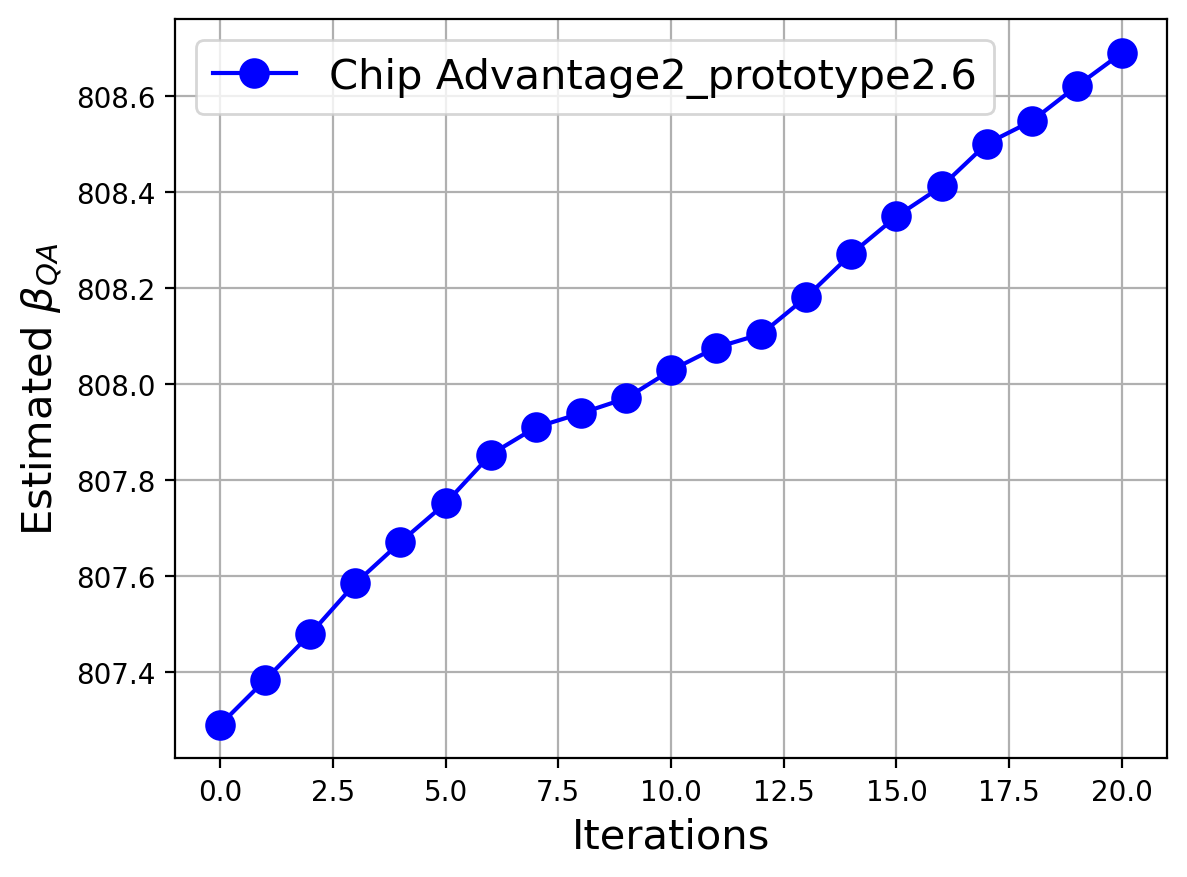

In [31]:
plt.plot( beta_list, linewidth=1.5, color="b" ,marker="o", ms=10)
plt.xlabel("Iterations", fontsize=15)
plt.ylabel("Estimated $β_{QA}$", fontsize=15)
plt.legend([f'Chip {engine.model._qpu_sampler.properties["chip_id"]}'], fontsize=15)
# plt.title(f'{ds[part]}')
plt.grid("True")
# plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/beta_QA_{engine.model._qpu_sampler.properties["chip_id"]}_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

In [40]:
QA = "$β_{QA}$"

In [39]:
Hoffset = -(sum([engine.model.prior.bias_dict[key].sum().detach().cpu().item() for key in engine.model.prior.bias_dict.keys()])/2 
            + sum([engine.model.prior.weight_dict[key].sum().detach().cpu().item() for key in engine.model.prior.weight_dict.keys()])/4)
print(Hoffset)

3.544526293873787


-0.24022868275642395


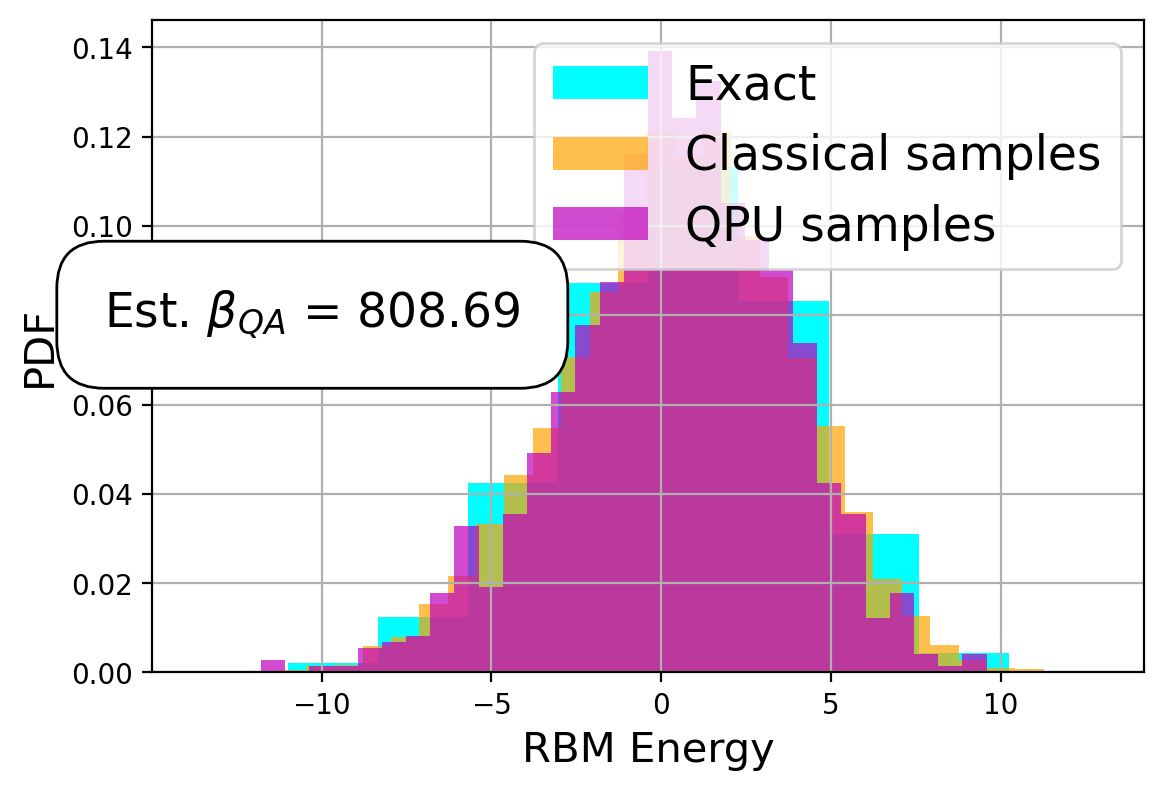

10280
1028


In [34]:
QA = "$β_{QA}$"
Hoffset = -(sum([engine.model.prior.bias_dict[key].sum().detach().cpu().item() for key in engine.model.prior.bias_dict.keys()])/2 
            + sum([engine.model.prior.weight_dict[key].sum().detach().cpu().item() for key in engine.model.prior.weight_dict.keys()])/4)
print(Hoffset)

minVal, maxVal = min(dwave_energy_list[-1]), max(dwave_energy_list[-1])
# minVal, maxVal = min(energy_dwave.detach().cpu().numpy()+ Hoffset/2), max(energy_dwave.detach().cpu().numpy()+ Hoffset/2)
binwidth = (maxVal-minVal)/15

# plt.figure(figsize=(8,6))
plt.hist(energy_samples.detach().cpu(), density=True, color="cyan")
# plt.hist(rbm_energy_list[-1], density=True, color="orange", alpha=0.7, bins=np.arange(minVal, maxVal + binwidth, binwidth))
# plt.hist(dwave_energy_list[-1], density=True, color="m", alpha=0.7, bins=np.arange(minVal, maxVal + binwidth, binwidth))
plt.hist(rbm_energy_list[-1], density=True, color="orange", alpha=0.7, bins=30)
plt.hist(dwave_energy_list[-1], density=True, color="m", alpha=0.7, bins=30)
plt.xlabel("RBM Energy", fontsize=15)
plt.ylabel("PDF", fontsize=15)
plt.legend(["Exact", "Classical samples", "QPU samples"], fontsize=17)
# plt.title(f'ln(Z)[AIS] = {np.round(Zais)}, ln(Z)[RAIS] = {np.round(Zrais)}')
plt.figtext(0.25, 0.6, f'Est. {QA} = {np.round(beta0, 2)}', ha='center', va='top', fontsize=17, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1'))
plt.subplots_adjust(bottom=0.2)
plt.grid("True")
# plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/Ising_energy_{modelname}_{arch}_{datascaled}_{part}_W.png')
plt.show()
print(len(rbm_energy_list[-1]))
print(len(dwave_energy_list[-1]))